In [22]:
import math
import numpy as np
from scipy.special import erfinv
from scipy.stats import norm
from scipy.optimize import fsolve
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Neural Networks
add a residual connection from the input to output

In [2]:
class MLP_light(nn.Module):
    def __init__(self, N, p):
        super(MLP_light, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        output = self.fc3(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss
    
    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss

In [3]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 
    
    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss 

## Relative functions

In [4]:
class Generator_eye(object):
    def __init__(self, p, theta, beta_range) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.p)
        return gamma, beta, Y 

In [5]:
class Generator_doubleNormal(object):
    def __init__(self, p, theta, sigma0, sigma1, sigma=1) -> None:
        self.p = p 
        self.theta = theta 
        self.sigma0 = sigma0
        self.sigma1 = sigma1 
        self.sigma = sigma
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.randn(np.sum(gamma == 1)) * self.sigma1
        beta[gamma == 0] = rng.randn(np.sum(gamma == 0)) * self.sigma0 
        Y = beta@self.X.T + rng.randn(n, self.p) * self.sigma 
        return gamma, beta, Y 

In [6]:
temp = Generator_doubleNormal(18, 0.05, sigma0=0.1, sigma1=5)

In [7]:
gamma, beta, Y = temp.generate_samples(1000)

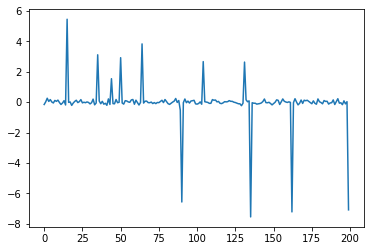

In [8]:
plt.plot(beta.reshape(-1)[:200])
plt.show()

In [6]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n
             
def model_test(model, data_loader, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        n = 0 
        total_loss = 0.
        for _, (data, targ) in enumerate(data_loader):
            data, targ = data.to(device), targ.to(device)
            if loss_type == 'mse':
                loss = model.get_mseloss(data, targ)
            elif loss_type == 'bce':
                loss = model.get_bceloss(data, targ)
            elif loss_type == 'quantile':
                loss = model.get_quanloss(data, targ, q)
            total_loss += loss.item() * data.shape[0]
            n += data.shape[0]
    return total_loss/n

def train_model(model, model_es, lr, epochs, train_data, loss_type='mse', q=0.5, val_data=None, early_stop=10):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    es_flag = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if (es_count >= early_stop) and (es_flag == 0):
                es_flag = 1
                print('Save early stopping model at epoch {}'.format(i+1))
                model_es.load_state_dict(deepcopy(model.state_dict()))
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [34]:
''' 
compute normalization constant
'''
def compute_c(y, theta, a, sigma):
    c = 2*a * (1-theta) * np.exp(-y**2 / (2 * sigma**2)) \
    + theta * np.sqrt(np.pi/2) * sigma * \
    (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-a)/(sigma*np.sqrt(2))))
    return c / (2*a)

In [6]:
''' 
compute the cumulative probablity of the marginal distribution of beta
'''
def cumulative_prob(t, y, norm_c, theta, a, sigma):
    assert t>=-a and t<=a
    if t>=0:
        prob = (1-theta) * np.exp(-y**2 / (2 * sigma**2)) / norm_c \
            + theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    elif t<0:
        prob = theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    return prob

In [7]:
def computeQuantile(y, norm_c, theta, a, sigma, q=0.975):
    inner = ((1-theta) / norm_c * np.exp(-y**2 / (2 * sigma**2)) - q) \
        / (theta / (2*a*norm_c) * np.sqrt(np.pi/2) * sigma) + math.erf((y+a)/(sigma*np.sqrt(2)))
    t = y - np.sqrt(2) * sigma * erfinv(inner)
    return t 
def computePPI(y, theta, a, sigma):
    q025 = q975 = 0
    c = compute_c(y, theta, a, sigma)
    abs_y = np.abs(y)
    if abs_y >= 1.68:
        q975 = computeQuantile(abs_y, c, theta, a, sigma, 0.975)
    if abs_y >= 4.168:
        q025 = computeQuantile(abs_y, c, theta, a, sigma, 0.025)
    if y < 0:
        temp = q025
        q025 = -q975
        q975 = -temp 
    return q025, q975
def computePosMean(y, theta, a, sigma):
    c = compute_c(y, theta, a, sigma)
    left = sigma**2 * (np.exp(-((-a-y)/np.sqrt(2)/sigma)**2) - np.exp(-((a-y)/np.sqrt(2)/sigma)**2))
    right = np.sqrt(np.pi/2) * sigma * y * \
        (math.erf((a-y)/(sigma*np.sqrt(2))) - math.erf((-a-y)/(sigma*np.sqrt(2))))
    mu = theta / (2*a*c) * (left + right)
    return mu 

In [8]:
def compute_mses(md_mean, md_q025, md_q975, Y, Y_normalized, theta, a, sigma):
    true_mean = np.zeros_like(Y)
    true_q025 = np.zeros_like(Y)
    true_q975 = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            true_mean[i,j] = computePosMean(Y[i,j], theta, a, sigma)
            true_q025[i,j], true_q975[i,j] = computePPI(Y[i,j], theta, a, sigma)
    pred_mean = predict(md_mean, Y_normalized)
    pred_q025 = predict(md_q025, Y_normalized)
    pred_q975 = predict(md_q975, Y_normalized)
    mse_mean = np.mean((pred_mean-true_mean)**2)
    mse_q025 = np.mean((pred_q025-true_q025)**2)
    mse_q975 = np.mean((pred_q975-true_q975)**2)
    return mse_mean, mse_q025, mse_q975

In [111]:
theta = 1
a = 10
sigma = 1
generator = Generator_eye(10, theta, (-a,a))
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
true_mean = np.zeros_like(Y_train)
for i in range(Y_train.shape[0]):
    for j in range(Y_train.shape[1]):
        true_mean[i,j] = computePosMean(Y_train[i,j], theta, a, sigma)
print(np.mean((Y_train-beta_train)**2))
print(np.mean((true_mean-beta_train)**2))

0.9994406104669161
0.9092823564263197


In [110]:
theta = 0.05
a = 10
sigma = 1
generator = Generator_eye(10, theta, (-a,a))
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
true_mean = np.zeros_like(Y_train)
for i in range(Y_train.shape[0]):
    for j in range(Y_train.shape[1]):
        true_mean[i,j] = computePosMean(Y_train[i,j], theta, a, sigma)
print(np.mean((Y_train-beta_train)**2))
print(np.mean((true_mean-beta_train)**2))

0.9997567962904437
0.10125002891050239


## Experiments

Epoch: 1
Train loss: 0.13060
Val loss: 0.11444
Epoch: 2
Train loss: 0.11178
Val loss: 0.11292
Epoch: 3
Train loss: 0.10975
Val loss: 0.11032
Epoch: 4
Train loss: 0.10871
Val loss: 0.11099
Epoch: 5
Train loss: 0.10807
Val loss: 0.11024
Epoch: 6
Train loss: 0.10747
Val loss: 0.10933
Epoch: 7
Train loss: 0.10712
Val loss: 0.11038
Epoch: 8
Train loss: 0.10688
Val loss: 0.10960
Epoch: 9
Train loss: 0.10662
Val loss: 0.10894
Epoch: 10
Train loss: 0.10627
Val loss: 0.10905
Epoch: 11
Train loss: 0.10619
Val loss: 0.10835
Epoch: 12
Train loss: 0.10595
Val loss: 0.10907
Epoch: 13
Train loss: 0.10576
Val loss: 0.10789
Epoch: 14
Train loss: 0.10565
Val loss: 0.10702
Epoch: 15
Train loss: 0.10549
Val loss: 0.10897
Epoch: 16
Train loss: 0.10536
Val loss: 0.10906
Epoch: 17
Train loss: 0.10518
Val loss: 0.10867
Epoch: 18
Train loss: 0.10515
Val loss: 0.10863
Epoch: 19
Train loss: 0.10500
Val loss: 0.10780
Save early stopping model at epoch 19
Epoch: 20
Train loss: 0.10492
Val loss: 0.10917
Epoch: 21
T

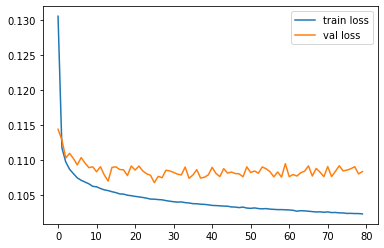

Epoch: 1
Train loss: 0.01444
Val loss: 0.01260
Epoch: 2
Train loss: 0.01192
Val loss: 0.01237
Epoch: 3
Train loss: 0.01163
Val loss: 0.01179
Epoch: 4
Train loss: 0.01150
Val loss: 0.01158
Epoch: 5
Train loss: 0.01139
Val loss: 0.01164
Epoch: 6
Train loss: 0.01131
Val loss: 0.01150
Epoch: 7
Train loss: 0.01124
Val loss: 0.01160
Epoch: 8
Train loss: 0.01117
Val loss: 0.01144
Epoch: 9
Train loss: 0.01114
Val loss: 0.01155
Epoch: 10
Train loss: 0.01110
Val loss: 0.01131
Epoch: 11
Train loss: 0.01105
Val loss: 0.01134
Epoch: 12
Train loss: 0.01102
Val loss: 0.01147
Epoch: 13
Train loss: 0.01100
Val loss: 0.01139
Epoch: 14
Train loss: 0.01099
Val loss: 0.01128
Epoch: 15
Train loss: 0.01097
Val loss: 0.01131
Epoch: 16
Train loss: 0.01096
Val loss: 0.01125
Epoch: 17
Train loss: 0.01094
Val loss: 0.01129
Epoch: 18
Train loss: 0.01093
Val loss: 0.01137
Epoch: 19
Train loss: 0.01092
Val loss: 0.01135
Epoch: 20
Train loss: 0.01091
Val loss: 0.01120
Epoch: 21
Train loss: 0.01091
Val loss: 0.01142
E

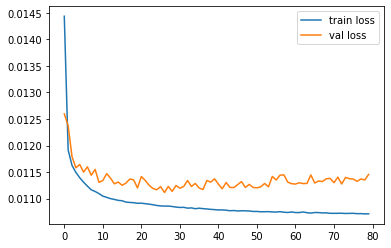

Epoch: 1
Train loss: 0.01431
Val loss: 0.01228
Epoch: 2
Train loss: 0.01175
Val loss: 0.01193
Epoch: 3
Train loss: 0.01145
Val loss: 0.01185
Epoch: 4
Train loss: 0.01130
Val loss: 0.01174
Epoch: 5
Train loss: 0.01117
Val loss: 0.01148
Epoch: 6
Train loss: 0.01109
Val loss: 0.01141
Epoch: 7
Train loss: 0.01102
Val loss: 0.01125
Epoch: 8
Train loss: 0.01096
Val loss: 0.01130
Epoch: 9
Train loss: 0.01091
Val loss: 0.01135
Epoch: 10
Train loss: 0.01087
Val loss: 0.01132
Epoch: 11
Train loss: 0.01085
Val loss: 0.01136
Epoch: 12
Train loss: 0.01083
Val loss: 0.01112
Epoch: 13
Train loss: 0.01081
Val loss: 0.01122
Epoch: 14
Train loss: 0.01079
Val loss: 0.01114
Epoch: 15
Train loss: 0.01078
Val loss: 0.01120
Epoch: 16
Train loss: 0.01077
Val loss: 0.01124
Epoch: 17
Train loss: 0.01075
Val loss: 0.01111
Epoch: 18
Train loss: 0.01074
Val loss: 0.01110
Epoch: 19
Train loss: 0.01073
Val loss: 0.01116
Epoch: 20
Train loss: 0.01072
Val loss: 0.01116
Epoch: 21
Train loss: 0.01071
Val loss: 0.01128
E

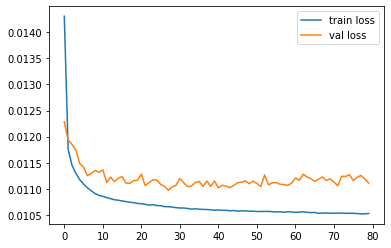

Epoch: 1
Train loss: 0.14107
Val loss: 0.11487
Epoch: 2
Train loss: 0.11355
Val loss: 0.11125
Epoch: 3
Train loss: 0.11125
Val loss: 0.11010
Epoch: 4
Train loss: 0.11011
Val loss: 0.10955
Epoch: 5
Train loss: 0.10940
Val loss: 0.10898
Epoch: 6
Train loss: 0.10883
Val loss: 0.10898
Epoch: 7
Train loss: 0.10848
Val loss: 0.10873
Epoch: 8
Train loss: 0.10812
Val loss: 0.10758
Epoch: 9
Train loss: 0.10786
Val loss: 0.10846
Epoch: 10
Train loss: 0.10750
Val loss: 0.10845
Epoch: 11
Train loss: 0.10730
Val loss: 0.10777
Epoch: 12
Train loss: 0.10704
Val loss: 0.10755
Epoch: 13
Train loss: 0.10682
Val loss: 0.10728
Epoch: 14
Train loss: 0.10664
Val loss: 0.10878
Epoch: 15
Train loss: 0.10646
Val loss: 0.10882
Epoch: 16
Train loss: 0.10628
Val loss: 0.10790
Epoch: 17
Train loss: 0.10612
Val loss: 0.10883
Epoch: 18
Train loss: 0.10591
Val loss: 0.10882
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.10578
Val loss: 0.10881
Epoch: 20
Train loss: 0.10569
Val loss: 0.10874
Epoch: 21
T

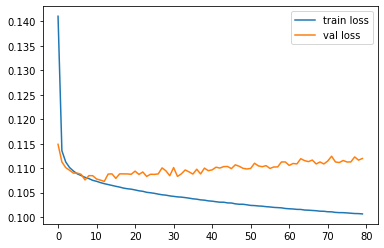

Epoch: 1
Train loss: 0.01619
Val loss: 0.01364
Epoch: 2
Train loss: 0.01351
Val loss: 0.01307
Epoch: 3
Train loss: 0.01308
Val loss: 0.01309
Epoch: 4
Train loss: 0.01290
Val loss: 0.01260
Epoch: 5
Train loss: 0.01278
Val loss: 0.01256
Epoch: 6
Train loss: 0.01268
Val loss: 0.01242
Epoch: 7
Train loss: 0.01261
Val loss: 0.01244
Epoch: 8
Train loss: 0.01256
Val loss: 0.01235
Epoch: 9
Train loss: 0.01253
Val loss: 0.01250
Epoch: 10
Train loss: 0.01248
Val loss: 0.01235
Epoch: 11
Train loss: 0.01245
Val loss: 0.01241
Epoch: 12
Train loss: 0.01242
Val loss: 0.01230
Epoch: 13
Train loss: 0.01239
Val loss: 0.01229
Epoch: 14
Train loss: 0.01236
Val loss: 0.01248
Epoch: 15
Train loss: 0.01233
Val loss: 0.01233
Epoch: 16
Train loss: 0.01230
Val loss: 0.01233
Epoch: 17
Train loss: 0.01227
Val loss: 0.01229
Epoch: 18
Train loss: 0.01225
Val loss: 0.01223
Epoch: 19
Train loss: 0.01223
Val loss: 0.01240
Epoch: 20
Train loss: 0.01221
Val loss: 0.01231
Epoch: 21
Train loss: 0.01220
Val loss: 0.01229
E

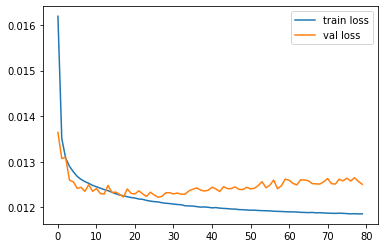

Epoch: 1
Train loss: 0.01628
Val loss: 0.01382
Epoch: 2
Train loss: 0.01353
Val loss: 0.01330
Epoch: 3
Train loss: 0.01312
Val loss: 0.01302
Epoch: 4
Train loss: 0.01296
Val loss: 0.01284
Epoch: 5
Train loss: 0.01285
Val loss: 0.01289
Epoch: 6
Train loss: 0.01277
Val loss: 0.01283
Epoch: 7
Train loss: 0.01270
Val loss: 0.01284
Epoch: 8
Train loss: 0.01264
Val loss: 0.01284
Epoch: 9
Train loss: 0.01259
Val loss: 0.01291
Epoch: 10
Train loss: 0.01255
Val loss: 0.01273
Epoch: 11
Train loss: 0.01252
Val loss: 0.01277
Epoch: 12
Train loss: 0.01248
Val loss: 0.01271
Epoch: 13
Train loss: 0.01245
Val loss: 0.01279
Epoch: 14
Train loss: 0.01241
Val loss: 0.01273
Epoch: 15
Train loss: 0.01238
Val loss: 0.01275
Epoch: 16
Train loss: 0.01236
Val loss: 0.01262
Epoch: 17
Train loss: 0.01233
Val loss: 0.01270
Epoch: 18
Train loss: 0.01231
Val loss: 0.01270
Epoch: 19
Train loss: 0.01229
Val loss: 0.01266
Epoch: 20
Train loss: 0.01229
Val loss: 0.01262
Epoch: 21
Train loss: 0.01226
Val loss: 0.01269
E

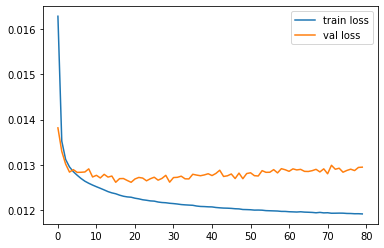

Epoch: 1
Train loss: 0.20050
Val loss: 0.13027
Epoch: 2
Train loss: 0.12469
Val loss: 0.12179
Epoch: 3
Train loss: 0.11917
Val loss: 0.12023
Epoch: 4
Train loss: 0.11680
Val loss: 0.11991
Epoch: 5
Train loss: 0.11534
Val loss: 0.11829
Epoch: 6
Train loss: 0.11433
Val loss: 0.11815
Epoch: 7
Train loss: 0.11358
Val loss: 0.11847
Epoch: 8
Train loss: 0.11299
Val loss: 0.11802
Epoch: 9
Train loss: 0.11255
Val loss: 0.11820
Epoch: 10
Train loss: 0.11211
Val loss: 0.11811
Epoch: 11
Train loss: 0.11177
Val loss: 0.11768
Epoch: 12
Train loss: 0.11144
Val loss: 0.11782
Epoch: 13
Train loss: 0.11115
Val loss: 0.11749
Epoch: 14
Train loss: 0.11090
Val loss: 0.11927
Epoch: 15
Train loss: 0.11065
Val loss: 0.11752
Epoch: 16
Train loss: 0.11038
Val loss: 0.11753
Epoch: 17
Train loss: 0.11023
Val loss: 0.11746
Epoch: 18
Train loss: 0.11006
Val loss: 0.11820
Epoch: 19
Train loss: 0.10988
Val loss: 0.11826
Epoch: 20
Train loss: 0.10969
Val loss: 0.11823
Epoch: 21
Train loss: 0.10956
Val loss: 0.11821
E

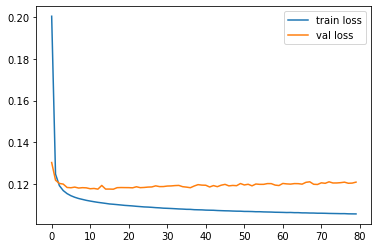

Epoch: 1
Train loss: 0.01983
Val loss: 0.01555
Epoch: 2
Train loss: 0.01471
Val loss: 0.01474
Epoch: 3
Train loss: 0.01399
Val loss: 0.01438
Epoch: 4
Train loss: 0.01371
Val loss: 0.01415
Epoch: 5
Train loss: 0.01354
Val loss: 0.01412
Epoch: 6
Train loss: 0.01341
Val loss: 0.01403
Epoch: 7
Train loss: 0.01330
Val loss: 0.01390
Epoch: 8
Train loss: 0.01322
Val loss: 0.01395
Epoch: 9
Train loss: 0.01316
Val loss: 0.01388
Epoch: 10
Train loss: 0.01310
Val loss: 0.01386
Epoch: 11
Train loss: 0.01305
Val loss: 0.01386
Epoch: 12
Train loss: 0.01300
Val loss: 0.01386
Epoch: 13
Train loss: 0.01295
Val loss: 0.01384
Epoch: 14
Train loss: 0.01291
Val loss: 0.01381
Epoch: 15
Train loss: 0.01288
Val loss: 0.01373
Epoch: 16
Train loss: 0.01285
Val loss: 0.01382
Epoch: 17
Train loss: 0.01282
Val loss: 0.01392
Epoch: 18
Train loss: 0.01280
Val loss: 0.01382
Epoch: 19
Train loss: 0.01277
Val loss: 0.01387
Epoch: 20
Train loss: 0.01275
Val loss: 0.01384
Save early stopping model at epoch 20
Epoch: 21
T

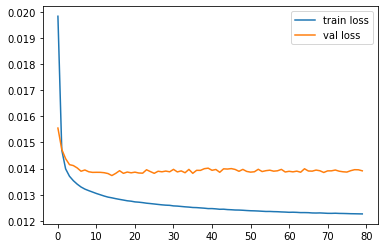

Epoch: 1
Train loss: 0.01986
Val loss: 0.01529
Epoch: 2
Train loss: 0.01480
Val loss: 0.01444
Epoch: 3
Train loss: 0.01402
Val loss: 0.01404
Epoch: 4
Train loss: 0.01371
Val loss: 0.01399
Epoch: 5
Train loss: 0.01356
Val loss: 0.01386
Epoch: 6
Train loss: 0.01343
Val loss: 0.01373
Epoch: 7
Train loss: 0.01334
Val loss: 0.01371
Epoch: 8
Train loss: 0.01325
Val loss: 0.01376
Epoch: 9
Train loss: 0.01319
Val loss: 0.01368
Epoch: 10
Train loss: 0.01313
Val loss: 0.01367
Epoch: 11
Train loss: 0.01308
Val loss: 0.01364
Epoch: 12
Train loss: 0.01303
Val loss: 0.01364
Epoch: 13
Train loss: 0.01298
Val loss: 0.01361
Epoch: 14
Train loss: 0.01295
Val loss: 0.01357
Epoch: 15
Train loss: 0.01292
Val loss: 0.01365
Epoch: 16
Train loss: 0.01290
Val loss: 0.01357
Epoch: 17
Train loss: 0.01287
Val loss: 0.01363
Epoch: 18
Train loss: 0.01285
Val loss: 0.01363
Epoch: 19
Train loss: 0.01283
Val loss: 0.01356
Epoch: 20
Train loss: 0.01281
Val loss: 0.01366
Epoch: 21
Train loss: 0.01279
Val loss: 0.01374
E

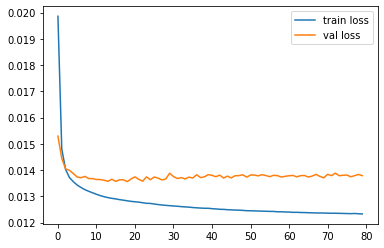

Epoch: 1
Train loss: 0.28356
Val loss: 0.14624
Epoch: 2
Train loss: 0.13859
Val loss: 0.13255
Epoch: 3
Train loss: 0.12870
Val loss: 0.12691
Epoch: 4
Train loss: 0.12419
Val loss: 0.12488
Epoch: 5
Train loss: 0.12165
Val loss: 0.12341
Epoch: 6
Train loss: 0.11993
Val loss: 0.12180
Epoch: 7
Train loss: 0.11872
Val loss: 0.12132
Epoch: 8
Train loss: 0.11779
Val loss: 0.12169
Epoch: 9
Train loss: 0.11706
Val loss: 0.12067
Epoch: 10
Train loss: 0.11640
Val loss: 0.12051
Epoch: 11
Train loss: 0.11590
Val loss: 0.12013
Epoch: 12
Train loss: 0.11543
Val loss: 0.11998
Epoch: 13
Train loss: 0.11502
Val loss: 0.11956
Epoch: 14
Train loss: 0.11465
Val loss: 0.11952
Epoch: 15
Train loss: 0.11428
Val loss: 0.11997
Epoch: 16
Train loss: 0.11391
Val loss: 0.11959
Epoch: 17
Train loss: 0.11359
Val loss: 0.11890
Epoch: 18
Train loss: 0.11325
Val loss: 0.11886
Epoch: 19
Train loss: 0.11299
Val loss: 0.11871
Epoch: 20
Train loss: 0.11272
Val loss: 0.11846
Epoch: 21
Train loss: 0.11242
Val loss: 0.11925
E

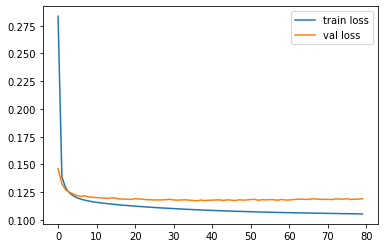

Epoch: 1
Train loss: 0.02373
Val loss: 0.01582
Epoch: 2
Train loss: 0.01544
Val loss: 0.01527
Epoch: 3
Train loss: 0.01490
Val loss: 0.01479
Epoch: 4
Train loss: 0.01450
Val loss: 0.01443
Epoch: 5
Train loss: 0.01422
Val loss: 0.01430
Epoch: 6
Train loss: 0.01400
Val loss: 0.01426
Epoch: 7
Train loss: 0.01384
Val loss: 0.01414
Epoch: 8
Train loss: 0.01365
Val loss: 0.01390
Epoch: 9
Train loss: 0.01349
Val loss: 0.01382
Epoch: 10
Train loss: 0.01338
Val loss: 0.01370
Epoch: 11
Train loss: 0.01331
Val loss: 0.01374
Epoch: 12
Train loss: 0.01326
Val loss: 0.01375
Epoch: 13
Train loss: 0.01322
Val loss: 0.01370
Epoch: 14
Train loss: 0.01317
Val loss: 0.01373
Epoch: 15
Train loss: 0.01313
Val loss: 0.01372
Epoch: 16
Train loss: 0.01310
Val loss: 0.01378
Epoch: 17
Train loss: 0.01308
Val loss: 0.01371
Epoch: 18
Train loss: 0.01304
Val loss: 0.01371
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.01301
Val loss: 0.01367
Epoch: 20
Train loss: 0.01299
Val loss: 0.01372
Epoch: 21
T

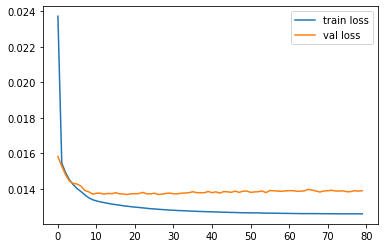

Epoch: 1
Train loss: 0.02391
Val loss: 0.01606
Epoch: 2
Train loss: 0.01540
Val loss: 0.01536
Epoch: 3
Train loss: 0.01490
Val loss: 0.01506
Epoch: 4
Train loss: 0.01456
Val loss: 0.01484
Epoch: 5
Train loss: 0.01429
Val loss: 0.01459
Epoch: 6
Train loss: 0.01404
Val loss: 0.01453
Epoch: 7
Train loss: 0.01380
Val loss: 0.01426
Epoch: 8
Train loss: 0.01358
Val loss: 0.01413
Epoch: 9
Train loss: 0.01342
Val loss: 0.01395
Epoch: 10
Train loss: 0.01330
Val loss: 0.01386
Epoch: 11
Train loss: 0.01322
Val loss: 0.01392
Epoch: 12
Train loss: 0.01317
Val loss: 0.01383
Epoch: 13
Train loss: 0.01312
Val loss: 0.01389
Epoch: 14
Train loss: 0.01308
Val loss: 0.01394
Epoch: 15
Train loss: 0.01305
Val loss: 0.01392
Epoch: 16
Train loss: 0.01302
Val loss: 0.01383
Epoch: 17
Train loss: 0.01299
Val loss: 0.01392
Epoch: 18
Train loss: 0.01296
Val loss: 0.01386
Epoch: 19
Train loss: 0.01293
Val loss: 0.01387
Epoch: 20
Train loss: 0.01291
Val loss: 0.01391
Epoch: 21
Train loss: 0.01288
Val loss: 0.01385
S

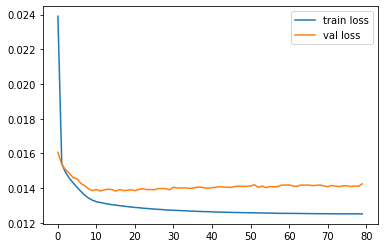

Epoch: 1
Train loss: 0.33915
Val loss: 0.15507
Epoch: 2
Train loss: 0.14437
Val loss: 0.14036
Epoch: 3
Train loss: 0.13274
Val loss: 0.13283
Epoch: 4
Train loss: 0.12736
Val loss: 0.13030
Epoch: 5
Train loss: 0.12466
Val loss: 0.12864
Epoch: 6
Train loss: 0.12283
Val loss: 0.12693
Epoch: 7
Train loss: 0.12146
Val loss: 0.12690
Epoch: 8
Train loss: 0.12046
Val loss: 0.12530
Epoch: 9
Train loss: 0.11965
Val loss: 0.12497
Epoch: 10
Train loss: 0.11887
Val loss: 0.12442
Epoch: 11
Train loss: 0.11829
Val loss: 0.12470
Epoch: 12
Train loss: 0.11776
Val loss: 0.12338
Epoch: 13
Train loss: 0.11729
Val loss: 0.12362
Epoch: 14
Train loss: 0.11684
Val loss: 0.12313
Epoch: 15
Train loss: 0.11641
Val loss: 0.12284
Epoch: 16
Train loss: 0.11601
Val loss: 0.12281
Epoch: 17
Train loss: 0.11562
Val loss: 0.12206
Epoch: 18
Train loss: 0.11524
Val loss: 0.12208
Epoch: 19
Train loss: 0.11489
Val loss: 0.12149
Epoch: 20
Train loss: 0.11455
Val loss: 0.12178
Epoch: 21
Train loss: 0.11428
Val loss: 0.12196
E

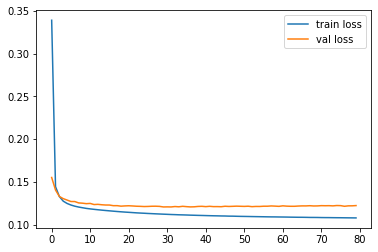

Epoch: 1
Train loss: 0.02651
Val loss: 0.01728
Epoch: 2
Train loss: 0.01634
Val loss: 0.01588
Epoch: 3
Train loss: 0.01495
Val loss: 0.01456
Epoch: 4
Train loss: 0.01413
Val loss: 0.01413
Epoch: 5
Train loss: 0.01384
Val loss: 0.01389
Epoch: 6
Train loss: 0.01368
Val loss: 0.01384
Epoch: 7
Train loss: 0.01359
Val loss: 0.01375
Epoch: 8
Train loss: 0.01350
Val loss: 0.01375
Epoch: 9
Train loss: 0.01344
Val loss: 0.01371
Epoch: 10
Train loss: 0.01338
Val loss: 0.01364
Epoch: 11
Train loss: 0.01333
Val loss: 0.01369
Epoch: 12
Train loss: 0.01328
Val loss: 0.01371
Epoch: 13
Train loss: 0.01324
Val loss: 0.01370
Epoch: 14
Train loss: 0.01321
Val loss: 0.01367
Epoch: 15
Train loss: 0.01317
Val loss: 0.01370
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01313
Val loss: 0.01367
Epoch: 17
Train loss: 0.01311
Val loss: 0.01368
Epoch: 18
Train loss: 0.01308
Val loss: 0.01366
Epoch: 19
Train loss: 0.01306
Val loss: 0.01364
Epoch: 20
Train loss: 0.01304
Val loss: 0.01373
Epoch: 21
T

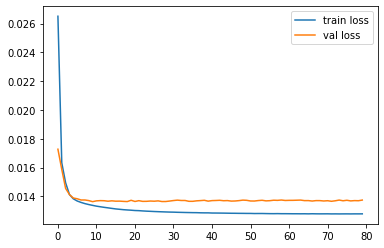

Epoch: 1
Train loss: 0.02628
Val loss: 0.01692
Epoch: 2
Train loss: 0.01583
Val loss: 0.01537
Epoch: 3
Train loss: 0.01476
Val loss: 0.01466
Epoch: 4
Train loss: 0.01416
Val loss: 0.01429
Epoch: 5
Train loss: 0.01386
Val loss: 0.01415
Epoch: 6
Train loss: 0.01372
Val loss: 0.01401
Epoch: 7
Train loss: 0.01363
Val loss: 0.01399
Epoch: 8
Train loss: 0.01356
Val loss: 0.01389
Epoch: 9
Train loss: 0.01349
Val loss: 0.01399
Epoch: 10
Train loss: 0.01342
Val loss: 0.01389
Epoch: 11
Train loss: 0.01337
Val loss: 0.01391
Epoch: 12
Train loss: 0.01332
Val loss: 0.01396
Epoch: 13
Train loss: 0.01328
Val loss: 0.01398
Epoch: 14
Train loss: 0.01325
Val loss: 0.01401
Epoch: 15
Train loss: 0.01322
Val loss: 0.01394
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01319
Val loss: 0.01395
Epoch: 17
Train loss: 0.01316
Val loss: 0.01398
Epoch: 18
Train loss: 0.01313
Val loss: 0.01394
Epoch: 19
Train loss: 0.01311
Val loss: 0.01395
Epoch: 20
Train loss: 0.01309
Val loss: 0.01397
Epoch: 21
T

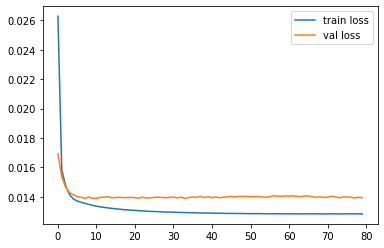

Epoch: 1
Train loss: 0.42083
Val loss: 0.16518
Epoch: 2
Train loss: 0.15134
Val loss: 0.14498
Epoch: 3
Train loss: 0.14041
Val loss: 0.13648
Epoch: 4
Train loss: 0.13291
Val loss: 0.13101
Epoch: 5
Train loss: 0.12862
Val loss: 0.12832
Epoch: 6
Train loss: 0.12604
Val loss: 0.12603
Epoch: 7
Train loss: 0.12420
Val loss: 0.12508
Epoch: 8
Train loss: 0.12287
Val loss: 0.12358
Epoch: 9
Train loss: 0.12168
Val loss: 0.12281
Epoch: 10
Train loss: 0.12073
Val loss: 0.12208
Epoch: 11
Train loss: 0.11990
Val loss: 0.12140
Epoch: 12
Train loss: 0.11911
Val loss: 0.12090
Epoch: 13
Train loss: 0.11845
Val loss: 0.12006
Epoch: 14
Train loss: 0.11781
Val loss: 0.11981
Epoch: 15
Train loss: 0.11727
Val loss: 0.11950
Epoch: 16
Train loss: 0.11682
Val loss: 0.11934
Epoch: 17
Train loss: 0.11635
Val loss: 0.11926
Epoch: 18
Train loss: 0.11588
Val loss: 0.11894
Epoch: 19
Train loss: 0.11547
Val loss: 0.11891
Epoch: 20
Train loss: 0.11514
Val loss: 0.11870
Epoch: 21
Train loss: 0.11482
Val loss: 0.11890
E

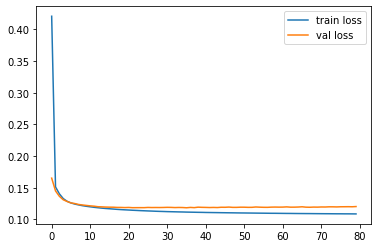

Epoch: 1
Train loss: 0.02818
Val loss: 0.01780
Epoch: 2
Train loss: 0.01716
Val loss: 0.01685
Epoch: 3
Train loss: 0.01634
Val loss: 0.01592
Epoch: 4
Train loss: 0.01569
Val loss: 0.01549
Epoch: 5
Train loss: 0.01532
Val loss: 0.01519
Epoch: 6
Train loss: 0.01506
Val loss: 0.01496
Epoch: 7
Train loss: 0.01484
Val loss: 0.01473
Epoch: 8
Train loss: 0.01466
Val loss: 0.01451
Epoch: 9
Train loss: 0.01453
Val loss: 0.01447
Epoch: 10
Train loss: 0.01440
Val loss: 0.01435
Epoch: 11
Train loss: 0.01427
Val loss: 0.01421
Epoch: 12
Train loss: 0.01417
Val loss: 0.01404


In [ ]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [10,20,50,80,100,120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

-----------------------------------------
 10
Epoch: 1
Train loss: 0.14579
Val loss: 0.13330
Epoch: 2
Train loss: 0.13299
Val loss: 0.13328
Epoch: 3
Train loss: 0.13100
Val loss: 0.12931
Epoch: 4
Train loss: 0.12993
Val loss: 0.12949
Epoch: 5
Train loss: 0.12922
Val loss: 0.12900
Epoch: 6
Train loss: 0.12871
Val loss: 0.12911
Epoch: 7
Train loss: 0.12845
Val loss: 0.12882
Epoch: 8
Train loss: 0.12804
Val loss: 0.12834
Epoch: 9
Train loss: 0.12781
Val loss: 0.12722
Epoch: 10
Train loss: 0.12768
Val loss: 0.12783
Epoch: 11
Train loss: 0.12737
Val loss: 0.12726
Epoch: 12
Train loss: 0.12720
Val loss: 0.12749
Epoch: 13
Train loss: 0.12708
Val loss: 0.12759
Epoch: 14
Train loss: 0.12695
Val loss: 0.12795
Epoch: 15
Train loss: 0.12679
Val loss: 0.12744
Epoch: 16
Train loss: 0.12668
Val loss: 0.12878
Epoch: 17
Train loss: 0.12663
Val loss: 0.12821
Epoch: 18
Train loss: 0.12654
Val loss: 0.12605
Epoch: 19
Train loss: 0.12638
Val loss: 0.12769
Epoch: 20
Train loss: 0.12637
Val loss: 0.12641
Epo

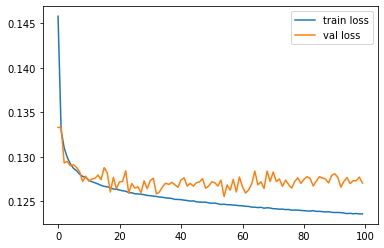

Epoch: 1
Train loss: 0.01942
Val loss: 0.01769
Epoch: 2
Train loss: 0.01767
Val loss: 0.01744
Epoch: 3
Train loss: 0.01748
Val loss: 0.01718
Epoch: 4
Train loss: 0.01738
Val loss: 0.01699
Epoch: 5
Train loss: 0.01730
Val loss: 0.01703
Epoch: 6
Train loss: 0.01726
Val loss: 0.01700
Epoch: 7
Train loss: 0.01721
Val loss: 0.01694
Epoch: 8
Train loss: 0.01718
Val loss: 0.01693
Epoch: 9
Train loss: 0.01716
Val loss: 0.01693
Epoch: 10
Train loss: 0.01713
Val loss: 0.01695
Epoch: 11
Train loss: 0.01711
Val loss: 0.01686
Epoch: 12
Train loss: 0.01711
Val loss: 0.01696
Epoch: 13
Train loss: 0.01709
Val loss: 0.01686
Epoch: 14
Train loss: 0.01706
Val loss: 0.01689
Epoch: 15
Train loss: 0.01705
Val loss: 0.01681
Epoch: 16
Train loss: 0.01705
Val loss: 0.01670
Epoch: 17
Train loss: 0.01704
Val loss: 0.01684
Epoch: 18
Train loss: 0.01702
Val loss: 0.01682
Epoch: 19
Train loss: 0.01702
Val loss: 0.01679
Epoch: 20
Train loss: 0.01701
Val loss: 0.01681
Epoch: 21
Train loss: 0.01701
Val loss: 0.01687
E

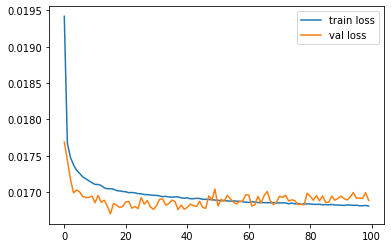

Epoch: 1
Train loss: 0.01944
Val loss: 0.01810
Epoch: 2
Train loss: 0.01768
Val loss: 0.01740
Epoch: 3
Train loss: 0.01748
Val loss: 0.01743
Epoch: 4
Train loss: 0.01736
Val loss: 0.01732
Epoch: 5
Train loss: 0.01730
Val loss: 0.01695
Epoch: 6
Train loss: 0.01724
Val loss: 0.01712
Epoch: 7
Train loss: 0.01719
Val loss: 0.01709
Epoch: 8
Train loss: 0.01716
Val loss: 0.01720
Epoch: 9
Train loss: 0.01714
Val loss: 0.01703
Epoch: 10
Train loss: 0.01712
Val loss: 0.01706
Epoch: 11
Train loss: 0.01709
Val loss: 0.01704
Epoch: 12
Train loss: 0.01709
Val loss: 0.01712
Epoch: 13
Train loss: 0.01707
Val loss: 0.01696
Epoch: 14
Train loss: 0.01706
Val loss: 0.01716
Epoch: 15
Train loss: 0.01705
Val loss: 0.01695
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01704
Val loss: 0.01712
Epoch: 17
Train loss: 0.01702
Val loss: 0.01698
Epoch: 18
Train loss: 0.01702
Val loss: 0.01689
Epoch: 19
Train loss: 0.01701
Val loss: 0.01708
Epoch: 20
Train loss: 0.01701
Val loss: 0.01695
Epoch: 21
T

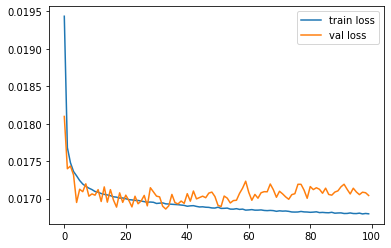

-----------------------------------------
 20
Epoch: 1
Train loss: 0.15491
Val loss: 0.13890
Epoch: 2
Train loss: 0.13456
Val loss: 0.13624
Epoch: 3
Train loss: 0.13243
Val loss: 0.13515
Epoch: 4
Train loss: 0.13129
Val loss: 0.13382
Epoch: 5
Train loss: 0.13058
Val loss: 0.13495
Epoch: 6
Train loss: 0.13014
Val loss: 0.13384
Epoch: 7
Train loss: 0.12965
Val loss: 0.13318
Epoch: 8
Train loss: 0.12932
Val loss: 0.13341
Epoch: 9
Train loss: 0.12896
Val loss: 0.13500
Epoch: 10
Train loss: 0.12872
Val loss: 0.13272
Epoch: 11
Train loss: 0.12850
Val loss: 0.13227
Epoch: 12
Train loss: 0.12833
Val loss: 0.13273
Epoch: 13
Train loss: 0.12813
Val loss: 0.13361
Epoch: 14
Train loss: 0.12790
Val loss: 0.13333
Epoch: 15
Train loss: 0.12771
Val loss: 0.13327
Epoch: 16
Train loss: 0.12760
Val loss: 0.13434
Epoch: 17
Train loss: 0.12738
Val loss: 0.13441
Epoch: 18
Train loss: 0.12734
Val loss: 0.13415
Epoch: 19
Train loss: 0.12712
Val loss: 0.13358
Epoch: 20
Train loss: 0.12699
Val loss: 0.13398
Epo

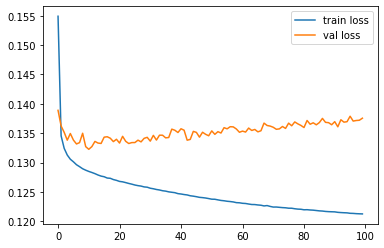

Epoch: 1
Train loss: 0.02059
Val loss: 0.01914
Epoch: 2
Train loss: 0.01833
Val loss: 0.01808
Epoch: 3
Train loss: 0.01780
Val loss: 0.01780
Epoch: 4
Train loss: 0.01766
Val loss: 0.01776
Epoch: 5
Train loss: 0.01756
Val loss: 0.01776
Epoch: 6
Train loss: 0.01750
Val loss: 0.01757
Epoch: 7
Train loss: 0.01744
Val loss: 0.01763
Epoch: 8
Train loss: 0.01739
Val loss: 0.01754
Epoch: 9
Train loss: 0.01735
Val loss: 0.01748
Epoch: 10
Train loss: 0.01731
Val loss: 0.01746
Epoch: 11
Train loss: 0.01728
Val loss: 0.01758
Epoch: 12
Train loss: 0.01726
Val loss: 0.01748
Epoch: 13
Train loss: 0.01724
Val loss: 0.01736
Epoch: 14
Train loss: 0.01722
Val loss: 0.01735
Epoch: 15
Train loss: 0.01720
Val loss: 0.01736
Epoch: 16
Train loss: 0.01718
Val loss: 0.01752
Epoch: 17
Train loss: 0.01716
Val loss: 0.01741
Epoch: 18
Train loss: 0.01714
Val loss: 0.01754
Epoch: 19
Train loss: 0.01714
Val loss: 0.01751
Epoch: 20
Train loss: 0.01712
Val loss: 0.01745
Epoch: 21
Train loss: 0.01711
Val loss: 0.01748
E

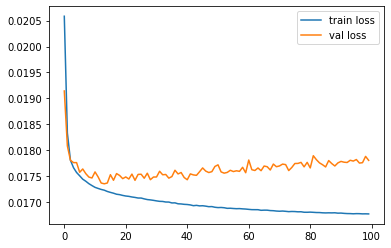

Epoch: 1
Train loss: 0.02071
Val loss: 0.01898
Epoch: 2
Train loss: 0.01829
Val loss: 0.01797
Epoch: 3
Train loss: 0.01781
Val loss: 0.01767
Epoch: 4
Train loss: 0.01766
Val loss: 0.01782
Epoch: 5
Train loss: 0.01756
Val loss: 0.01769
Epoch: 6
Train loss: 0.01749
Val loss: 0.01757
Epoch: 7
Train loss: 0.01743
Val loss: 0.01752
Epoch: 8
Train loss: 0.01738
Val loss: 0.01758
Epoch: 9
Train loss: 0.01735
Val loss: 0.01742
Epoch: 10
Train loss: 0.01732
Val loss: 0.01756
Epoch: 11
Train loss: 0.01729
Val loss: 0.01740
Epoch: 12
Train loss: 0.01726
Val loss: 0.01741
Epoch: 13
Train loss: 0.01723
Val loss: 0.01742
Epoch: 14
Train loss: 0.01722
Val loss: 0.01747
Epoch: 15
Train loss: 0.01719
Val loss: 0.01741
Epoch: 16
Train loss: 0.01718
Val loss: 0.01750
Epoch: 17
Train loss: 0.01717
Val loss: 0.01742
Epoch: 18
Train loss: 0.01715
Val loss: 0.01746
Epoch: 19
Train loss: 0.01713
Val loss: 0.01740
Epoch: 20
Train loss: 0.01712
Val loss: 0.01746
Epoch: 21
Train loss: 0.01711
Val loss: 0.01746
S

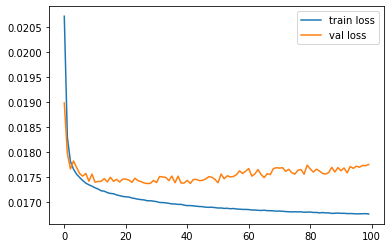

-----------------------------------------
 50
Epoch: 1
Train loss: 0.18905
Val loss: 0.14463
Epoch: 2
Train loss: 0.14162
Val loss: 0.14129
Epoch: 3
Train loss: 0.13818
Val loss: 0.13946
Epoch: 4
Train loss: 0.13662
Val loss: 0.13838
Epoch: 5
Train loss: 0.13563
Val loss: 0.13877
Epoch: 6
Train loss: 0.13496
Val loss: 0.13802
Epoch: 7
Train loss: 0.13445
Val loss: 0.13856
Epoch: 8
Train loss: 0.13400
Val loss: 0.13829
Epoch: 9
Train loss: 0.13364
Val loss: 0.13859
Epoch: 10
Train loss: 0.13332
Val loss: 0.13855
Epoch: 11
Train loss: 0.13310
Val loss: 0.13827
Epoch: 12
Train loss: 0.13288
Val loss: 0.13846
Epoch: 13
Train loss: 0.13265
Val loss: 0.13865
Epoch: 14
Train loss: 0.13241
Val loss: 0.13825
Epoch: 15
Train loss: 0.13222
Val loss: 0.13810
Epoch: 16
Train loss: 0.13204
Val loss: 0.13813
Save early stopping model at epoch 16
Epoch: 17
Train loss: 0.13185
Val loss: 0.13853
Epoch: 18
Train loss: 0.13171
Val loss: 0.13862
Epoch: 19
Train loss: 0.13161
Val loss: 0.13897
Epoch: 20
Tra

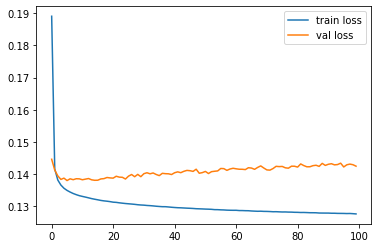

Epoch: 1
Train loss: 0.02329
Val loss: 0.02036
Epoch: 2
Train loss: 0.01976
Val loss: 0.01981
Epoch: 3
Train loss: 0.01930
Val loss: 0.01964
Epoch: 4
Train loss: 0.01906
Val loss: 0.01953
Epoch: 5
Train loss: 0.01890
Val loss: 0.01936
Epoch: 6
Train loss: 0.01879
Val loss: 0.01938
Epoch: 7
Train loss: 0.01871
Val loss: 0.01929
Epoch: 8
Train loss: 0.01864
Val loss: 0.01931
Epoch: 9
Train loss: 0.01859
Val loss: 0.01926
Epoch: 10
Train loss: 0.01854
Val loss: 0.01927
Epoch: 11
Train loss: 0.01851
Val loss: 0.01928
Epoch: 12
Train loss: 0.01847
Val loss: 0.01931
Epoch: 13
Train loss: 0.01843
Val loss: 0.01924
Epoch: 14
Train loss: 0.01841
Val loss: 0.01922
Epoch: 15
Train loss: 0.01839
Val loss: 0.01928
Epoch: 16
Train loss: 0.01836
Val loss: 0.01934
Epoch: 17
Train loss: 0.01834
Val loss: 0.01925
Epoch: 18
Train loss: 0.01832
Val loss: 0.01926
Epoch: 19
Train loss: 0.01831
Val loss: 0.01923
Epoch: 20
Train loss: 0.01829
Val loss: 0.01929
Epoch: 21
Train loss: 0.01827
Val loss: 0.01935
E

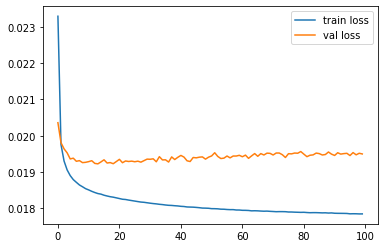

Epoch: 1
Train loss: 0.02340
Val loss: 0.01990
Epoch: 2
Train loss: 0.01982
Val loss: 0.01947
Epoch: 3
Train loss: 0.01940
Val loss: 0.01927
Epoch: 4
Train loss: 0.01914
Val loss: 0.01911
Epoch: 5
Train loss: 0.01898
Val loss: 0.01904
Epoch: 6
Train loss: 0.01886
Val loss: 0.01899
Epoch: 7
Train loss: 0.01877
Val loss: 0.01886
Epoch: 8
Train loss: 0.01870
Val loss: 0.01893
Epoch: 9
Train loss: 0.01865
Val loss: 0.01890
Epoch: 10
Train loss: 0.01860
Val loss: 0.01882
Epoch: 11
Train loss: 0.01855
Val loss: 0.01880
Epoch: 12
Train loss: 0.01852
Val loss: 0.01887
Epoch: 13
Train loss: 0.01849
Val loss: 0.01880
Epoch: 14
Train loss: 0.01847
Val loss: 0.01878
Epoch: 15
Train loss: 0.01845
Val loss: 0.01885
Epoch: 16
Train loss: 0.01842
Val loss: 0.01887
Epoch: 17
Train loss: 0.01840
Val loss: 0.01887
Epoch: 18
Train loss: 0.01839
Val loss: 0.01889
Epoch: 19
Train loss: 0.01837
Val loss: 0.01888
Epoch: 20
Train loss: 0.01835
Val loss: 0.01881
Epoch: 21
Train loss: 0.01833
Val loss: 0.01890
E

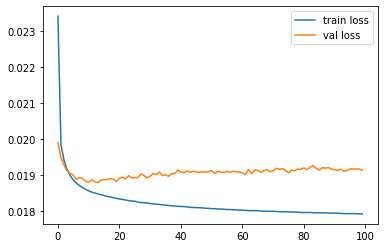

-----------------------------------------
 80
Epoch: 1
Train loss: 0.24002
Val loss: 0.15608
Epoch: 2
Train loss: 0.14943
Val loss: 0.14910
Epoch: 3
Train loss: 0.14423
Val loss: 0.14788
Epoch: 4
Train loss: 0.14185
Val loss: 0.14588
Epoch: 5
Train loss: 0.14048
Val loss: 0.14601
Epoch: 6
Train loss: 0.13960
Val loss: 0.14575
Epoch: 7
Train loss: 0.13891
Val loss: 0.14578
Epoch: 8
Train loss: 0.13833
Val loss: 0.14555
Epoch: 9
Train loss: 0.13790
Val loss: 0.14580
Epoch: 10
Train loss: 0.13754
Val loss: 0.14492
Epoch: 11
Train loss: 0.13724
Val loss: 0.14542
Epoch: 12
Train loss: 0.13698
Val loss: 0.14442
Epoch: 13
Train loss: 0.13673
Val loss: 0.14497
Epoch: 14
Train loss: 0.13651
Val loss: 0.14530
Epoch: 15
Train loss: 0.13632
Val loss: 0.14531
Epoch: 16
Train loss: 0.13616
Val loss: 0.14564
Epoch: 17
Train loss: 0.13598
Val loss: 0.14609
Epoch: 18
Train loss: 0.13587
Val loss: 0.14557
Epoch: 19
Train loss: 0.13573
Val loss: 0.14582
Epoch: 20
Train loss: 0.13558
Val loss: 0.14557
Epo

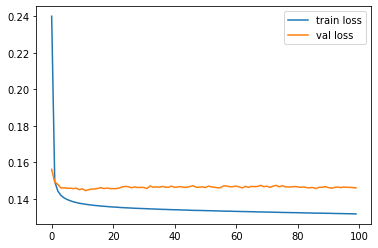

Epoch: 1
Train loss: 0.02565
Val loss: 0.02081
Epoch: 2
Train loss: 0.02027
Val loss: 0.02032
Epoch: 3
Train loss: 0.01985
Val loss: 0.02013
Epoch: 4
Train loss: 0.01962
Val loss: 0.01997
Epoch: 5
Train loss: 0.01947
Val loss: 0.01997
Epoch: 6
Train loss: 0.01936
Val loss: 0.01989
Epoch: 7
Train loss: 0.01926
Val loss: 0.01985
Epoch: 8
Train loss: 0.01918
Val loss: 0.01986
Epoch: 9
Train loss: 0.01910
Val loss: 0.01982
Epoch: 10
Train loss: 0.01900
Val loss: 0.01980
Epoch: 11
Train loss: 0.01892
Val loss: 0.01972
Epoch: 12
Train loss: 0.01884
Val loss: 0.01967
Epoch: 13
Train loss: 0.01878
Val loss: 0.01960
Epoch: 14
Train loss: 0.01872
Val loss: 0.01963
Epoch: 15
Train loss: 0.01867
Val loss: 0.01953
Epoch: 16
Train loss: 0.01863
Val loss: 0.01953
Epoch: 17
Train loss: 0.01859
Val loss: 0.01951
Epoch: 18
Train loss: 0.01856
Val loss: 0.01950
Epoch: 19
Train loss: 0.01853
Val loss: 0.01952
Epoch: 20
Train loss: 0.01850
Val loss: 0.01950
Epoch: 21
Train loss: 0.01847
Val loss: 0.01945
E

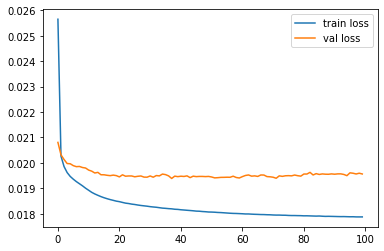

Epoch: 1
Train loss: 0.02576
Val loss: 0.02091
Epoch: 2
Train loss: 0.02023
Val loss: 0.02042
Epoch: 3
Train loss: 0.01982
Val loss: 0.02034
Epoch: 4
Train loss: 0.01960
Val loss: 0.02008
Epoch: 5
Train loss: 0.01945
Val loss: 0.02008
Epoch: 6
Train loss: 0.01934
Val loss: 0.02006
Epoch: 7
Train loss: 0.01924
Val loss: 0.01996
Epoch: 8
Train loss: 0.01915
Val loss: 0.02006
Epoch: 9
Train loss: 0.01906
Val loss: 0.01994
Epoch: 10
Train loss: 0.01897
Val loss: 0.01985
Epoch: 11
Train loss: 0.01888
Val loss: 0.01985
Epoch: 12
Train loss: 0.01881
Val loss: 0.01978
Epoch: 13
Train loss: 0.01874
Val loss: 0.01979
Epoch: 14
Train loss: 0.01868
Val loss: 0.01971
Epoch: 15
Train loss: 0.01863
Val loss: 0.01963
Epoch: 16
Train loss: 0.01859
Val loss: 0.01968
Epoch: 17
Train loss: 0.01855
Val loss: 0.01964
Epoch: 18
Train loss: 0.01851
Val loss: 0.01966
Epoch: 19
Train loss: 0.01848
Val loss: 0.01964
Epoch: 20
Train loss: 0.01845
Val loss: 0.01966
Epoch: 21
Train loss: 0.01842
Val loss: 0.01961
E

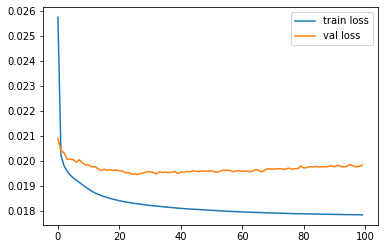

-----------------------------------------
 100
Epoch: 1
Train loss: 0.27972
Val loss: 0.16121
Epoch: 2
Train loss: 0.15417
Val loss: 0.15289
Epoch: 3
Train loss: 0.14796
Val loss: 0.15029
Epoch: 4
Train loss: 0.14502
Val loss: 0.14752
Epoch: 5
Train loss: 0.14338
Val loss: 0.14784
Epoch: 6
Train loss: 0.14232
Val loss: 0.14649
Epoch: 7
Train loss: 0.14158
Val loss: 0.14673
Epoch: 8
Train loss: 0.14099
Val loss: 0.14694
Epoch: 9
Train loss: 0.14054
Val loss: 0.14636
Epoch: 10
Train loss: 0.14008
Val loss: 0.14668
Epoch: 11
Train loss: 0.13971
Val loss: 0.14634
Epoch: 12
Train loss: 0.13944
Val loss: 0.14651
Epoch: 13
Train loss: 0.13915
Val loss: 0.14656
Epoch: 14
Train loss: 0.13889
Val loss: 0.14630
Epoch: 15
Train loss: 0.13868
Val loss: 0.14595
Epoch: 16
Train loss: 0.13842
Val loss: 0.14586
Epoch: 17
Train loss: 0.13824
Val loss: 0.14585
Epoch: 18
Train loss: 0.13803
Val loss: 0.14594
Epoch: 19
Train loss: 0.13789
Val loss: 0.14585
Epoch: 20
Train loss: 0.13772
Val loss: 0.14576
Ep

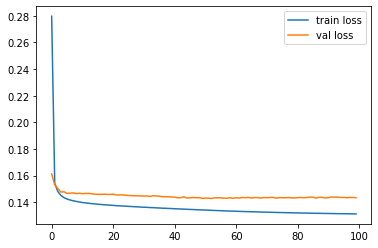

Epoch: 1
Train loss: 0.02757
Val loss: 0.02060
Epoch: 2
Train loss: 0.02025
Val loss: 0.02007
Epoch: 3
Train loss: 0.01988
Val loss: 0.01986
Epoch: 4
Train loss: 0.01972
Val loss: 0.01979
Epoch: 5
Train loss: 0.01957
Val loss: 0.01973
Epoch: 6
Train loss: 0.01941
Val loss: 0.01948
Epoch: 7
Train loss: 0.01921
Val loss: 0.01943
Epoch: 8
Train loss: 0.01900
Val loss: 0.01935
Epoch: 9
Train loss: 0.01883
Val loss: 0.01915
Epoch: 10
Train loss: 0.01870
Val loss: 0.01912
Epoch: 11
Train loss: 0.01863
Val loss: 0.01910
Epoch: 12
Train loss: 0.01858
Val loss: 0.01906
Epoch: 13
Train loss: 0.01854
Val loss: 0.01908
Epoch: 14
Train loss: 0.01850
Val loss: 0.01909
Epoch: 15
Train loss: 0.01847
Val loss: 0.01904
Epoch: 16
Train loss: 0.01844
Val loss: 0.01909
Epoch: 17
Train loss: 0.01842
Val loss: 0.01906
Epoch: 18
Train loss: 0.01839
Val loss: 0.01905
Epoch: 19
Train loss: 0.01837
Val loss: 0.01908
Epoch: 20
Train loss: 0.01835
Val loss: 0.01916
Epoch: 21
Train loss: 0.01834
Val loss: 0.01914
E

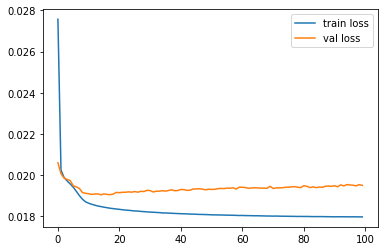

Epoch: 1
Train loss: 0.02735
Val loss: 0.02081
Epoch: 2
Train loss: 0.02034
Val loss: 0.02019
Epoch: 3
Train loss: 0.01995
Val loss: 0.02000
Epoch: 4
Train loss: 0.01978
Val loss: 0.01991
Epoch: 5
Train loss: 0.01964
Val loss: 0.01977
Epoch: 6
Train loss: 0.01947
Val loss: 0.01964
Epoch: 7
Train loss: 0.01927
Val loss: 0.01948
Epoch: 8
Train loss: 0.01908
Val loss: 0.01937
Epoch: 9
Train loss: 0.01891
Val loss: 0.01921
Epoch: 10
Train loss: 0.01876
Val loss: 0.01908
Epoch: 11
Train loss: 0.01866
Val loss: 0.01906
Epoch: 12
Train loss: 0.01858
Val loss: 0.01909
Epoch: 13
Train loss: 0.01854
Val loss: 0.01904
Epoch: 14
Train loss: 0.01850
Val loss: 0.01908
Epoch: 15
Train loss: 0.01847
Val loss: 0.01907
Epoch: 16
Train loss: 0.01845
Val loss: 0.01905
Epoch: 17
Train loss: 0.01842
Val loss: 0.01909
Epoch: 18
Train loss: 0.01839
Val loss: 0.01910
Epoch: 19
Train loss: 0.01838
Val loss: 0.01907
Epoch: 20
Train loss: 0.01835
Val loss: 0.01914
Epoch: 21
Train loss: 0.01833
Val loss: 0.01909
E

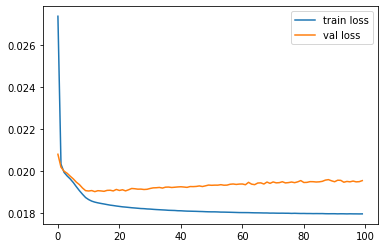

-----------------------------------------
 120
Epoch: 1
Train loss: 0.32930
Val loss: 0.16610
Epoch: 2
Train loss: 0.15880
Val loss: 0.15623
Epoch: 3
Train loss: 0.15140
Val loss: 0.15159
Epoch: 4
Train loss: 0.14790
Val loss: 0.14967
Epoch: 5
Train loss: 0.14587
Val loss: 0.14935
Epoch: 6
Train loss: 0.14450
Val loss: 0.14891
Epoch: 7
Train loss: 0.14353
Val loss: 0.14795
Epoch: 8
Train loss: 0.14274
Val loss: 0.14772
Epoch: 9
Train loss: 0.14219
Val loss: 0.14764
Epoch: 10
Train loss: 0.14164
Val loss: 0.14749
Epoch: 11
Train loss: 0.14123
Val loss: 0.14667
Epoch: 12
Train loss: 0.14084
Val loss: 0.14616
Epoch: 13
Train loss: 0.14046
Val loss: 0.14633
Epoch: 14
Train loss: 0.14010
Val loss: 0.14607
Epoch: 15
Train loss: 0.13978
Val loss: 0.14590
Epoch: 16
Train loss: 0.13952
Val loss: 0.14558
Epoch: 17
Train loss: 0.13927
Val loss: 0.14558
Epoch: 18
Train loss: 0.13902
Val loss: 0.14479
Epoch: 19
Train loss: 0.13878
Val loss: 0.14576
Epoch: 20
Train loss: 0.13854
Val loss: 0.14424
Ep

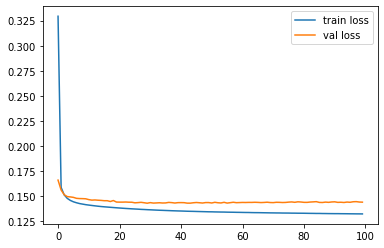

Epoch: 1
Train loss: 0.02887
Val loss: 0.02122
Epoch: 2
Train loss: 0.02067
Val loss: 0.02025
Epoch: 3
Train loss: 0.02002
Val loss: 0.01992
Epoch: 4
Train loss: 0.01973
Val loss: 0.01972
Epoch: 5
Train loss: 0.01950
Val loss: 0.01952
Epoch: 6
Train loss: 0.01928
Val loss: 0.01944
Epoch: 7
Train loss: 0.01909
Val loss: 0.01927
Epoch: 8
Train loss: 0.01894
Val loss: 0.01919
Epoch: 9
Train loss: 0.01883
Val loss: 0.01922
Epoch: 10
Train loss: 0.01876
Val loss: 0.01914
Epoch: 11
Train loss: 0.01871
Val loss: 0.01921
Epoch: 12
Train loss: 0.01867
Val loss: 0.01906
Epoch: 13
Train loss: 0.01863
Val loss: 0.01912
Epoch: 14
Train loss: 0.01860
Val loss: 0.01914
Epoch: 15
Train loss: 0.01857
Val loss: 0.01914
Epoch: 16
Train loss: 0.01854
Val loss: 0.01917
Epoch: 17
Train loss: 0.01852
Val loss: 0.01917
Epoch: 18
Train loss: 0.01850
Val loss: 0.01920
Epoch: 19
Train loss: 0.01848
Val loss: 0.01914
Epoch: 20
Train loss: 0.01846
Val loss: 0.01925
Epoch: 21
Train loss: 0.01844
Val loss: 0.01921
E

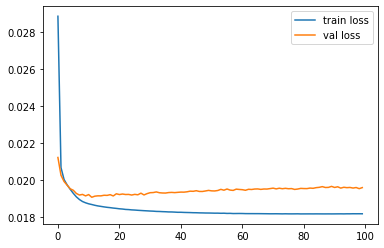

Epoch: 1
Train loss: 0.02894
Val loss: 0.02132
Epoch: 2
Train loss: 0.02083
Val loss: 0.02031
Epoch: 3
Train loss: 0.02011
Val loss: 0.01983
Epoch: 4
Train loss: 0.01970
Val loss: 0.01960
Epoch: 5
Train loss: 0.01942
Val loss: 0.01940
Epoch: 6
Train loss: 0.01921
Val loss: 0.01923
Epoch: 7
Train loss: 0.01904
Val loss: 0.01915
Epoch: 8
Train loss: 0.01893
Val loss: 0.01913
Epoch: 9
Train loss: 0.01884
Val loss: 0.01912
Epoch: 10
Train loss: 0.01877
Val loss: 0.01902
Epoch: 11
Train loss: 0.01872
Val loss: 0.01910
Epoch: 12
Train loss: 0.01868
Val loss: 0.01913
Epoch: 13
Train loss: 0.01865
Val loss: 0.01910
Epoch: 14
Train loss: 0.01862
Val loss: 0.01912
Epoch: 15
Train loss: 0.01859
Val loss: 0.01912
Epoch: 16
Train loss: 0.01856
Val loss: 0.01914
Epoch: 17
Train loss: 0.01854
Val loss: 0.01914
Epoch: 18
Train loss: 0.01852
Val loss: 0.01915
Epoch: 19
Train loss: 0.01850
Val loss: 0.01917
Epoch: 20
Train loss: 0.01848
Val loss: 0.01920
Save early stopping model at epoch 20
Epoch: 21
T

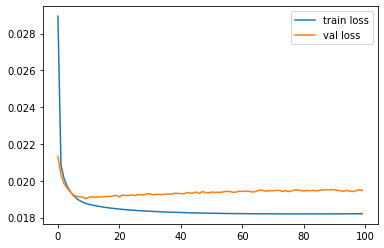

-----------------------------------------
 150
Epoch: 1
Train loss: 0.43670
Val loss: 0.19462
Epoch: 2
Train loss: 0.16797
Val loss: 0.16002
Epoch: 3
Train loss: 0.15680
Val loss: 0.15558
Epoch: 4
Train loss: 0.15288
Val loss: 0.15240
Epoch: 5
Train loss: 0.15003
Val loss: 0.15022
Epoch: 6
Train loss: 0.14799
Val loss: 0.14878
Epoch: 7
Train loss: 0.14647
Val loss: 0.14771
Epoch: 8
Train loss: 0.14528
Val loss: 0.14649
Epoch: 9
Train loss: 0.14421
Val loss: 0.14571
Epoch: 10
Train loss: 0.14325
Val loss: 0.14496
Epoch: 11
Train loss: 0.14250
Val loss: 0.14461
Epoch: 12
Train loss: 0.14178
Val loss: 0.14364
Epoch: 13
Train loss: 0.14109
Val loss: 0.14328
Epoch: 14
Train loss: 0.14048
Val loss: 0.14301
Epoch: 15
Train loss: 0.13993
Val loss: 0.14191
Epoch: 16
Train loss: 0.13940
Val loss: 0.14199
Epoch: 17
Train loss: 0.13892
Val loss: 0.14175
Epoch: 18
Train loss: 0.13847
Val loss: 0.14145
Epoch: 19
Train loss: 0.13805
Val loss: 0.14115
Epoch: 20
Train loss: 0.13768
Val loss: 0.14117
Ep

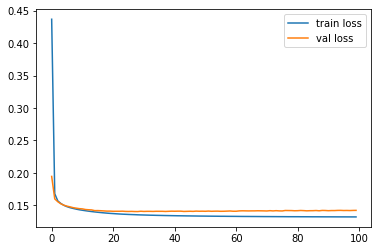

Epoch: 1
Train loss: 0.03054
Val loss: 0.02225
Epoch: 2
Train loss: 0.02155
Val loss: 0.02146
Epoch: 3
Train loss: 0.02115
Val loss: 0.02119
Epoch: 4
Train loss: 0.02091
Val loss: 0.02102
Epoch: 5
Train loss: 0.02072
Val loss: 0.02066
Epoch: 6
Train loss: 0.02056
Val loss: 0.02066
Epoch: 7
Train loss: 0.02043
Val loss: 0.02047
Epoch: 8
Train loss: 0.02031
Val loss: 0.02036
Epoch: 9
Train loss: 0.02017
Val loss: 0.02023
Epoch: 10
Train loss: 0.02003
Val loss: 0.02007
Epoch: 11
Train loss: 0.01989
Val loss: 0.01996
Epoch: 12
Train loss: 0.01974
Val loss: 0.01979
Epoch: 13
Train loss: 0.01959
Val loss: 0.01968
Epoch: 14
Train loss: 0.01948
Val loss: 0.01957
Epoch: 15
Train loss: 0.01939
Val loss: 0.01950
Epoch: 16
Train loss: 0.01933
Val loss: 0.01945
Epoch: 17
Train loss: 0.01928
Val loss: 0.01945
Epoch: 18
Train loss: 0.01925
Val loss: 0.01935
Epoch: 19
Train loss: 0.01921
Val loss: 0.01932
Epoch: 20
Train loss: 0.01918
Val loss: 0.01936
Epoch: 21
Train loss: 0.01916
Val loss: 0.01931
E

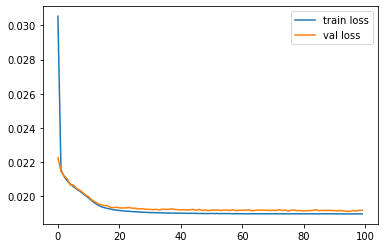

Epoch: 1
Train loss: 0.03050
Val loss: 0.02199
Epoch: 2
Train loss: 0.02152
Val loss: 0.02153
Epoch: 3
Train loss: 0.02116
Val loss: 0.02105
Epoch: 4
Train loss: 0.02092
Val loss: 0.02085
Epoch: 5
Train loss: 0.02074
Val loss: 0.02069
Epoch: 6
Train loss: 0.02061
Val loss: 0.02053
Epoch: 7
Train loss: 0.02050
Val loss: 0.02043
Epoch: 8
Train loss: 0.02041
Val loss: 0.02035
Epoch: 9
Train loss: 0.02032
Val loss: 0.02031
Epoch: 10
Train loss: 0.02026
Val loss: 0.02023
Epoch: 11
Train loss: 0.02020
Val loss: 0.02012
Epoch: 12
Train loss: 0.02014
Val loss: 0.02009
Epoch: 13
Train loss: 0.02009
Val loss: 0.02005
Epoch: 14
Train loss: 0.02004
Val loss: 0.01995
Epoch: 15
Train loss: 0.01998
Val loss: 0.01996
Epoch: 16
Train loss: 0.01993
Val loss: 0.01987
Epoch: 17
Train loss: 0.01986
Val loss: 0.01983
Epoch: 18
Train loss: 0.01980
Val loss: 0.01980
Epoch: 19
Train loss: 0.01973
Val loss: 0.01968
Epoch: 20
Train loss: 0.01966
Val loss: 0.01958
Epoch: 21
Train loss: 0.01958
Val loss: 0.01949
E

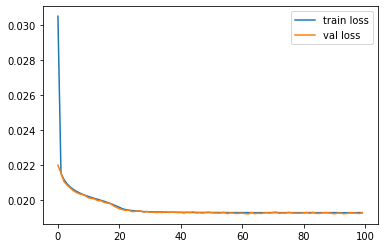

-----------------------------------------
 180
Epoch: 1
Train loss: 0.54813
Val loss: 0.31728
Epoch: 2
Train loss: 0.18005
Val loss: 0.16025
Epoch: 3
Train loss: 0.15760
Val loss: 0.15791
Epoch: 4
Train loss: 0.15396
Val loss: 0.15265
Epoch: 5
Train loss: 0.15091
Val loss: 0.15107
Epoch: 6
Train loss: 0.14892
Val loss: 0.14895
Epoch: 7
Train loss: 0.14768
Val loss: 0.14771
Epoch: 8
Train loss: 0.14689
Val loss: 0.14682
Epoch: 9
Train loss: 0.14627
Val loss: 0.14693
Epoch: 10
Train loss: 0.14581
Val loss: 0.14604
Epoch: 11
Train loss: 0.14534
Val loss: 0.14575
Epoch: 12
Train loss: 0.14483
Val loss: 0.14482
Epoch: 13
Train loss: 0.14439
Val loss: 0.14424
Epoch: 14
Train loss: 0.14399
Val loss: 0.14441
Epoch: 15
Train loss: 0.14362
Val loss: 0.14409
Epoch: 16
Train loss: 0.14332
Val loss: 0.14347
Epoch: 17
Train loss: 0.14302
Val loss: 0.14292
Epoch: 18
Train loss: 0.14276
Val loss: 0.14326
Epoch: 19
Train loss: 0.14257
Val loss: 0.14294
Epoch: 20
Train loss: 0.14235
Val loss: 0.14278
Ep

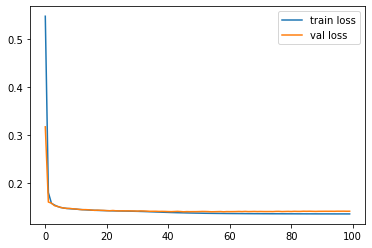

Epoch: 1
Train loss: 0.03197
Val loss: 0.02238
Epoch: 2
Train loss: 0.02185
Val loss: 0.02155
Epoch: 3
Train loss: 0.02144
Val loss: 0.02116
Epoch: 4
Train loss: 0.02121
Val loss: 0.02107
Epoch: 5
Train loss: 0.02104
Val loss: 0.02083
Epoch: 6
Train loss: 0.02091
Val loss: 0.02071
Epoch: 7
Train loss: 0.02081
Val loss: 0.02074
Epoch: 8
Train loss: 0.02074
Val loss: 0.02062
Epoch: 9
Train loss: 0.02067
Val loss: 0.02044
Epoch: 10
Train loss: 0.02063
Val loss: 0.02046
Epoch: 11
Train loss: 0.02060
Val loss: 0.02043
Epoch: 12
Train loss: 0.02058
Val loss: 0.02040
Epoch: 13
Train loss: 0.02054
Val loss: 0.02041
Epoch: 14
Train loss: 0.02052
Val loss: 0.02035
Epoch: 15
Train loss: 0.02049
Val loss: 0.02031
Epoch: 16
Train loss: 0.02047
Val loss: 0.02027
Epoch: 17
Train loss: 0.02045
Val loss: 0.02024
Epoch: 18
Train loss: 0.02042
Val loss: 0.02027
Epoch: 19
Train loss: 0.02041
Val loss: 0.02023
Epoch: 20
Train loss: 0.02039
Val loss: 0.02021
Epoch: 21
Train loss: 0.02036
Val loss: 0.02018
E

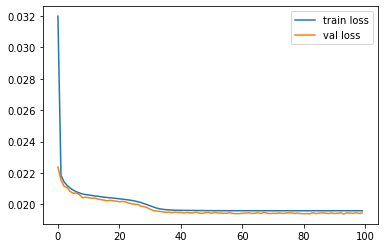

Epoch: 1
Train loss: 0.03197
Val loss: 0.02257
Epoch: 2
Train loss: 0.02185
Val loss: 0.02195
Epoch: 3
Train loss: 0.02146
Val loss: 0.02140
Epoch: 4
Train loss: 0.02122
Val loss: 0.02122
Epoch: 5
Train loss: 0.02106
Val loss: 0.02107
Epoch: 6
Train loss: 0.02093
Val loss: 0.02102
Epoch: 7
Train loss: 0.02083
Val loss: 0.02082
Epoch: 8
Train loss: 0.02074
Val loss: 0.02081
Epoch: 9
Train loss: 0.02068
Val loss: 0.02077
Epoch: 10
Train loss: 0.02063
Val loss: 0.02066
Epoch: 11
Train loss: 0.02058
Val loss: 0.02066
Epoch: 12
Train loss: 0.02055
Val loss: 0.02054
Epoch: 13
Train loss: 0.02051
Val loss: 0.02054
Epoch: 14
Train loss: 0.02048
Val loss: 0.02050
Epoch: 15
Train loss: 0.02046
Val loss: 0.02051
Epoch: 16
Train loss: 0.02044
Val loss: 0.02044
Epoch: 17
Train loss: 0.02042
Val loss: 0.02035
Epoch: 18
Train loss: 0.02039
Val loss: 0.02044
Epoch: 19
Train loss: 0.02037
Val loss: 0.02034
Epoch: 20
Train loss: 0.02034
Val loss: 0.02037
Epoch: 21
Train loss: 0.02031
Val loss: 0.02030
E

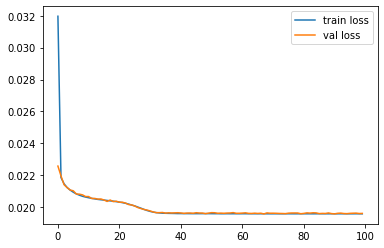

-----------------------------------------
 200
Epoch: 1
Train loss: 0.58876
Val loss: 0.51322
Epoch: 2
Train loss: 0.24836
Val loss: 0.16423
Epoch: 3
Train loss: 0.16012
Val loss: 0.16147
Epoch: 4
Train loss: 0.15748
Val loss: 0.15808
Epoch: 5
Train loss: 0.15457
Val loss: 0.15536
Epoch: 6
Train loss: 0.15211
Val loss: 0.15307
Epoch: 7
Train loss: 0.15025
Val loss: 0.15103
Epoch: 8
Train loss: 0.14896
Val loss: 0.15053
Epoch: 9
Train loss: 0.14815
Val loss: 0.14934
Epoch: 10
Train loss: 0.14761
Val loss: 0.14935
Epoch: 11
Train loss: 0.14718
Val loss: 0.14810
Epoch: 12
Train loss: 0.14678
Val loss: 0.14793
Epoch: 13
Train loss: 0.14643
Val loss: 0.14671
Epoch: 14
Train loss: 0.14601
Val loss: 0.14715
Epoch: 15
Train loss: 0.14565
Val loss: 0.14673
Epoch: 16
Train loss: 0.14528
Val loss: 0.14581
Epoch: 17
Train loss: 0.14496
Val loss: 0.14639
Epoch: 18
Train loss: 0.14472
Val loss: 0.14576
Epoch: 19
Train loss: 0.14442
Val loss: 0.14519
Epoch: 20
Train loss: 0.14421
Val loss: 0.14502
Ep

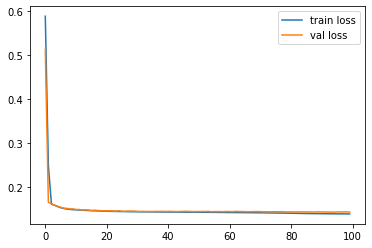

Epoch: 1
Train loss: 0.03292
Val loss: 0.02251
Epoch: 2
Train loss: 0.02201
Val loss: 0.02193
Epoch: 3
Train loss: 0.02159
Val loss: 0.02152
Epoch: 4
Train loss: 0.02136
Val loss: 0.02133
Epoch: 5
Train loss: 0.02119
Val loss: 0.02121
Epoch: 6
Train loss: 0.02107
Val loss: 0.02124
Epoch: 7
Train loss: 0.02098
Val loss: 0.02098
Epoch: 8
Train loss: 0.02088
Val loss: 0.02085
Epoch: 9
Train loss: 0.02082
Val loss: 0.02081
Epoch: 10
Train loss: 0.02077
Val loss: 0.02073
Epoch: 11
Train loss: 0.02073
Val loss: 0.02075
Epoch: 12
Train loss: 0.02071
Val loss: 0.02066
Epoch: 13
Train loss: 0.02069
Val loss: 0.02075
Epoch: 14
Train loss: 0.02067
Val loss: 0.02070
Epoch: 15
Train loss: 0.02064
Val loss: 0.02066
Epoch: 16
Train loss: 0.02063
Val loss: 0.02064
Epoch: 17
Train loss: 0.02061
Val loss: 0.02062
Epoch: 18
Train loss: 0.02060
Val loss: 0.02055
Epoch: 19
Train loss: 0.02058
Val loss: 0.02056
Epoch: 20
Train loss: 0.02057
Val loss: 0.02057
Epoch: 21
Train loss: 0.02055
Val loss: 0.02054
E

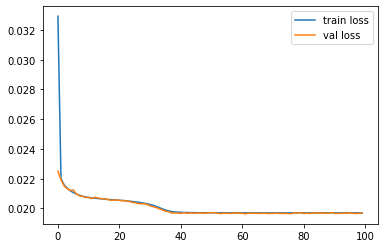

Epoch: 1
Train loss: 0.03294
Val loss: 0.02272
Epoch: 2
Train loss: 0.02204
Val loss: 0.02211
Epoch: 3
Train loss: 0.02161
Val loss: 0.02170
Epoch: 4
Train loss: 0.02136
Val loss: 0.02164
Epoch: 5
Train loss: 0.02119
Val loss: 0.02131
Epoch: 6
Train loss: 0.02107
Val loss: 0.02120
Epoch: 7
Train loss: 0.02095
Val loss: 0.02107
Epoch: 8
Train loss: 0.02088
Val loss: 0.02093
Epoch: 9
Train loss: 0.02082
Val loss: 0.02093
Epoch: 10
Train loss: 0.02077
Val loss: 0.02088
Epoch: 11
Train loss: 0.02073
Val loss: 0.02081
Epoch: 12
Train loss: 0.02071
Val loss: 0.02073
Epoch: 13
Train loss: 0.02069
Val loss: 0.02077
Epoch: 14
Train loss: 0.02068
Val loss: 0.02074
Epoch: 15
Train loss: 0.02067
Val loss: 0.02066
Epoch: 16
Train loss: 0.02065
Val loss: 0.02069
Epoch: 17
Train loss: 0.02064
Val loss: 0.02068
Epoch: 18
Train loss: 0.02063
Val loss: 0.02067
Epoch: 19
Train loss: 0.02062
Val loss: 0.02064
Epoch: 20
Train loss: 0.02061
Val loss: 0.02064
Epoch: 21
Train loss: 0.02060
Val loss: 0.02065
E

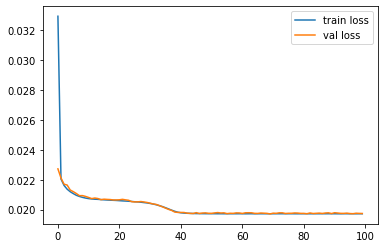

In [13]:
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
max_epoch = 100

for p in [10,20,50,80,100,120,150,180,200]:
    print('-----------------------------------------\n',p)
    generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/normal_mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/normal_mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/normal_q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/normal_q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/normal_q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/normal_q975_p'+str(p)+'_es.pt')

In [15]:
md_mean = MLP_light(20, 20).to(device)
md_q025 = MLP_light(20, 20).to(device)
md_q975 = MLP_light(20, 20).to(device)
md_mean.load_state_dict(torch.load('./model/normal_mean_p20_es.pt'))
md_q025.load_state_dict(torch.load('./model/normal_q025_p20_es.pt'))
md_q975.load_state_dict(torch.load('./model/normal_q975_p20_es.pt'))

<All keys matched successfully>

In [72]:
def computeNormalStats(sigma, sigma0, sigma1, Y):
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

In [14]:
p = 20
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

rng.seed(0)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(10000)

mean = Y_train.mean(0)
std = Y_train.std(0)
Y_train = (Y_train - mean) / std 
Y_val = (Y_val - mean) / std 
train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

Y_test_normalized = (Y_test - mean) / std 

In [73]:
pred_mean = predict(md_mean, Y_test_normalized)
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)
true_mean = np.zeros_like(pred_mean)
true_q025 = np.zeros_like(pred_q025)
true_q975 = np.zeros_like(pred_q975)
for i in range(pred_mean.shape[0]):
    for j in range(pred_mean.shape[1]):
        true_mean[i,j], true_q025[i, j], true_q975[i, j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i, j])

KeyboardInterrupt: 

In [74]:
np.mean((true_mean[:9000]-pred_mean[:9000])**2)

0.008620447

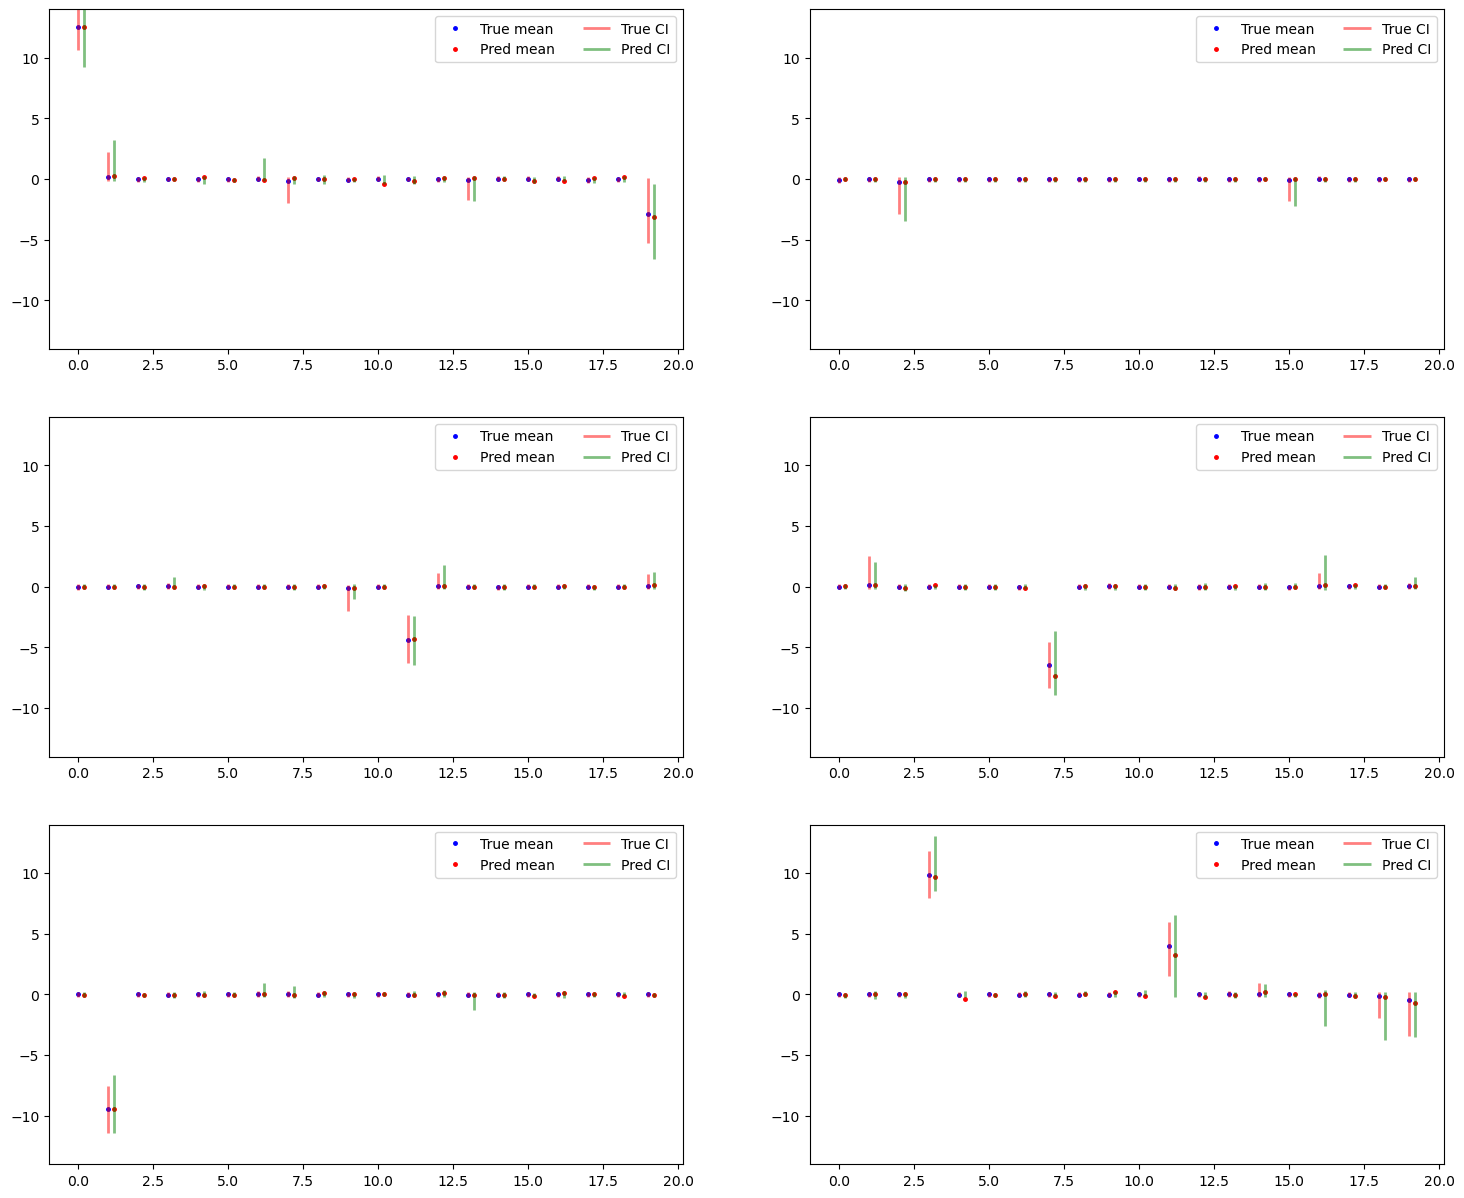

In [90]:
subset = np.where(np.abs(beta_test[:9000])>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-14,14)
plt.show()

-----------------------------------------
 10
Epoch: 1
Train loss: 0.15324
Val loss: 0.14340
Epoch: 2
Train loss: 0.13566
Val loss: 0.13554
Epoch: 3
Train loss: 0.13242
Val loss: 0.13088
Epoch: 4
Train loss: 0.13095
Val loss: 0.13056
Epoch: 5
Train loss: 0.13013
Val loss: 0.12942
Epoch: 6
Train loss: 0.12940
Val loss: 0.13045
Epoch: 7
Train loss: 0.12892
Val loss: 0.12977
Epoch: 8
Train loss: 0.12857
Val loss: 0.12976
Epoch: 9
Train loss: 0.12824
Val loss: 0.12863
Epoch: 10
Train loss: 0.12797
Val loss: 0.13051
Epoch: 11
Train loss: 0.12783
Val loss: 0.12791
Epoch: 12
Train loss: 0.12758
Val loss: 0.12848
Epoch: 13
Train loss: 0.12746
Val loss: 0.12845
Epoch: 14
Train loss: 0.12732
Val loss: 0.12825
Epoch: 15
Train loss: 0.12713
Val loss: 0.12808
Epoch: 16
Train loss: 0.12693
Val loss: 0.12835
Epoch: 17
Train loss: 0.12684
Val loss: 0.12802
Epoch: 18
Train loss: 0.12665
Val loss: 0.12853
Epoch: 19
Train loss: 0.12664
Val loss: 0.13017
Epoch: 20
Train loss: 0.12646
Val loss: 0.12796
Epo

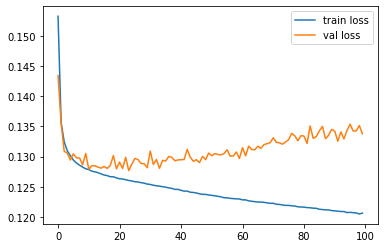

Epoch: 1
Train loss: 0.02040
Val loss: 0.01912
Epoch: 2
Train loss: 0.01879
Val loss: 0.01826
Epoch: 3
Train loss: 0.01848
Val loss: 0.01812
Epoch: 4
Train loss: 0.01838
Val loss: 0.01813
Epoch: 5
Train loss: 0.01832
Val loss: 0.01809
Epoch: 6
Train loss: 0.01826
Val loss: 0.01811
Epoch: 7
Train loss: 0.01822
Val loss: 0.01786
Epoch: 8
Train loss: 0.01819
Val loss: 0.01825
Epoch: 9
Train loss: 0.01816
Val loss: 0.01796
Epoch: 10
Train loss: 0.01815
Val loss: 0.01798
Epoch: 11
Train loss: 0.01812
Val loss: 0.01793
Epoch: 12
Train loss: 0.01810
Val loss: 0.01790
Epoch: 13
Train loss: 0.01810
Val loss: 0.01789
Epoch: 14
Train loss: 0.01808
Val loss: 0.01783
Epoch: 15
Train loss: 0.01806
Val loss: 0.01792
Epoch: 16
Train loss: 0.01805
Val loss: 0.01798
Epoch: 17
Train loss: 0.01803
Val loss: 0.01789
Epoch: 18
Train loss: 0.01802
Val loss: 0.01790
Epoch: 19
Train loss: 0.01803
Val loss: 0.01785
Epoch: 20
Train loss: 0.01801
Val loss: 0.01786
Epoch: 21
Train loss: 0.01800
Val loss: 0.01793
E

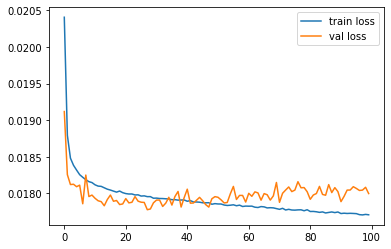

Epoch: 1
Train loss: 0.02038
Val loss: 0.01939
Epoch: 2
Train loss: 0.01869
Val loss: 0.01858
Epoch: 3
Train loss: 0.01846
Val loss: 0.01841
Epoch: 4
Train loss: 0.01836
Val loss: 0.01822
Epoch: 5
Train loss: 0.01829
Val loss: 0.01832
Epoch: 6
Train loss: 0.01825
Val loss: 0.01816
Epoch: 7
Train loss: 0.01821
Val loss: 0.01814
Epoch: 8
Train loss: 0.01818
Val loss: 0.01808
Epoch: 9
Train loss: 0.01813
Val loss: 0.01785
Epoch: 10
Train loss: 0.01804
Val loss: 0.01785
Epoch: 11
Train loss: 0.01801
Val loss: 0.01797
Epoch: 12
Train loss: 0.01800
Val loss: 0.01789
Epoch: 13
Train loss: 0.01797
Val loss: 0.01804
Epoch: 14
Train loss: 0.01796
Val loss: 0.01801
Epoch: 15
Train loss: 0.01795
Val loss: 0.01786
Epoch: 16
Train loss: 0.01794
Val loss: 0.01798
Epoch: 17
Train loss: 0.01793
Val loss: 0.01795
Epoch: 18
Train loss: 0.01793
Val loss: 0.01796
Epoch: 19
Train loss: 0.01790
Val loss: 0.01791
Save early stopping model at epoch 19
Epoch: 20
Train loss: 0.01791
Val loss: 0.01787
Epoch: 21
T

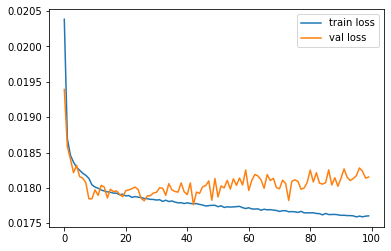

-----------------------------------------
 20
Epoch: 1
Train loss: 0.15962
Val loss: 0.14516
Epoch: 2
Train loss: 0.13938
Val loss: 0.13937
Epoch: 3
Train loss: 0.13571
Val loss: 0.13898
Epoch: 4
Train loss: 0.13381
Val loss: 0.13775
Epoch: 5
Train loss: 0.13264
Val loss: 0.13778
Epoch: 6
Train loss: 0.13163
Val loss: 0.13766
Epoch: 7
Train loss: 0.13100
Val loss: 0.13793
Epoch: 8
Train loss: 0.13051
Val loss: 0.13698
Epoch: 9
Train loss: 0.13004
Val loss: 0.13685
Epoch: 10
Train loss: 0.12959
Val loss: 0.13725
Epoch: 11
Train loss: 0.12921
Val loss: 0.13539
Epoch: 12
Train loss: 0.12898
Val loss: 0.13692
Epoch: 13
Train loss: 0.12867
Val loss: 0.13701
Epoch: 14
Train loss: 0.12834
Val loss: 0.13649
Epoch: 15
Train loss: 0.12810
Val loss: 0.13710
Epoch: 16
Train loss: 0.12791
Val loss: 0.13713
Epoch: 17
Train loss: 0.12751
Val loss: 0.13744
Epoch: 18
Train loss: 0.12734
Val loss: 0.13870
Epoch: 19
Train loss: 0.12706
Val loss: 0.13865
Epoch: 20
Train loss: 0.12683
Val loss: 0.13794
Epo

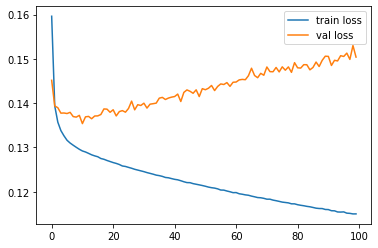

Epoch: 1
Train loss: 0.02161
Val loss: 0.01958
Epoch: 2
Train loss: 0.01931
Val loss: 0.01903
Epoch: 3
Train loss: 0.01882
Val loss: 0.01876
Epoch: 4
Train loss: 0.01864
Val loss: 0.01879
Epoch: 5
Train loss: 0.01854
Val loss: 0.01867
Epoch: 6
Train loss: 0.01847
Val loss: 0.01860
Epoch: 7
Train loss: 0.01841
Val loss: 0.01861
Epoch: 8
Train loss: 0.01837
Val loss: 0.01856
Epoch: 9
Train loss: 0.01833
Val loss: 0.01858
Epoch: 10
Train loss: 0.01831
Val loss: 0.01864
Epoch: 11
Train loss: 0.01828
Val loss: 0.01857
Epoch: 12
Train loss: 0.01826
Val loss: 0.01862
Epoch: 13
Train loss: 0.01824
Val loss: 0.01848
Epoch: 14
Train loss: 0.01822
Val loss: 0.01845
Epoch: 15
Train loss: 0.01819
Val loss: 0.01863
Epoch: 16
Train loss: 0.01818
Val loss: 0.01864
Epoch: 17
Train loss: 0.01817
Val loss: 0.01871
Epoch: 18
Train loss: 0.01815
Val loss: 0.01843
Epoch: 19
Train loss: 0.01814
Val loss: 0.01847
Epoch: 20
Train loss: 0.01813
Val loss: 0.01859
Epoch: 21
Train loss: 0.01811
Val loss: 0.01857
E

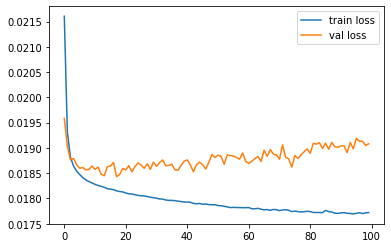

Epoch: 1
Train loss: 0.02163
Val loss: 0.01954
Epoch: 2
Train loss: 0.01924
Val loss: 0.01886
Epoch: 3
Train loss: 0.01883
Val loss: 0.01878
Epoch: 4
Train loss: 0.01868
Val loss: 0.01866
Epoch: 5
Train loss: 0.01859
Val loss: 0.01885
Epoch: 6
Train loss: 0.01852
Val loss: 0.01864
Epoch: 7
Train loss: 0.01847
Val loss: 0.01856
Epoch: 8
Train loss: 0.01843
Val loss: 0.01869
Epoch: 9
Train loss: 0.01839
Val loss: 0.01866
Epoch: 10
Train loss: 0.01835
Val loss: 0.01863
Epoch: 11
Train loss: 0.01833
Val loss: 0.01862
Epoch: 12
Train loss: 0.01830
Val loss: 0.01863
Epoch: 13
Train loss: 0.01829
Val loss: 0.01851
Epoch: 14
Train loss: 0.01826
Val loss: 0.01846
Epoch: 15
Train loss: 0.01824
Val loss: 0.01870
Epoch: 16
Train loss: 0.01823
Val loss: 0.01861
Epoch: 17
Train loss: 0.01822
Val loss: 0.01854
Epoch: 18
Train loss: 0.01819
Val loss: 0.01843
Epoch: 19
Train loss: 0.01818
Val loss: 0.01855
Epoch: 20
Train loss: 0.01817
Val loss: 0.01851
Epoch: 21
Train loss: 0.01815
Val loss: 0.01849
E

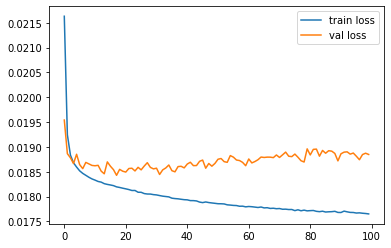

-----------------------------------------
 50
Epoch: 1
Train loss: 0.17996
Val loss: 0.15530
Epoch: 2
Train loss: 0.15138
Val loss: 0.15185
Epoch: 3
Train loss: 0.14779
Val loss: 0.15112
Epoch: 4
Train loss: 0.14460
Val loss: 0.14871
Epoch: 5
Train loss: 0.14156
Val loss: 0.14658
Epoch: 6
Train loss: 0.13959
Val loss: 0.14606
Epoch: 7
Train loss: 0.13819
Val loss: 0.14412
Epoch: 8
Train loss: 0.13679
Val loss: 0.14398
Epoch: 9
Train loss: 0.13576
Val loss: 0.14295
Epoch: 10
Train loss: 0.13490
Val loss: 0.14406
Epoch: 11
Train loss: 0.13421
Val loss: 0.14499
Epoch: 12
Train loss: 0.13360
Val loss: 0.14394
Epoch: 13
Train loss: 0.13297
Val loss: 0.14398
Epoch: 14
Train loss: 0.13251
Val loss: 0.14543
Epoch: 15
Train loss: 0.13204
Val loss: 0.14542
Epoch: 16
Train loss: 0.13164
Val loss: 0.14568
Epoch: 17
Train loss: 0.13114
Val loss: 0.14610
Epoch: 18
Train loss: 0.13080
Val loss: 0.14653
Epoch: 19
Train loss: 0.13047
Val loss: 0.14591
Save early stopping model at epoch 19
Epoch: 20
Tra

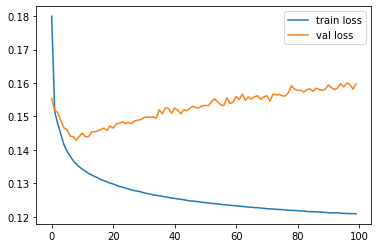

Epoch: 1
Train loss: 0.02465
Val loss: 0.02158
Epoch: 2
Train loss: 0.02039
Val loss: 0.02032
Epoch: 3
Train loss: 0.01951
Val loss: 0.01996
Epoch: 4
Train loss: 0.01920
Val loss: 0.01966
Epoch: 5
Train loss: 0.01906
Val loss: 0.01960
Epoch: 6
Train loss: 0.01895
Val loss: 0.01971
Epoch: 7
Train loss: 0.01886
Val loss: 0.01961
Epoch: 8
Train loss: 0.01876
Val loss: 0.01952
Epoch: 9
Train loss: 0.01873
Val loss: 0.01948
Epoch: 10
Train loss: 0.01867
Val loss: 0.01951
Epoch: 11
Train loss: 0.01863
Val loss: 0.01946
Epoch: 12
Train loss: 0.01859
Val loss: 0.01947
Epoch: 13
Train loss: 0.01858
Val loss: 0.01944
Epoch: 14
Train loss: 0.01856
Val loss: 0.01956
Epoch: 15
Train loss: 0.01853
Val loss: 0.01934
Epoch: 16
Train loss: 0.01851
Val loss: 0.01944
Epoch: 17
Train loss: 0.01849
Val loss: 0.01952
Epoch: 18
Train loss: 0.01848
Val loss: 0.01954
Epoch: 19
Train loss: 0.01846
Val loss: 0.01949
Epoch: 20
Train loss: 0.01846
Val loss: 0.01951
Epoch: 21
Train loss: 0.01845
Val loss: 0.01948
E

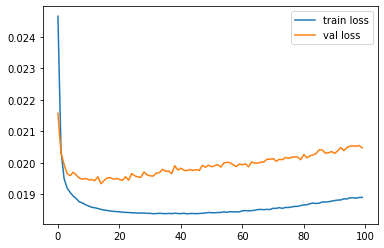

Epoch: 1
Train loss: 0.02466
Val loss: 0.02115
Epoch: 2
Train loss: 0.02080
Val loss: 0.02019
Epoch: 3
Train loss: 0.01988
Val loss: 0.01938
Epoch: 4
Train loss: 0.01931
Val loss: 0.01924
Epoch: 5
Train loss: 0.01910
Val loss: 0.01925
Epoch: 6
Train loss: 0.01899
Val loss: 0.01916
Epoch: 7
Train loss: 0.01890
Val loss: 0.01905
Epoch: 8
Train loss: 0.01882
Val loss: 0.01906
Epoch: 9
Train loss: 0.01877
Val loss: 0.01903
Epoch: 10
Train loss: 0.01873
Val loss: 0.01910
Epoch: 11
Train loss: 0.01868
Val loss: 0.01902
Epoch: 12
Train loss: 0.01866
Val loss: 0.01906
Epoch: 13
Train loss: 0.01864
Val loss: 0.01910
Epoch: 14
Train loss: 0.01860
Val loss: 0.01899
Epoch: 15
Train loss: 0.01859
Val loss: 0.01909
Epoch: 16
Train loss: 0.01857
Val loss: 0.01921
Epoch: 17
Train loss: 0.01855
Val loss: 0.01914
Epoch: 18
Train loss: 0.01854
Val loss: 0.01914
Epoch: 19
Train loss: 0.01853
Val loss: 0.01912
Epoch: 20
Train loss: 0.01852
Val loss: 0.01918
Epoch: 21
Train loss: 0.01850
Val loss: 0.01914
E

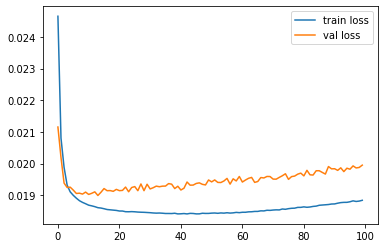

-----------------------------------------
 80
Epoch: 1
Train loss: 0.20753
Val loss: 0.17139
Epoch: 2
Train loss: 0.16045
Val loss: 0.16596
Epoch: 3
Train loss: 0.15569
Val loss: 0.16078
Epoch: 4
Train loss: 0.15201
Val loss: 0.15804
Epoch: 5
Train loss: 0.14945
Val loss: 0.15586
Epoch: 6
Train loss: 0.14766
Val loss: 0.15576
Epoch: 7
Train loss: 0.14643
Val loss: 0.15726
Epoch: 8
Train loss: 0.14529
Val loss: 0.15487
Epoch: 9
Train loss: 0.14451
Val loss: 0.15415
Epoch: 10
Train loss: 0.14380
Val loss: 0.15404
Epoch: 11
Train loss: 0.14317
Val loss: 0.15254
Epoch: 12
Train loss: 0.14281
Val loss: 0.15380
Epoch: 13
Train loss: 0.14235
Val loss: 0.15404
Epoch: 14
Train loss: 0.14197
Val loss: 0.15325
Epoch: 15
Train loss: 0.14156
Val loss: 0.15315
Epoch: 16
Train loss: 0.14121
Val loss: 0.15363
Epoch: 17
Train loss: 0.14086
Val loss: 0.15333
Epoch: 18
Train loss: 0.14058
Val loss: 0.15268
Epoch: 19
Train loss: 0.14028
Val loss: 0.15317
Epoch: 20
Train loss: 0.14005
Val loss: 0.15349
Epo

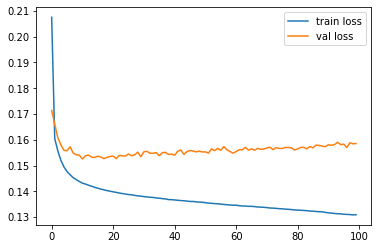

Epoch: 1
Train loss: 0.02831
Val loss: 0.02291
Epoch: 2
Train loss: 0.02151
Val loss: 0.02142
Epoch: 3
Train loss: 0.02028
Val loss: 0.02062
Epoch: 4
Train loss: 0.01982
Val loss: 0.02042
Epoch: 5
Train loss: 0.01959
Val loss: 0.02025
Epoch: 6
Train loss: 0.01944
Val loss: 0.02025
Epoch: 7
Train loss: 0.01936
Val loss: 0.02026
Epoch: 8
Train loss: 0.01929
Val loss: 0.02025
Epoch: 9
Train loss: 0.01922
Val loss: 0.02021
Epoch: 10
Train loss: 0.01920
Val loss: 0.02012
Epoch: 11
Train loss: 0.01917
Val loss: 0.02008
Epoch: 12
Train loss: 0.01914
Val loss: 0.02029
Epoch: 13
Train loss: 0.01913
Val loss: 0.02026
Epoch: 14
Train loss: 0.01911
Val loss: 0.02026
Epoch: 15
Train loss: 0.01910
Val loss: 0.02030
Epoch: 16
Train loss: 0.01908
Val loss: 0.02037
Epoch: 17
Train loss: 0.01908
Val loss: 0.02045
Epoch: 18
Train loss: 0.01907
Val loss: 0.02022
Epoch: 19
Train loss: 0.01906
Val loss: 0.02030
Epoch: 20
Train loss: 0.01906
Val loss: 0.02046
Epoch: 21
Train loss: 0.01906
Val loss: 0.02040
S

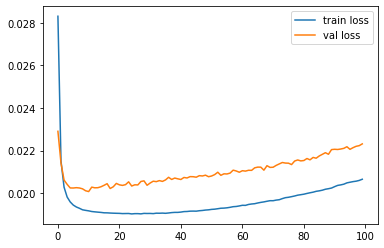

Epoch: 1
Train loss: 0.02807
Val loss: 0.02274
Epoch: 2
Train loss: 0.02158
Val loss: 0.02160
Epoch: 3
Train loss: 0.02048
Val loss: 0.02080
Epoch: 4
Train loss: 0.01983
Val loss: 0.02047
Epoch: 5
Train loss: 0.01959
Val loss: 0.02048
Epoch: 6
Train loss: 0.01947
Val loss: 0.02039
Epoch: 7
Train loss: 0.01938
Val loss: 0.02032
Epoch: 8
Train loss: 0.01932
Val loss: 0.02045
Epoch: 9
Train loss: 0.01927
Val loss: 0.02026
Epoch: 10
Train loss: 0.01923
Val loss: 0.02032
Epoch: 11
Train loss: 0.01922
Val loss: 0.02029
Epoch: 12
Train loss: 0.01919
Val loss: 0.02039
Epoch: 13
Train loss: 0.01918
Val loss: 0.02031
Epoch: 14
Train loss: 0.01917
Val loss: 0.02034
Epoch: 15
Train loss: 0.01915
Val loss: 0.02029
Epoch: 16
Train loss: 0.01914
Val loss: 0.02039
Epoch: 17
Train loss: 0.01915
Val loss: 0.02027
Epoch: 18
Train loss: 0.01912
Val loss: 0.02047
Epoch: 19
Train loss: 0.01910
Val loss: 0.02051
Save early stopping model at epoch 19
Epoch: 20
Train loss: 0.01910
Val loss: 0.02045
Epoch: 21
T

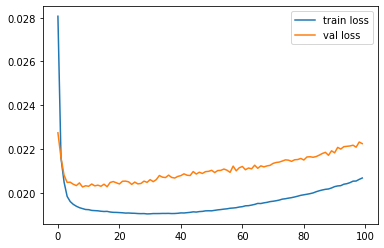

-----------------------------------------
 100
Epoch: 1
Train loss: 0.23247
Val loss: 0.18087
Epoch: 2
Train loss: 0.16634
Val loss: 0.17327
Epoch: 3
Train loss: 0.16101
Val loss: 0.16571
Epoch: 4
Train loss: 0.15726
Val loss: 0.16264
Epoch: 5
Train loss: 0.15450
Val loss: 0.16053
Epoch: 6
Train loss: 0.15248
Val loss: 0.15937
Epoch: 7
Train loss: 0.15084
Val loss: 0.15880
Epoch: 8
Train loss: 0.14963
Val loss: 0.15922
Epoch: 9
Train loss: 0.14869
Val loss: 0.15625
Epoch: 10
Train loss: 0.14782
Val loss: 0.15683
Epoch: 11
Train loss: 0.14715
Val loss: 0.15551
Epoch: 12
Train loss: 0.14667
Val loss: 0.15438
Epoch: 13
Train loss: 0.14608
Val loss: 0.15434
Epoch: 14
Train loss: 0.14563
Val loss: 0.15600
Epoch: 15
Train loss: 0.14516
Val loss: 0.15476
Epoch: 16
Train loss: 0.14484
Val loss: 0.15580
Epoch: 17
Train loss: 0.14445
Val loss: 0.15411
Epoch: 18
Train loss: 0.14412
Val loss: 0.15349
Epoch: 19
Train loss: 0.14388
Val loss: 0.15532
Epoch: 20
Train loss: 0.14360
Val loss: 0.15342
Ep

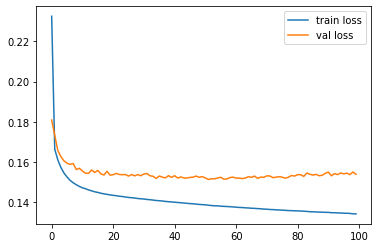

Epoch: 1
Train loss: 0.03056
Val loss: 0.02332
Epoch: 2
Train loss: 0.02202
Val loss: 0.02184
Epoch: 3
Train loss: 0.02084
Val loss: 0.02096
Epoch: 4
Train loss: 0.02018
Val loss: 0.02063
Epoch: 5
Train loss: 0.01994
Val loss: 0.02058
Epoch: 6
Train loss: 0.01980
Val loss: 0.02054
Epoch: 7
Train loss: 0.01972
Val loss: 0.02054
Epoch: 8
Train loss: 0.01966
Val loss: 0.02060
Epoch: 9
Train loss: 0.01962
Val loss: 0.02051
Epoch: 10
Train loss: 0.01958
Val loss: 0.02038
Epoch: 11
Train loss: 0.01955
Val loss: 0.02039
Epoch: 12
Train loss: 0.01953
Val loss: 0.02038
Epoch: 13
Train loss: 0.01951
Val loss: 0.02049
Epoch: 14
Train loss: 0.01950
Val loss: 0.02035
Epoch: 15
Train loss: 0.01949
Val loss: 0.02052
Epoch: 16
Train loss: 0.01948
Val loss: 0.02050
Epoch: 17
Train loss: 0.01948
Val loss: 0.02053
Epoch: 18
Train loss: 0.01946
Val loss: 0.02057
Epoch: 19
Train loss: 0.01945
Val loss: 0.02057
Epoch: 20
Train loss: 0.01945
Val loss: 0.02065
Epoch: 21
Train loss: 0.01945
Val loss: 0.02057
E

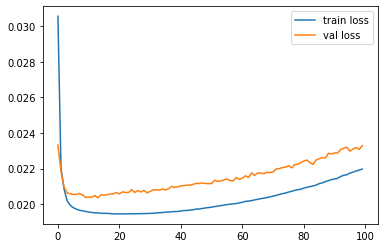

Epoch: 1
Train loss: 0.03030
Val loss: 0.02300
Epoch: 2
Train loss: 0.02196
Val loss: 0.02166
Epoch: 3
Train loss: 0.02089
Val loss: 0.02106
Epoch: 4
Train loss: 0.02024
Val loss: 0.02058
Epoch: 5
Train loss: 0.01992
Val loss: 0.02054
Epoch: 6
Train loss: 0.01979
Val loss: 0.02052
Epoch: 7
Train loss: 0.01972
Val loss: 0.02039
Epoch: 8
Train loss: 0.01966
Val loss: 0.02041
Epoch: 9
Train loss: 0.01961
Val loss: 0.02043
Epoch: 10
Train loss: 0.01958
Val loss: 0.02042
Epoch: 11
Train loss: 0.01955
Val loss: 0.02052
Epoch: 12
Train loss: 0.01954
Val loss: 0.02049
Epoch: 13
Train loss: 0.01953
Val loss: 0.02036
Epoch: 14
Train loss: 0.01950
Val loss: 0.02056
Epoch: 15
Train loss: 0.01950
Val loss: 0.02047
Epoch: 16
Train loss: 0.01950
Val loss: 0.02049
Epoch: 17
Train loss: 0.01949
Val loss: 0.02048
Epoch: 18
Train loss: 0.01949
Val loss: 0.02048
Epoch: 19
Train loss: 0.01948
Val loss: 0.02064
Epoch: 20
Train loss: 0.01948
Val loss: 0.02051
Epoch: 21
Train loss: 0.01948
Val loss: 0.02056
E

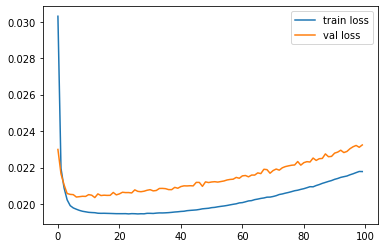

-----------------------------------------
 120
Epoch: 1
Train loss: 0.26578
Val loss: 0.18128
Epoch: 2
Train loss: 0.17175
Val loss: 0.17796
Epoch: 3
Train loss: 0.16610
Val loss: 0.17264
Epoch: 4
Train loss: 0.16257
Val loss: 0.16866
Epoch: 5
Train loss: 0.15953
Val loss: 0.16853
Epoch: 6
Train loss: 0.15722
Val loss: 0.16392
Epoch: 7
Train loss: 0.15542
Val loss: 0.16346
Epoch: 8
Train loss: 0.15400
Val loss: 0.16300
Epoch: 9
Train loss: 0.15274
Val loss: 0.16260
Epoch: 10
Train loss: 0.15173
Val loss: 0.16101
Epoch: 11
Train loss: 0.15088
Val loss: 0.15927
Epoch: 12
Train loss: 0.15013
Val loss: 0.15675
Epoch: 13
Train loss: 0.14950
Val loss: 0.15692
Epoch: 14
Train loss: 0.14887
Val loss: 0.15774
Epoch: 15
Train loss: 0.14846
Val loss: 0.15751
Epoch: 16
Train loss: 0.14798
Val loss: 0.15605
Epoch: 17
Train loss: 0.14756
Val loss: 0.15726
Epoch: 18
Train loss: 0.14717
Val loss: 0.15409
Epoch: 19
Train loss: 0.14678
Val loss: 0.15428
Epoch: 20
Train loss: 0.14645
Val loss: 0.15414
Ep

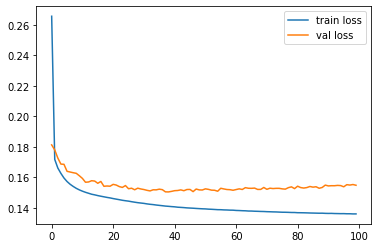

Epoch: 1
Train loss: 0.03233
Val loss: 0.02352
Epoch: 2
Train loss: 0.02206
Val loss: 0.02163
Epoch: 3
Train loss: 0.02082
Val loss: 0.02118
Epoch: 4
Train loss: 0.02044
Val loss: 0.02103
Epoch: 5
Train loss: 0.02025
Val loss: 0.02094
Epoch: 6
Train loss: 0.02016
Val loss: 0.02098
Epoch: 7
Train loss: 0.02008
Val loss: 0.02093
Epoch: 8
Train loss: 0.02004
Val loss: 0.02095
Epoch: 9
Train loss: 0.02001
Val loss: 0.02107
Epoch: 10
Train loss: 0.01999
Val loss: 0.02094
Epoch: 11
Train loss: 0.01999
Val loss: 0.02092
Epoch: 12
Train loss: 0.01998
Val loss: 0.02109
Epoch: 13
Train loss: 0.01997
Val loss: 0.02106
Epoch: 14
Train loss: 0.01998
Val loss: 0.02118
Epoch: 15
Train loss: 0.01998
Val loss: 0.02108
Epoch: 16
Train loss: 0.01997
Val loss: 0.02115
Epoch: 17
Train loss: 0.01997
Val loss: 0.02111
Epoch: 18
Train loss: 0.01998
Val loss: 0.02110
Epoch: 19
Train loss: 0.01997
Val loss: 0.02106
Epoch: 20
Train loss: 0.01999
Val loss: 0.02112
Epoch: 21
Train loss: 0.01999
Val loss: 0.02111
S

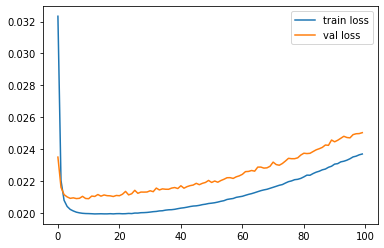

Epoch: 1
Train loss: 0.03304
Val loss: 0.02369
Epoch: 2
Train loss: 0.02246
Val loss: 0.02181
Epoch: 3
Train loss: 0.02107
Val loss: 0.02119
Epoch: 4
Train loss: 0.02049
Val loss: 0.02096
Epoch: 5
Train loss: 0.02030
Val loss: 0.02085
Epoch: 6
Train loss: 0.02018
Val loss: 0.02080
Epoch: 7
Train loss: 0.02011
Val loss: 0.02081
Epoch: 8
Train loss: 0.02005
Val loss: 0.02076
Epoch: 9
Train loss: 0.02002
Val loss: 0.02076
Epoch: 10
Train loss: 0.01999
Val loss: 0.02078
Epoch: 11
Train loss: 0.01997
Val loss: 0.02082
Epoch: 12
Train loss: 0.01997
Val loss: 0.02078
Epoch: 13
Train loss: 0.01995
Val loss: 0.02075
Epoch: 14
Train loss: 0.01994
Val loss: 0.02085
Epoch: 15
Train loss: 0.01993
Val loss: 0.02090
Epoch: 16
Train loss: 0.01993
Val loss: 0.02082
Epoch: 17
Train loss: 0.01994
Val loss: 0.02091
Epoch: 18
Train loss: 0.01992
Val loss: 0.02076
Epoch: 19
Train loss: 0.01993
Val loss: 0.02087
Epoch: 20
Train loss: 0.01993
Val loss: 0.02093
Epoch: 21
Train loss: 0.01993
Val loss: 0.02097
E

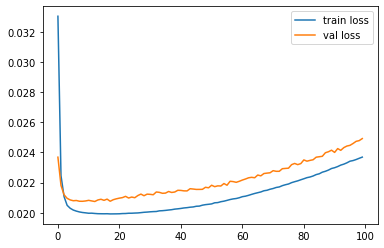

-----------------------------------------
 150
Epoch: 1
Train loss: 0.32122
Val loss: 0.19034
Epoch: 2
Train loss: 0.17882
Val loss: 0.18706
Epoch: 3
Train loss: 0.17282
Val loss: 0.17968
Epoch: 4
Train loss: 0.16947
Val loss: 0.17954
Epoch: 5
Train loss: 0.16657
Val loss: 0.17510
Epoch: 6
Train loss: 0.16398
Val loss: 0.17231
Epoch: 7
Train loss: 0.16173
Val loss: 0.16941
Epoch: 8
Train loss: 0.16002
Val loss: 0.16807
Epoch: 9
Train loss: 0.15862
Val loss: 0.16692
Epoch: 10
Train loss: 0.15748
Val loss: 0.16390
Epoch: 11
Train loss: 0.15655
Val loss: 0.16392
Epoch: 12
Train loss: 0.15575
Val loss: 0.16262
Epoch: 13
Train loss: 0.15494
Val loss: 0.16159
Epoch: 14
Train loss: 0.15433
Val loss: 0.16164
Epoch: 15
Train loss: 0.15362
Val loss: 0.16101
Epoch: 16
Train loss: 0.15300
Val loss: 0.15954
Epoch: 17
Train loss: 0.15247
Val loss: 0.15968
Epoch: 18
Train loss: 0.15199
Val loss: 0.16077
Epoch: 19
Train loss: 0.15142
Val loss: 0.15838
Epoch: 20
Train loss: 0.15086
Val loss: 0.15811
Ep

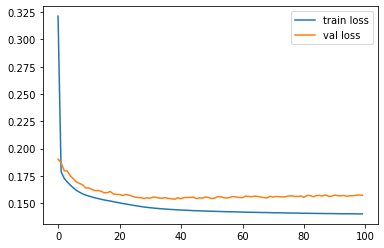

Epoch: 1
Train loss: 0.03601
Val loss: 0.02369
Epoch: 2
Train loss: 0.02258
Val loss: 0.02239
Epoch: 3
Train loss: 0.02178
Val loss: 0.02194
Epoch: 4
Train loss: 0.02141
Val loss: 0.02185
Epoch: 5
Train loss: 0.02120
Val loss: 0.02185
Epoch: 6
Train loss: 0.02110
Val loss: 0.02181
Epoch: 7
Train loss: 0.02102
Val loss: 0.02181
Epoch: 8
Train loss: 0.02098
Val loss: 0.02174
Epoch: 9
Train loss: 0.02095
Val loss: 0.02180
Epoch: 10
Train loss: 0.02093
Val loss: 0.02178
Epoch: 11
Train loss: 0.02091
Val loss: 0.02161
Epoch: 12
Train loss: 0.02090
Val loss: 0.02179
Epoch: 13
Train loss: 0.02091
Val loss: 0.02176
Epoch: 14
Train loss: 0.02090
Val loss: 0.02179
Epoch: 15
Train loss: 0.02091
Val loss: 0.02178
Epoch: 16
Train loss: 0.02090
Val loss: 0.02186
Epoch: 17
Train loss: 0.02092
Val loss: 0.02180
Epoch: 18
Train loss: 0.02092
Val loss: 0.02172
Epoch: 19
Train loss: 0.02092
Val loss: 0.02176
Epoch: 20
Train loss: 0.02093
Val loss: 0.02183
Epoch: 21
Train loss: 0.02094
Val loss: 0.02180
S

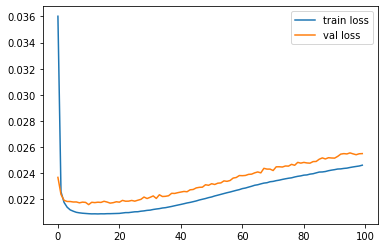

Epoch: 1
Train loss: 0.03622
Val loss: 0.02362
Epoch: 2
Train loss: 0.02271
Val loss: 0.02230
Epoch: 3
Train loss: 0.02179
Val loss: 0.02196
Epoch: 4
Train loss: 0.02147
Val loss: 0.02193
Epoch: 5
Train loss: 0.02129
Val loss: 0.02184
Epoch: 6
Train loss: 0.02119
Val loss: 0.02168
Epoch: 7
Train loss: 0.02111
Val loss: 0.02165
Epoch: 8
Train loss: 0.02106
Val loss: 0.02161
Epoch: 9
Train loss: 0.02104
Val loss: 0.02167
Epoch: 10
Train loss: 0.02101
Val loss: 0.02169
Epoch: 11
Train loss: 0.02101
Val loss: 0.02170
Epoch: 12
Train loss: 0.02100
Val loss: 0.02159
Epoch: 13
Train loss: 0.02100
Val loss: 0.02170
Epoch: 14
Train loss: 0.02099
Val loss: 0.02171
Epoch: 15
Train loss: 0.02099
Val loss: 0.02164
Epoch: 16
Train loss: 0.02100
Val loss: 0.02182
Epoch: 17
Train loss: 0.02101
Val loss: 0.02179
Epoch: 18
Train loss: 0.02103
Val loss: 0.02182
Epoch: 19
Train loss: 0.02104
Val loss: 0.02175
Epoch: 20
Train loss: 0.02105
Val loss: 0.02174
Epoch: 21
Train loss: 0.02107
Val loss: 0.02186
E

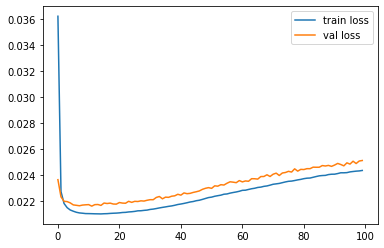

-----------------------------------------
 180
Epoch: 1
Train loss: 0.39333
Val loss: 0.19619
Epoch: 2
Train loss: 0.18389
Val loss: 0.18639
Epoch: 3
Train loss: 0.17679
Val loss: 0.18215
Epoch: 4
Train loss: 0.17353
Val loss: 0.17924
Epoch: 5
Train loss: 0.17143
Val loss: 0.17761
Epoch: 6
Train loss: 0.16950
Val loss: 0.17926
Epoch: 7
Train loss: 0.16778
Val loss: 0.17487
Epoch: 8
Train loss: 0.16610
Val loss: 0.17399
Epoch: 9
Train loss: 0.16464
Val loss: 0.17191
Epoch: 10
Train loss: 0.16335
Val loss: 0.17082
Epoch: 11
Train loss: 0.16227
Val loss: 0.16953
Epoch: 12
Train loss: 0.16121
Val loss: 0.16848
Epoch: 13
Train loss: 0.16036
Val loss: 0.16687
Epoch: 14
Train loss: 0.15956
Val loss: 0.16663
Epoch: 15
Train loss: 0.15885
Val loss: 0.16574
Epoch: 16
Train loss: 0.15820
Val loss: 0.16458
Epoch: 17
Train loss: 0.15746
Val loss: 0.16366
Epoch: 18
Train loss: 0.15689
Val loss: 0.16196
Epoch: 19
Train loss: 0.15624
Val loss: 0.16346
Epoch: 20
Train loss: 0.15557
Val loss: 0.16154
Ep

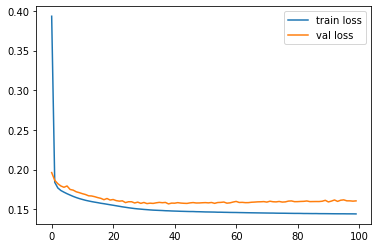

Epoch: 1
Train loss: 0.03978
Val loss: 0.02520
Epoch: 2
Train loss: 0.02408
Val loss: 0.02335
Epoch: 3
Train loss: 0.02306
Val loss: 0.02296
Epoch: 4
Train loss: 0.02265
Val loss: 0.02264
Epoch: 5
Train loss: 0.02245
Val loss: 0.02257
Epoch: 6
Train loss: 0.02232
Val loss: 0.02252
Epoch: 7
Train loss: 0.02225
Val loss: 0.02246
Epoch: 8
Train loss: 0.02218
Val loss: 0.02239
Epoch: 9
Train loss: 0.02216
Val loss: 0.02241
Epoch: 10
Train loss: 0.02213
Val loss: 0.02239
Epoch: 11
Train loss: 0.02211
Val loss: 0.02239
Epoch: 12
Train loss: 0.02211
Val loss: 0.02244
Epoch: 13
Train loss: 0.02211
Val loss: 0.02235
Epoch: 14
Train loss: 0.02211
Val loss: 0.02247
Epoch: 15
Train loss: 0.02212
Val loss: 0.02236
Epoch: 16
Train loss: 0.02214
Val loss: 0.02244
Epoch: 17
Train loss: 0.02215
Val loss: 0.02249
Epoch: 18
Train loss: 0.02217
Val loss: 0.02236
Epoch: 19
Train loss: 0.02218
Val loss: 0.02257
Epoch: 20
Train loss: 0.02222
Val loss: 0.02256
Epoch: 21
Train loss: 0.02224
Val loss: 0.02262
E

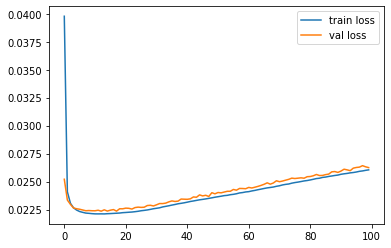

Epoch: 1
Train loss: 0.03924
Val loss: 0.02513
Epoch: 2
Train loss: 0.02381
Val loss: 0.02332
Epoch: 3
Train loss: 0.02275
Val loss: 0.02292
Epoch: 4
Train loss: 0.02229
Val loss: 0.02252
Epoch: 5
Train loss: 0.02206
Val loss: 0.02243
Epoch: 6
Train loss: 0.02193
Val loss: 0.02234
Epoch: 7
Train loss: 0.02186
Val loss: 0.02233
Epoch: 8
Train loss: 0.02180
Val loss: 0.02228
Epoch: 9
Train loss: 0.02178
Val loss: 0.02227
Epoch: 10
Train loss: 0.02175
Val loss: 0.02228
Epoch: 11
Train loss: 0.02173
Val loss: 0.02230
Epoch: 12
Train loss: 0.02173
Val loss: 0.02234
Epoch: 13
Train loss: 0.02172
Val loss: 0.02237
Epoch: 14
Train loss: 0.02174
Val loss: 0.02229
Epoch: 15
Train loss: 0.02174
Val loss: 0.02230
Epoch: 16
Train loss: 0.02175
Val loss: 0.02236
Epoch: 17
Train loss: 0.02176
Val loss: 0.02243
Epoch: 18
Train loss: 0.02177
Val loss: 0.02236
Epoch: 19
Train loss: 0.02180
Val loss: 0.02244
Save early stopping model at epoch 19
Epoch: 20
Train loss: 0.02181
Val loss: 0.02244
Epoch: 21
T

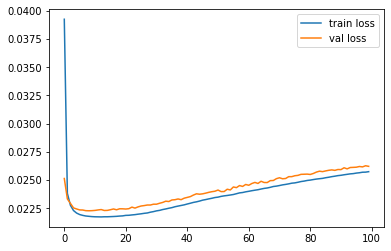

-----------------------------------------
 200
Epoch: 1
Train loss: 0.44837
Val loss: 0.20339
Epoch: 2
Train loss: 0.18948
Val loss: 0.19286
Epoch: 3
Train loss: 0.18130
Val loss: 0.19372
Epoch: 4
Train loss: 0.17761
Val loss: 0.18978
Epoch: 5
Train loss: 0.17519
Val loss: 0.18184
Epoch: 6
Train loss: 0.17324
Val loss: 0.18371
Epoch: 7
Train loss: 0.17126
Val loss: 0.18012
Epoch: 8
Train loss: 0.16953
Val loss: 0.17751
Epoch: 9
Train loss: 0.16789
Val loss: 0.17587
Epoch: 10
Train loss: 0.16671
Val loss: 0.17305
Epoch: 11
Train loss: 0.16541
Val loss: 0.17427
Epoch: 12
Train loss: 0.16436
Val loss: 0.17229
Epoch: 13
Train loss: 0.16343
Val loss: 0.16979
Epoch: 14
Train loss: 0.16265
Val loss: 0.16965
Epoch: 15
Train loss: 0.16179
Val loss: 0.16925
Epoch: 16
Train loss: 0.16097
Val loss: 0.16843
Epoch: 17
Train loss: 0.16028
Val loss: 0.16651
Epoch: 18
Train loss: 0.15943
Val loss: 0.16685
Epoch: 19
Train loss: 0.15863
Val loss: 0.16524
Epoch: 20
Train loss: 0.15784
Val loss: 0.16429
Ep

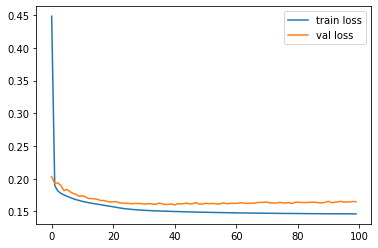

Epoch: 1
Train loss: 0.04244
Val loss: 0.02733
Epoch: 2
Train loss: 0.02591
Val loss: 0.02503
Epoch: 3
Train loss: 0.02438
Val loss: 0.02416
Epoch: 4
Train loss: 0.02367
Val loss: 0.02375
Epoch: 5
Train loss: 0.02328
Val loss: 0.02335
Epoch: 6
Train loss: 0.02306
Val loss: 0.02333
Epoch: 7
Train loss: 0.02293
Val loss: 0.02316
Epoch: 8
Train loss: 0.02283
Val loss: 0.02316
Epoch: 9
Train loss: 0.02277
Val loss: 0.02312
Epoch: 10
Train loss: 0.02273
Val loss: 0.02306
Epoch: 11
Train loss: 0.02270
Val loss: 0.02314
Epoch: 12
Train loss: 0.02269
Val loss: 0.02316
Epoch: 13
Train loss: 0.02267
Val loss: 0.02315
Epoch: 14
Train loss: 0.02267
Val loss: 0.02311
Epoch: 15
Train loss: 0.02269
Val loss: 0.02321
Epoch: 16
Train loss: 0.02269
Val loss: 0.02308
Epoch: 17
Train loss: 0.02270
Val loss: 0.02319
Epoch: 18
Train loss: 0.02272
Val loss: 0.02321
Epoch: 19
Train loss: 0.02274
Val loss: 0.02332
Epoch: 20
Train loss: 0.02277
Val loss: 0.02317
Save early stopping model at epoch 20
Epoch: 21
T

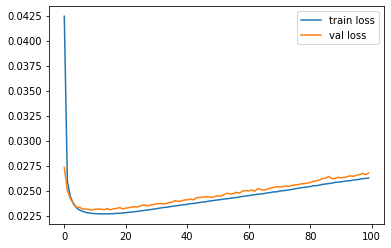

Epoch: 1
Train loss: 0.04086
Val loss: 0.02616
Epoch: 2
Train loss: 0.02461
Val loss: 0.02419
Epoch: 3
Train loss: 0.02352
Val loss: 0.02355
Epoch: 4
Train loss: 0.02306
Val loss: 0.02334
Epoch: 5
Train loss: 0.02283
Val loss: 0.02313
Epoch: 6
Train loss: 0.02271
Val loss: 0.02308
Epoch: 7
Train loss: 0.02263
Val loss: 0.02302
Epoch: 8
Train loss: 0.02259
Val loss: 0.02301
Epoch: 9
Train loss: 0.02255
Val loss: 0.02300
Epoch: 10
Train loss: 0.02253
Val loss: 0.02302
Epoch: 11
Train loss: 0.02254
Val loss: 0.02295
Epoch: 12
Train loss: 0.02253
Val loss: 0.02292
Epoch: 13
Train loss: 0.02253
Val loss: 0.02302
Epoch: 14
Train loss: 0.02255
Val loss: 0.02298
Epoch: 15
Train loss: 0.02254
Val loss: 0.02304
Epoch: 16
Train loss: 0.02256
Val loss: 0.02302
Epoch: 17
Train loss: 0.02257
Val loss: 0.02311
Epoch: 18
Train loss: 0.02260
Val loss: 0.02313
Epoch: 19
Train loss: 0.02262
Val loss: 0.02304
Epoch: 20
Train loss: 0.02264
Val loss: 0.02320
Epoch: 21
Train loss: 0.02266
Val loss: 0.02320
E

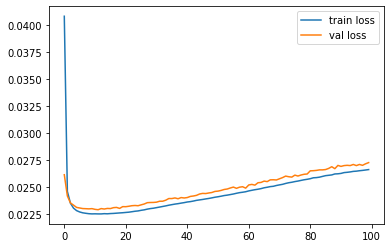

In [7]:
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
max_epoch = 100

for p in [10,20,50,80,100,120,150,180,200]:
    print('-----------------------------------------\n',p)
    generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP(p, p).to(device)
    md_mean_es = MLP(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/5layer_normal_mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/5layer_normal_mean_p'+str(p)+'_es.pt')

    md_q025 = MLP(p, p).to(device)
    md_q025_es = MLP(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/5layer_normal_q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/5layer_normal_q025_p'+str(p)+'_es.pt')

    md_q975 = MLP(p, p).to(device)
    md_q975_es = MLP(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/5layer_normal_q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/5layer_normal_q975_p'+str(p)+'_es.pt')

In [12]:
p = 18
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

rng.seed(0)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(10000)

mean = Y_train.mean(0)
std = Y_train.std(0)
Y_train = (Y_train - mean) / std 
Y_val = (Y_val - mean) / std 
train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

Y_test_normalized = (Y_test - mean) / std 

In [9]:
md_mean = MLP_light(18, 18).to(device)
md_q025 = MLP_light(18, 18).to(device)
md_q975 = MLP_light(18, 18).to(device)
md_mean.load_state_dict(torch.load('./model/normal_mean_p18_es.pt'))
md_q025.load_state_dict(torch.load('./model/normal_q025_p18_es.pt'))
md_q975.load_state_dict(torch.load('./model/normal_q975_p18_es.pt'))

<All keys matched successfully>

In [13]:
pred_mean = predict(md_mean, Y_test_normalized)
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)

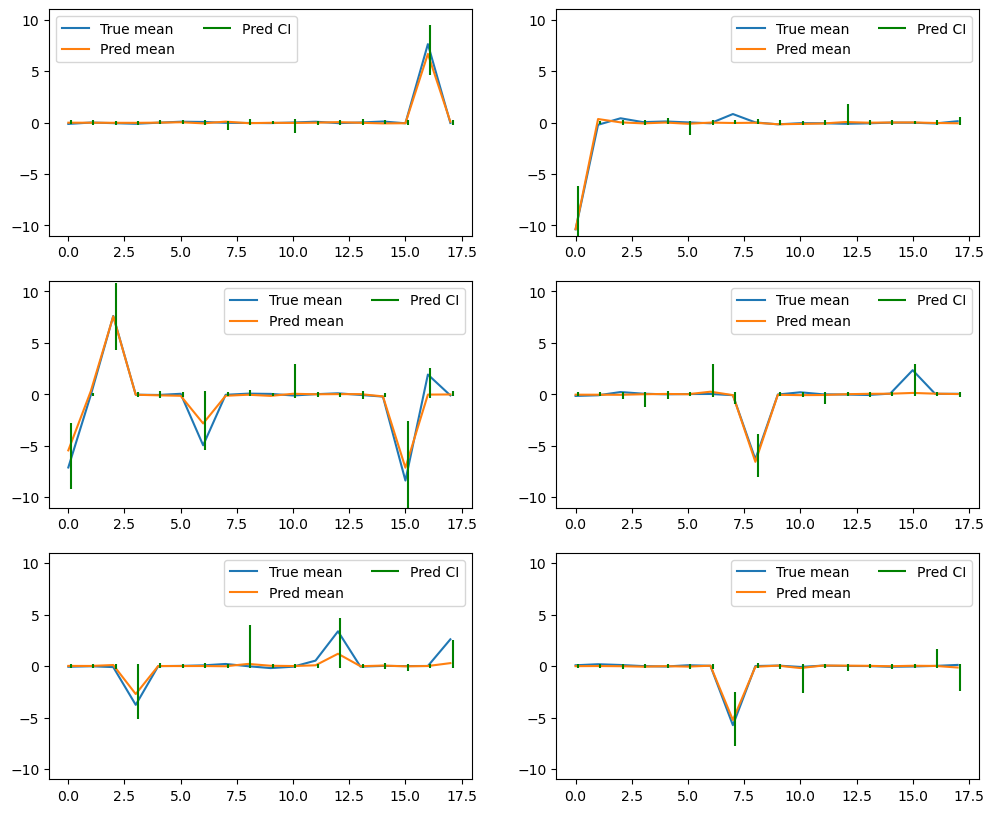

In [14]:
subset = np.where(np.abs(beta_test)>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]

plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), beta_test[idx])
    plt.plot(range(p), pred_mean[idx])
    plt.vlines(np.arange(p)+0.1, pred_q025[idx], pred_q975[idx], color='green')
    plt.legend(['True beta', 'Pred mean', 'Pred CI'], ncol=2)
    plt.ylim(-11,11)
plt.show()

Epoch: 1
Train loss: 0.41868
Val loss: 0.16491
Epoch: 2
Train loss: 0.15141
Val loss: 0.14430
Epoch: 3
Train loss: 0.13888
Val loss: 0.13431
Epoch: 4
Train loss: 0.13127
Val loss: 0.12983
Epoch: 5
Train loss: 0.12741
Val loss: 0.12742
Epoch: 6
Train loss: 0.12511
Val loss: 0.12616
Epoch: 7
Train loss: 0.12344
Val loss: 0.12481
Epoch: 8
Train loss: 0.12206
Val loss: 0.12374
Epoch: 9
Train loss: 0.12097
Val loss: 0.12285
Epoch: 10
Train loss: 0.11999
Val loss: 0.12216
Epoch: 11
Train loss: 0.11922
Val loss: 0.12217
Epoch: 12
Train loss: 0.11853
Val loss: 0.12144
Epoch: 13
Train loss: 0.11793
Val loss: 0.12060
Epoch: 14
Train loss: 0.11740
Val loss: 0.12065
Epoch: 15
Train loss: 0.11695
Val loss: 0.11969
Epoch: 16
Train loss: 0.11648
Val loss: 0.11981
Epoch: 17
Train loss: 0.11611
Val loss: 0.11933
Epoch: 18
Train loss: 0.11573
Val loss: 0.11930
Epoch: 19
Train loss: 0.11534
Val loss: 0.11951
Epoch: 20
Train loss: 0.11504
Val loss: 0.11918
Epoch: 21
Train loss: 0.11474
Val loss: 0.11925
E

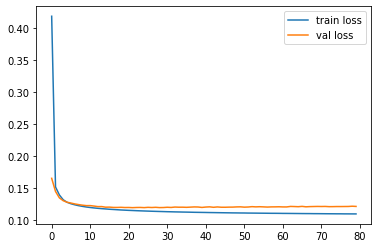

Epoch: 1
Train loss: 0.02821
Val loss: 0.01775
Epoch: 2
Train loss: 0.01716
Val loss: 0.01679
Epoch: 3
Train loss: 0.01635
Val loss: 0.01598
Epoch: 4
Train loss: 0.01568
Val loss: 0.01548
Epoch: 5
Train loss: 0.01526
Val loss: 0.01510
Epoch: 6
Train loss: 0.01494
Val loss: 0.01471
Epoch: 7
Train loss: 0.01463
Val loss: 0.01449
Epoch: 8
Train loss: 0.01435
Val loss: 0.01417
Epoch: 9
Train loss: 0.01409
Val loss: 0.01394
Epoch: 10
Train loss: 0.01387
Val loss: 0.01376
Epoch: 11
Train loss: 0.01372
Val loss: 0.01367
Epoch: 12
Train loss: 0.01358
Val loss: 0.01353
Epoch: 13
Train loss: 0.01351
Val loss: 0.01354
Epoch: 14
Train loss: 0.01347
Val loss: 0.01350
Epoch: 15
Train loss: 0.01343
Val loss: 0.01344
Epoch: 16
Train loss: 0.01340
Val loss: 0.01346
Epoch: 17
Train loss: 0.01337
Val loss: 0.01348
Epoch: 18
Train loss: 0.01334
Val loss: 0.01351
Epoch: 19
Train loss: 0.01331
Val loss: 0.01347
Epoch: 20
Train loss: 0.01329
Val loss: 0.01342
Epoch: 21
Train loss: 0.01328
Val loss: 0.01340
E

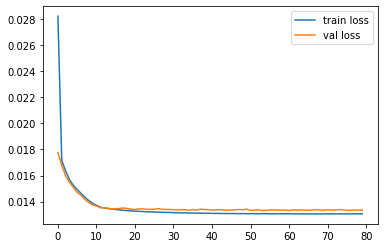

Epoch: 1
Train loss: 0.02821
Val loss: 0.01781
Epoch: 2
Train loss: 0.01723
Val loss: 0.01715
Epoch: 3
Train loss: 0.01643
Val loss: 0.01606
Epoch: 4
Train loss: 0.01576
Val loss: 0.01557
Epoch: 5
Train loss: 0.01538
Val loss: 0.01533
Epoch: 6
Train loss: 0.01514
Val loss: 0.01505
Epoch: 7
Train loss: 0.01493
Val loss: 0.01484
Epoch: 8
Train loss: 0.01475
Val loss: 0.01465
Epoch: 9
Train loss: 0.01459
Val loss: 0.01452
Epoch: 10
Train loss: 0.01444
Val loss: 0.01436
Epoch: 11
Train loss: 0.01430
Val loss: 0.01428
Epoch: 12
Train loss: 0.01419
Val loss: 0.01411
Epoch: 13
Train loss: 0.01407
Val loss: 0.01405
Epoch: 14
Train loss: 0.01398
Val loss: 0.01394
Epoch: 15
Train loss: 0.01389
Val loss: 0.01386
Epoch: 16
Train loss: 0.01381
Val loss: 0.01381
Epoch: 17
Train loss: 0.01372
Val loss: 0.01375
Epoch: 18
Train loss: 0.01365
Val loss: 0.01361
Epoch: 19
Train loss: 0.01357
Val loss: 0.01360
Epoch: 20
Train loss: 0.01352
Val loss: 0.01352
Epoch: 21
Train loss: 0.01346
Val loss: 0.01352
E

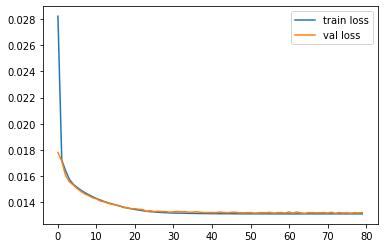

Epoch: 1
Train loss: 0.57918
Val loss: 0.21854
Epoch: 2
Train loss: 0.15585
Val loss: 0.14813
Epoch: 3
Train loss: 0.14368
Val loss: 0.14126
Epoch: 4
Train loss: 0.13632
Val loss: 0.13478
Epoch: 5
Train loss: 0.13071
Val loss: 0.13078
Epoch: 6
Train loss: 0.12782
Val loss: 0.12908
Epoch: 7
Train loss: 0.12623
Val loss: 0.12732
Epoch: 8
Train loss: 0.12525
Val loss: 0.12776
Epoch: 9
Train loss: 0.12452
Val loss: 0.12624
Epoch: 10
Train loss: 0.12394
Val loss: 0.12595
Epoch: 11
Train loss: 0.12336
Val loss: 0.12530
Epoch: 12
Train loss: 0.12285
Val loss: 0.12440
Epoch: 13
Train loss: 0.12235
Val loss: 0.12371
Epoch: 14
Train loss: 0.12191
Val loss: 0.12315
Epoch: 15
Train loss: 0.12155
Val loss: 0.12298
Epoch: 16
Train loss: 0.12118
Val loss: 0.12224
Epoch: 17
Train loss: 0.12088
Val loss: 0.12209
Epoch: 18
Train loss: 0.12053
Val loss: 0.12212
Epoch: 19
Train loss: 0.12022
Val loss: 0.12164
Epoch: 20
Train loss: 0.11993
Val loss: 0.12173
Epoch: 21
Train loss: 0.11969
Val loss: 0.12114
E

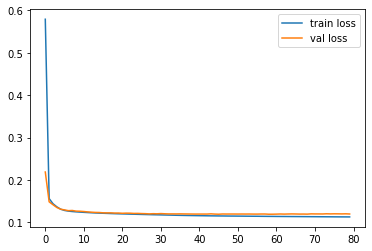

Epoch: 1
Train loss: 0.03063
Val loss: 0.01856
Epoch: 2
Train loss: 0.01805
Val loss: 0.01765
Epoch: 3
Train loss: 0.01731
Val loss: 0.01720
Epoch: 4
Train loss: 0.01668
Val loss: 0.01645
Epoch: 5
Train loss: 0.01628
Val loss: 0.01630
Epoch: 6
Train loss: 0.01605
Val loss: 0.01607
Epoch: 7
Train loss: 0.01590
Val loss: 0.01587
Epoch: 8
Train loss: 0.01578
Val loss: 0.01580
Epoch: 9
Train loss: 0.01567
Val loss: 0.01576
Epoch: 10
Train loss: 0.01558
Val loss: 0.01549
Epoch: 11
Train loss: 0.01551
Val loss: 0.01560
Epoch: 12
Train loss: 0.01545
Val loss: 0.01540
Epoch: 13
Train loss: 0.01539
Val loss: 0.01546
Epoch: 14
Train loss: 0.01535
Val loss: 0.01540
Epoch: 15
Train loss: 0.01531
Val loss: 0.01525
Epoch: 16
Train loss: 0.01526
Val loss: 0.01522
Epoch: 17
Train loss: 0.01522
Val loss: 0.01522
Epoch: 18
Train loss: 0.01516
Val loss: 0.01522
Epoch: 19
Train loss: 0.01511
Val loss: 0.01513
Epoch: 20
Train loss: 0.01504
Val loss: 0.01507
Epoch: 21
Train loss: 0.01499
Val loss: 0.01502
E

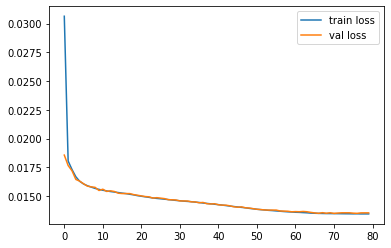

Epoch: 1
Train loss: 0.03052
Val loss: 0.01912
Epoch: 2
Train loss: 0.01799
Val loss: 0.01788
Epoch: 3
Train loss: 0.01726
Val loss: 0.01719
Epoch: 4
Train loss: 0.01663
Val loss: 0.01666
Epoch: 5
Train loss: 0.01625
Val loss: 0.01614
Epoch: 6
Train loss: 0.01601
Val loss: 0.01605
Epoch: 7
Train loss: 0.01584
Val loss: 0.01584
Epoch: 8
Train loss: 0.01570
Val loss: 0.01580
Epoch: 9
Train loss: 0.01558
Val loss: 0.01576
Epoch: 10
Train loss: 0.01546
Val loss: 0.01546
Epoch: 11
Train loss: 0.01536
Val loss: 0.01542
Epoch: 12
Train loss: 0.01526
Val loss: 0.01532
Epoch: 13
Train loss: 0.01518
Val loss: 0.01524
Epoch: 14
Train loss: 0.01511
Val loss: 0.01521
Epoch: 15
Train loss: 0.01505
Val loss: 0.01513
Epoch: 16
Train loss: 0.01499
Val loss: 0.01508
Epoch: 17
Train loss: 0.01493
Val loss: 0.01504
Epoch: 18
Train loss: 0.01489
Val loss: 0.01495
Epoch: 19
Train loss: 0.01483
Val loss: 0.01490
Epoch: 20
Train loss: 0.01479
Val loss: 0.01492
Epoch: 21
Train loss: 0.01475
Val loss: 0.01478
E

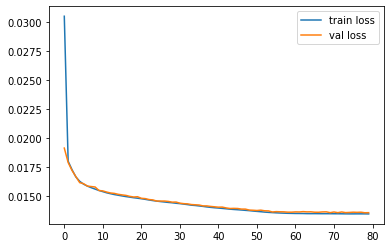

Epoch: 1
Train loss: 0.67697
Val loss: 0.61646
Epoch: 2
Train loss: 0.31456
Val loss: 0.15623
Epoch: 3
Train loss: 0.14949
Val loss: 0.15145
Epoch: 4
Train loss: 0.14632
Val loss: 0.14712
Epoch: 5
Train loss: 0.14097
Val loss: 0.14194
Epoch: 6
Train loss: 0.13641
Val loss: 0.13865
Epoch: 7
Train loss: 0.13286
Val loss: 0.13435
Epoch: 8
Train loss: 0.13042
Val loss: 0.13419
Epoch: 9
Train loss: 0.12892
Val loss: 0.13254
Epoch: 10
Train loss: 0.12787
Val loss: 0.13119
Epoch: 11
Train loss: 0.12717
Val loss: 0.13067
Epoch: 12
Train loss: 0.12656
Val loss: 0.13022
Epoch: 13
Train loss: 0.12602
Val loss: 0.12967
Epoch: 14
Train loss: 0.12548
Val loss: 0.12829
Epoch: 15
Train loss: 0.12503
Val loss: 0.12815
Epoch: 16
Train loss: 0.12461
Val loss: 0.12742
Epoch: 17
Train loss: 0.12426
Val loss: 0.12725
Epoch: 18
Train loss: 0.12389
Val loss: 0.12705
Epoch: 19
Train loss: 0.12361
Val loss: 0.12684
Epoch: 20
Train loss: 0.12333
Val loss: 0.12662
Epoch: 21
Train loss: 0.12308
Val loss: 0.12585
E

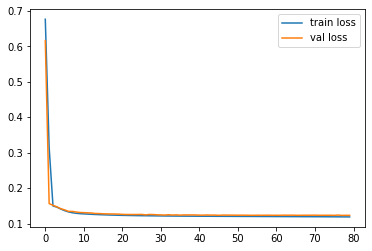

Epoch: 1
Train loss: 0.03296
Val loss: 0.02000
Epoch: 2
Train loss: 0.01896
Val loss: 0.01903
Epoch: 3
Train loss: 0.01805
Val loss: 0.01802
Epoch: 4
Train loss: 0.01733
Val loss: 0.01744
Epoch: 5
Train loss: 0.01688
Val loss: 0.01703
Epoch: 6
Train loss: 0.01662
Val loss: 0.01690
Epoch: 7
Train loss: 0.01643
Val loss: 0.01679
Epoch: 8
Train loss: 0.01629
Val loss: 0.01669
Epoch: 9
Train loss: 0.01618
Val loss: 0.01641
Epoch: 10
Train loss: 0.01610
Val loss: 0.01648
Epoch: 11
Train loss: 0.01604
Val loss: 0.01629
Epoch: 12
Train loss: 0.01599
Val loss: 0.01630
Epoch: 13
Train loss: 0.01593
Val loss: 0.01624
Epoch: 14
Train loss: 0.01588
Val loss: 0.01627
Epoch: 15
Train loss: 0.01584
Val loss: 0.01625
Epoch: 16
Train loss: 0.01580
Val loss: 0.01602
Epoch: 17
Train loss: 0.01578
Val loss: 0.01604
Epoch: 18
Train loss: 0.01575
Val loss: 0.01615
Epoch: 19
Train loss: 0.01573
Val loss: 0.01609
Epoch: 20
Train loss: 0.01570
Val loss: 0.01591
Epoch: 21
Train loss: 0.01569
Val loss: 0.01601
E

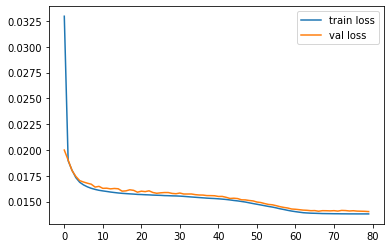

Epoch: 1
Train loss: 0.03302
Val loss: 0.01977
Epoch: 2
Train loss: 0.01897
Val loss: 0.01867
Epoch: 3
Train loss: 0.01805
Val loss: 0.01779
Epoch: 4
Train loss: 0.01736
Val loss: 0.01737
Epoch: 5
Train loss: 0.01691
Val loss: 0.01688
Epoch: 6
Train loss: 0.01664
Val loss: 0.01674
Epoch: 7
Train loss: 0.01644
Val loss: 0.01679
Epoch: 8
Train loss: 0.01631
Val loss: 0.01643
Epoch: 9
Train loss: 0.01619
Val loss: 0.01629
Epoch: 10
Train loss: 0.01610
Val loss: 0.01637
Epoch: 11
Train loss: 0.01603
Val loss: 0.01615
Epoch: 12
Train loss: 0.01595
Val loss: 0.01628
Epoch: 13
Train loss: 0.01590
Val loss: 0.01603
Epoch: 14
Train loss: 0.01585
Val loss: 0.01603
Epoch: 15
Train loss: 0.01581
Val loss: 0.01609
Epoch: 16
Train loss: 0.01578
Val loss: 0.01589
Epoch: 17
Train loss: 0.01575
Val loss: 0.01609
Epoch: 18
Train loss: 0.01573
Val loss: 0.01588
Epoch: 19
Train loss: 0.01570
Val loss: 0.01586
Epoch: 20
Train loss: 0.01568
Val loss: 0.01601
Epoch: 21
Train loss: 0.01566
Val loss: 0.01588
E

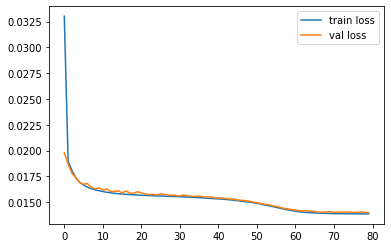

Epoch: 1
Train loss: 0.69399
Val loss: 0.64883
Epoch: 2
Train loss: 0.51762
Val loss: 0.25865
Epoch: 3
Train loss: 0.16603
Val loss: 0.15768
Epoch: 4
Train loss: 0.15155
Val loss: 0.15305
Epoch: 5
Train loss: 0.14775
Val loss: 0.14798
Epoch: 6
Train loss: 0.14331
Val loss: 0.14553
Epoch: 7
Train loss: 0.13954
Val loss: 0.14296
Epoch: 8
Train loss: 0.13671
Val loss: 0.13883
Epoch: 9
Train loss: 0.13446
Val loss: 0.13588
Epoch: 10
Train loss: 0.13257
Val loss: 0.13525
Epoch: 11
Train loss: 0.13120
Val loss: 0.13294
Epoch: 12
Train loss: 0.13008
Val loss: 0.13306
Epoch: 13
Train loss: 0.12917
Val loss: 0.13146
Epoch: 14
Train loss: 0.12839
Val loss: 0.13166
Epoch: 15
Train loss: 0.12769
Val loss: 0.13054
Epoch: 16
Train loss: 0.12703
Val loss: 0.13023
Epoch: 17
Train loss: 0.12643
Val loss: 0.12845
Epoch: 18
Train loss: 0.12592
Val loss: 0.12910
Epoch: 19
Train loss: 0.12550
Val loss: 0.12815
Epoch: 20
Train loss: 0.12512
Val loss: 0.12773
Epoch: 21
Train loss: 0.12480
Val loss: 0.12762
E

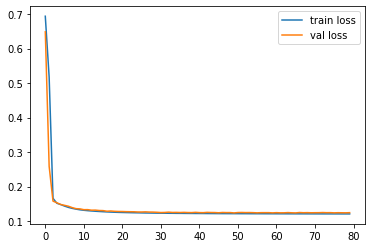

Epoch: 1
Train loss: 0.03461
Val loss: 0.02065
Epoch: 2
Train loss: 0.01955
Val loss: 0.01922
Epoch: 3
Train loss: 0.01857
Val loss: 0.01850
Epoch: 4
Train loss: 0.01783
Val loss: 0.01769
Epoch: 5
Train loss: 0.01731
Val loss: 0.01722
Epoch: 6
Train loss: 0.01698
Val loss: 0.01712
Epoch: 7
Train loss: 0.01678
Val loss: 0.01664
Epoch: 8
Train loss: 0.01660
Val loss: 0.01664
Epoch: 9
Train loss: 0.01648
Val loss: 0.01682
Epoch: 10
Train loss: 0.01637
Val loss: 0.01660
Epoch: 11
Train loss: 0.01629
Val loss: 0.01635
Epoch: 12
Train loss: 0.01621
Val loss: 0.01637
Epoch: 13
Train loss: 0.01615
Val loss: 0.01636
Epoch: 14
Train loss: 0.01611
Val loss: 0.01614
Epoch: 15
Train loss: 0.01606
Val loss: 0.01627
Epoch: 16
Train loss: 0.01604
Val loss: 0.01631
Epoch: 17
Train loss: 0.01601
Val loss: 0.01607
Epoch: 18
Train loss: 0.01599
Val loss: 0.01619
Epoch: 19
Train loss: 0.01597
Val loss: 0.01628
Epoch: 20
Train loss: 0.01596
Val loss: 0.01621
Epoch: 21
Train loss: 0.01594
Val loss: 0.01625
E

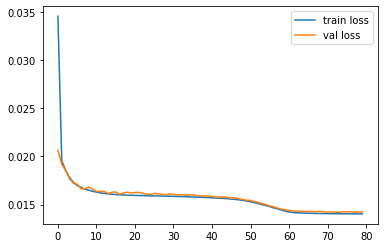

Epoch: 1
Train loss: 0.03455
Val loss: 0.02085
Epoch: 2
Train loss: 0.01956
Val loss: 0.01882
Epoch: 3
Train loss: 0.01856
Val loss: 0.01836
Epoch: 4
Train loss: 0.01781
Val loss: 0.01772
Epoch: 5
Train loss: 0.01733
Val loss: 0.01753
Epoch: 6
Train loss: 0.01701
Val loss: 0.01725
Epoch: 7
Train loss: 0.01679
Val loss: 0.01673
Epoch: 8
Train loss: 0.01661
Val loss: 0.01667
Epoch: 9
Train loss: 0.01646
Val loss: 0.01678
Epoch: 10
Train loss: 0.01638
Val loss: 0.01683
Epoch: 11
Train loss: 0.01629
Val loss: 0.01638
Epoch: 12
Train loss: 0.01623
Val loss: 0.01621
Epoch: 13
Train loss: 0.01617
Val loss: 0.01612
Epoch: 14
Train loss: 0.01613
Val loss: 0.01618
Epoch: 15
Train loss: 0.01609
Val loss: 0.01633
Epoch: 16
Train loss: 0.01607
Val loss: 0.01637
Epoch: 17
Train loss: 0.01604
Val loss: 0.01625
Epoch: 18
Train loss: 0.01602
Val loss: 0.01609
Epoch: 19
Train loss: 0.01600
Val loss: 0.01623
Epoch: 20
Train loss: 0.01598
Val loss: 0.01601
Epoch: 21
Train loss: 0.01597
Val loss: 0.01604
E

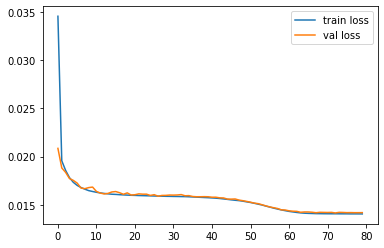

In [9]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

In [14]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [10,12,14,16,18,20,50,80,100,120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean_es = MLP_light(p, p).to(device)
    if p<=150:
        md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'_es.pt'))
    else:
        md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'.pt'))
    
    md_q025_es = MLP_light(p, p).to(device)
    if p<=150:
        md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'_es.pt'))
    else:
        md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'.pt'))

    md_q975_es = MLP_light(p, p).to(device)
    if p<=150:
        md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'_es.pt'))
    else:
        md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'.pt'))

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

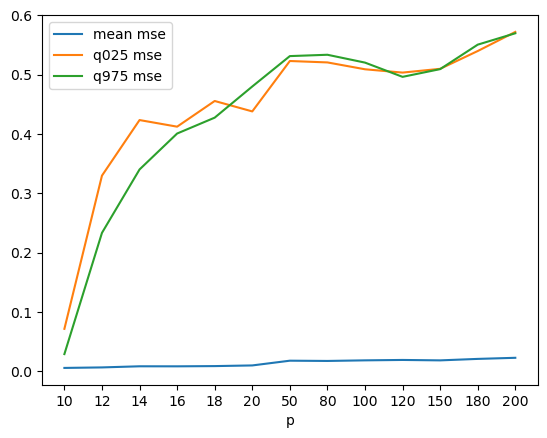

In [16]:
plt.plot(all_mean_mse)
plt.plot(all_q025_mse)
plt.plot(all_q975_mse)
plt.legend(['mean mse', 'q025 mse', 'q975 mse'])
plt.xticks(range(13), ['10', '12', '14', '16', '18', '20', '50', '80', '100', '120', '150', '180', '200'])
plt.xlabel('p')
plt.show()

Epoch: 1
Train loss: 0.13199
Val loss: 0.11156
Epoch: 2
Train loss: 0.11186
Val loss: 0.10740
Epoch: 3
Train loss: 0.11007
Val loss: 0.10818
Epoch: 4
Train loss: 0.10906
Val loss: 0.10659
Epoch: 5
Train loss: 0.10836
Val loss: 0.10823
Epoch: 6
Train loss: 0.10782
Val loss: 0.10609
Epoch: 7
Train loss: 0.10746
Val loss: 0.10668
Epoch: 8
Train loss: 0.10699
Val loss: 0.10707
Epoch: 9
Train loss: 0.10669
Val loss: 0.10579
Epoch: 10
Train loss: 0.10637
Val loss: 0.10554
Epoch: 11
Train loss: 0.10621
Val loss: 0.10507
Epoch: 12
Train loss: 0.10594
Val loss: 0.10541
Epoch: 13
Train loss: 0.10579
Val loss: 0.10487
Epoch: 14
Train loss: 0.10557
Val loss: 0.10592
Epoch: 15
Train loss: 0.10541
Val loss: 0.10492
Epoch: 16
Train loss: 0.10530
Val loss: 0.10494
Epoch: 17
Train loss: 0.10507
Val loss: 0.10476
Epoch: 18
Train loss: 0.10502
Val loss: 0.10436
Epoch: 19
Train loss: 0.10488
Val loss: 0.10419
Epoch: 20
Train loss: 0.10471
Val loss: 0.10449
Epoch: 21
Train loss: 0.10460
Val loss: 0.10499
E

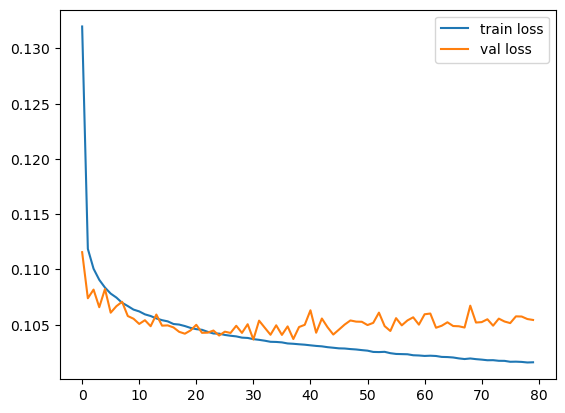

Epoch: 1
Train loss: 0.01502
Val loss: 0.01249
Epoch: 2
Train loss: 0.01273
Val loss: 0.01231
Epoch: 3
Train loss: 0.01241
Val loss: 0.01215
Epoch: 4
Train loss: 0.01225
Val loss: 0.01216
Epoch: 5
Train loss: 0.01215
Val loss: 0.01193
Epoch: 6
Train loss: 0.01208
Val loss: 0.01192
Epoch: 7
Train loss: 0.01201
Val loss: 0.01192
Epoch: 8
Train loss: 0.01197
Val loss: 0.01181
Epoch: 9
Train loss: 0.01194
Val loss: 0.01182
Epoch: 10
Train loss: 0.01191
Val loss: 0.01175
Epoch: 11
Train loss: 0.01189
Val loss: 0.01185
Epoch: 12
Train loss: 0.01185
Val loss: 0.01181
Epoch: 13
Train loss: 0.01184
Val loss: 0.01163
Epoch: 14
Train loss: 0.01182
Val loss: 0.01175
Epoch: 15
Train loss: 0.01180
Val loss: 0.01175
Epoch: 16
Train loss: 0.01179
Val loss: 0.01172
Epoch: 17
Train loss: 0.01176
Val loss: 0.01182
Epoch: 18
Train loss: 0.01176
Val loss: 0.01177
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.01175
Val loss: 0.01171
Epoch: 20
Train loss: 0.01174
Val loss: 0.01171
Epoch: 21
T

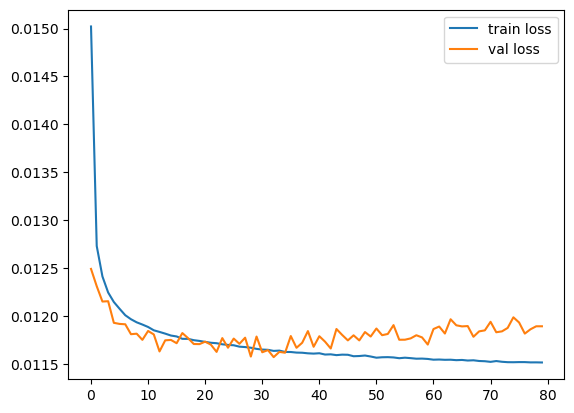

Epoch: 1
Train loss: 0.01500
Val loss: 0.01244
Epoch: 2
Train loss: 0.01250
Val loss: 0.01235
Epoch: 3
Train loss: 0.01220
Val loss: 0.01190
Epoch: 4
Train loss: 0.01205
Val loss: 0.01192
Epoch: 5
Train loss: 0.01194
Val loss: 0.01175
Epoch: 6
Train loss: 0.01187
Val loss: 0.01178
Epoch: 7
Train loss: 0.01181
Val loss: 0.01170
Epoch: 8
Train loss: 0.01176
Val loss: 0.01165
Epoch: 9
Train loss: 0.01172
Val loss: 0.01143
Epoch: 10
Train loss: 0.01168
Val loss: 0.01156
Epoch: 11
Train loss: 0.01165
Val loss: 0.01148
Epoch: 12
Train loss: 0.01162
Val loss: 0.01151
Epoch: 13
Train loss: 0.01159
Val loss: 0.01138
Epoch: 14
Train loss: 0.01157
Val loss: 0.01147
Epoch: 15
Train loss: 0.01155
Val loss: 0.01136
Epoch: 16
Train loss: 0.01153
Val loss: 0.01147
Epoch: 17
Train loss: 0.01151
Val loss: 0.01141
Epoch: 18
Train loss: 0.01151
Val loss: 0.01150
Epoch: 19
Train loss: 0.01149
Val loss: 0.01128
Epoch: 20
Train loss: 0.01147
Val loss: 0.01135
Epoch: 21
Train loss: 0.01147
Val loss: 0.01134
E

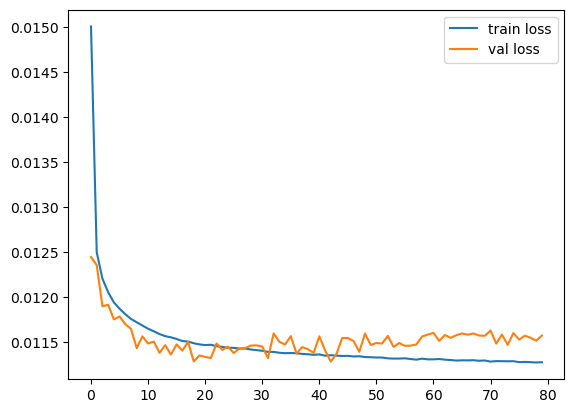

Epoch: 1
Train loss: 0.13456
Val loss: 0.11751
Epoch: 2
Train loss: 0.11281
Val loss: 0.11440
Epoch: 3
Train loss: 0.11060
Val loss: 0.11556
Epoch: 4
Train loss: 0.10953
Val loss: 0.11367
Epoch: 5
Train loss: 0.10880
Val loss: 0.11334
Epoch: 6
Train loss: 0.10828
Val loss: 0.11296
Epoch: 7
Train loss: 0.10781
Val loss: 0.11298
Epoch: 8
Train loss: 0.10749
Val loss: 0.11096
Epoch: 9
Train loss: 0.10720
Val loss: 0.11175
Epoch: 10
Train loss: 0.10690
Val loss: 0.11115
Epoch: 11
Train loss: 0.10668
Val loss: 0.11369
Epoch: 12
Train loss: 0.10652
Val loss: 0.11183
Epoch: 13
Train loss: 0.10627
Val loss: 0.11315
Save early stopping model at epoch 13
Epoch: 14
Train loss: 0.10612
Val loss: 0.11171
Epoch: 15
Train loss: 0.10597
Val loss: 0.11271
Epoch: 16
Train loss: 0.10577
Val loss: 0.11218
Epoch: 17
Train loss: 0.10565
Val loss: 0.11115
Epoch: 18
Train loss: 0.10547
Val loss: 0.11171
Epoch: 19
Train loss: 0.10533
Val loss: 0.11196
Epoch: 20
Train loss: 0.10513
Val loss: 0.11120
Epoch: 21
T

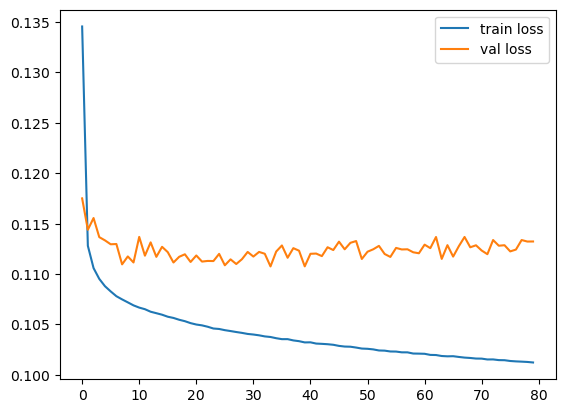

Epoch: 1
Train loss: 0.01531
Val loss: 0.01357
Epoch: 2
Train loss: 0.01313
Val loss: 0.01307
Epoch: 3
Train loss: 0.01281
Val loss: 0.01285
Epoch: 4
Train loss: 0.01264
Val loss: 0.01278
Epoch: 5
Train loss: 0.01254
Val loss: 0.01272
Epoch: 6
Train loss: 0.01246
Val loss: 0.01259
Epoch: 7
Train loss: 0.01242
Val loss: 0.01263
Epoch: 8
Train loss: 0.01237
Val loss: 0.01256
Epoch: 9
Train loss: 0.01234
Val loss: 0.01260
Epoch: 10
Train loss: 0.01229
Val loss: 0.01243
Epoch: 11
Train loss: 0.01227
Val loss: 0.01244
Epoch: 12
Train loss: 0.01223
Val loss: 0.01254
Epoch: 13
Train loss: 0.01220
Val loss: 0.01250
Epoch: 14
Train loss: 0.01218
Val loss: 0.01237
Epoch: 15
Train loss: 0.01216
Val loss: 0.01246
Epoch: 16
Train loss: 0.01214
Val loss: 0.01247
Epoch: 17
Train loss: 0.01212
Val loss: 0.01251
Epoch: 18
Train loss: 0.01210
Val loss: 0.01236
Epoch: 19
Train loss: 0.01208
Val loss: 0.01224
Epoch: 20
Train loss: 0.01206
Val loss: 0.01248
Epoch: 21
Train loss: 0.01206
Val loss: 0.01232
E

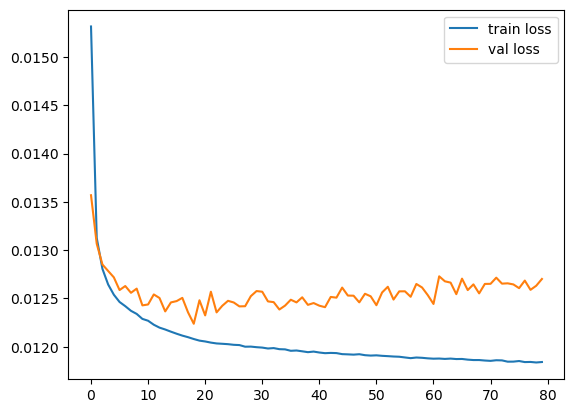

Epoch: 1
Train loss: 0.01536
Val loss: 0.01368
Epoch: 2
Train loss: 0.01292
Val loss: 0.01280
Epoch: 3
Train loss: 0.01260
Val loss: 0.01262
Epoch: 4
Train loss: 0.01242
Val loss: 0.01236
Epoch: 5
Train loss: 0.01231
Val loss: 0.01254
Epoch: 6
Train loss: 0.01223
Val loss: 0.01248
Epoch: 7
Train loss: 0.01217
Val loss: 0.01235
Epoch: 8
Train loss: 0.01211
Val loss: 0.01232
Epoch: 9
Train loss: 0.01207
Val loss: 0.01230
Epoch: 10
Train loss: 0.01203
Val loss: 0.01224
Epoch: 11
Train loss: 0.01200
Val loss: 0.01224
Epoch: 12
Train loss: 0.01197
Val loss: 0.01224
Epoch: 13
Train loss: 0.01195
Val loss: 0.01222
Epoch: 14
Train loss: 0.01191
Val loss: 0.01229
Epoch: 15
Train loss: 0.01190
Val loss: 0.01223
Epoch: 16
Train loss: 0.01188
Val loss: 0.01222
Epoch: 17
Train loss: 0.01186
Val loss: 0.01211
Epoch: 18
Train loss: 0.01184
Val loss: 0.01219
Epoch: 19
Train loss: 0.01183
Val loss: 0.01212
Epoch: 20
Train loss: 0.01181
Val loss: 0.01213
Epoch: 21
Train loss: 0.01181
Val loss: 0.01216
E

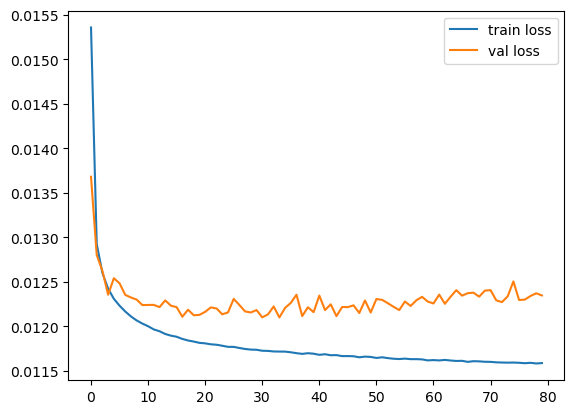

Epoch: 1
Train loss: 0.13691
Val loss: 0.11463
Epoch: 2
Train loss: 0.11289
Val loss: 0.10881
Epoch: 3
Train loss: 0.11077
Val loss: 0.10834
Epoch: 4
Train loss: 0.10969
Val loss: 0.10956
Epoch: 5
Train loss: 0.10892
Val loss: 0.10934
Epoch: 6
Train loss: 0.10837
Val loss: 0.10784
Epoch: 7
Train loss: 0.10799
Val loss: 0.10692
Epoch: 8
Train loss: 0.10765
Val loss: 0.10752
Epoch: 9
Train loss: 0.10721
Val loss: 0.10754
Epoch: 10
Train loss: 0.10698
Val loss: 0.10695
Epoch: 11
Train loss: 0.10674
Val loss: 0.10784
Epoch: 12
Train loss: 0.10659
Val loss: 0.10709
Save early stopping model at epoch 12
Epoch: 13
Train loss: 0.10634
Val loss: 0.10769
Epoch: 14
Train loss: 0.10614
Val loss: 0.10823
Epoch: 15
Train loss: 0.10598
Val loss: 0.10734
Epoch: 16
Train loss: 0.10580
Val loss: 0.10763
Epoch: 17
Train loss: 0.10566
Val loss: 0.10760
Epoch: 18
Train loss: 0.10550
Val loss: 0.10734
Epoch: 19
Train loss: 0.10539
Val loss: 0.10715
Epoch: 20
Train loss: 0.10521
Val loss: 0.10737
Epoch: 21
T

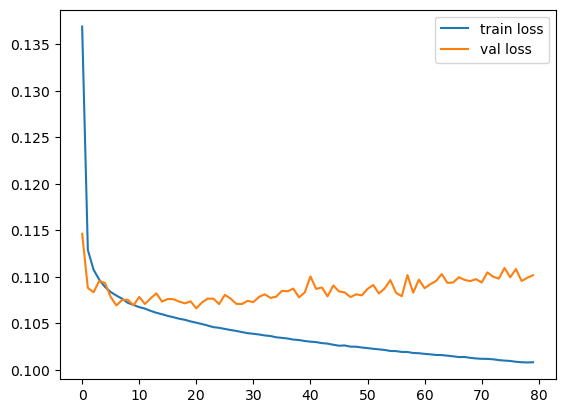

Epoch: 1
Train loss: 0.01566
Val loss: 0.01355
Epoch: 2
Train loss: 0.01321
Val loss: 0.01304
Epoch: 3
Train loss: 0.01286
Val loss: 0.01295
Epoch: 4
Train loss: 0.01270
Val loss: 0.01267
Epoch: 5
Train loss: 0.01257
Val loss: 0.01268
Epoch: 6
Train loss: 0.01250
Val loss: 0.01270
Epoch: 7
Train loss: 0.01244
Val loss: 0.01255
Epoch: 8
Train loss: 0.01239
Val loss: 0.01267
Epoch: 9
Train loss: 0.01234
Val loss: 0.01252
Epoch: 10
Train loss: 0.01230
Val loss: 0.01251
Epoch: 11
Train loss: 0.01226
Val loss: 0.01255
Epoch: 12
Train loss: 0.01222
Val loss: 0.01242
Epoch: 13
Train loss: 0.01220
Val loss: 0.01237
Epoch: 14
Train loss: 0.01217
Val loss: 0.01246
Epoch: 15
Train loss: 0.01214
Val loss: 0.01237
Epoch: 16
Train loss: 0.01211
Val loss: 0.01228
Epoch: 17
Train loss: 0.01210
Val loss: 0.01242
Epoch: 18
Train loss: 0.01208
Val loss: 0.01237
Epoch: 19
Train loss: 0.01206
Val loss: 0.01241
Epoch: 20
Train loss: 0.01205
Val loss: 0.01250
Epoch: 21
Train loss: 0.01204
Val loss: 0.01231
S

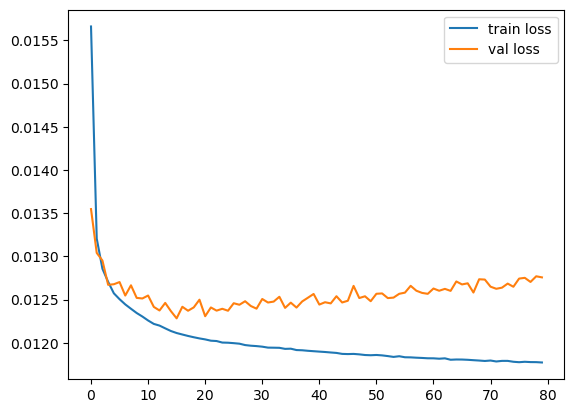

Epoch: 1
Train loss: 0.01561
Val loss: 0.01347
Epoch: 2
Train loss: 0.01309
Val loss: 0.01295
Epoch: 3
Train loss: 0.01275
Val loss: 0.01276
Epoch: 4
Train loss: 0.01261
Val loss: 0.01260
Epoch: 5
Train loss: 0.01250
Val loss: 0.01256
Epoch: 6
Train loss: 0.01242
Val loss: 0.01246
Epoch: 7
Train loss: 0.01237
Val loss: 0.01246
Epoch: 8
Train loss: 0.01231
Val loss: 0.01237
Epoch: 9
Train loss: 0.01228
Val loss: 0.01238
Epoch: 10
Train loss: 0.01223
Val loss: 0.01226
Epoch: 11
Train loss: 0.01220
Val loss: 0.01236
Epoch: 12
Train loss: 0.01217
Val loss: 0.01238
Epoch: 13
Train loss: 0.01214
Val loss: 0.01238
Epoch: 14
Train loss: 0.01211
Val loss: 0.01234
Epoch: 15
Train loss: 0.01208
Val loss: 0.01223
Epoch: 16
Train loss: 0.01206
Val loss: 0.01220
Epoch: 17
Train loss: 0.01203
Val loss: 0.01215
Epoch: 18
Train loss: 0.01201
Val loss: 0.01216
Epoch: 19
Train loss: 0.01199
Val loss: 0.01222
Epoch: 20
Train loss: 0.01197
Val loss: 0.01217
Epoch: 21
Train loss: 0.01197
Val loss: 0.01218
E

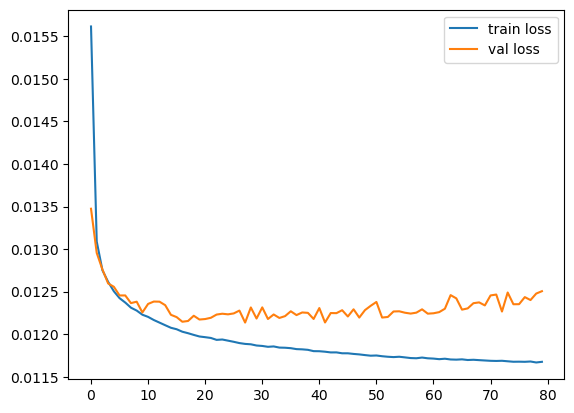

Epoch: 1
Train loss: 0.13872
Val loss: 0.11348
Epoch: 2
Train loss: 0.11350
Val loss: 0.10980
Epoch: 3
Train loss: 0.11125
Val loss: 0.10881
Epoch: 4
Train loss: 0.11009
Val loss: 0.10886
Epoch: 5
Train loss: 0.10937
Val loss: 0.10783
Epoch: 6
Train loss: 0.10884
Val loss: 0.10764
Epoch: 7
Train loss: 0.10838
Val loss: 0.10758
Epoch: 8
Train loss: 0.10807
Val loss: 0.10770
Epoch: 9
Train loss: 0.10777
Val loss: 0.10715
Epoch: 10
Train loss: 0.10754
Val loss: 0.10786
Epoch: 11
Train loss: 0.10726
Val loss: 0.10729
Epoch: 12
Train loss: 0.10701
Val loss: 0.10671
Epoch: 13
Train loss: 0.10685
Val loss: 0.10734
Epoch: 14
Train loss: 0.10664
Val loss: 0.10657
Epoch: 15
Train loss: 0.10639
Val loss: 0.10631
Epoch: 16
Train loss: 0.10625
Val loss: 0.10688
Epoch: 17
Train loss: 0.10603
Val loss: 0.10748
Epoch: 18
Train loss: 0.10590
Val loss: 0.10807
Epoch: 19
Train loss: 0.10570
Val loss: 0.10750
Epoch: 20
Train loss: 0.10558
Val loss: 0.10714
Save early stopping model at epoch 20
Epoch: 21
T

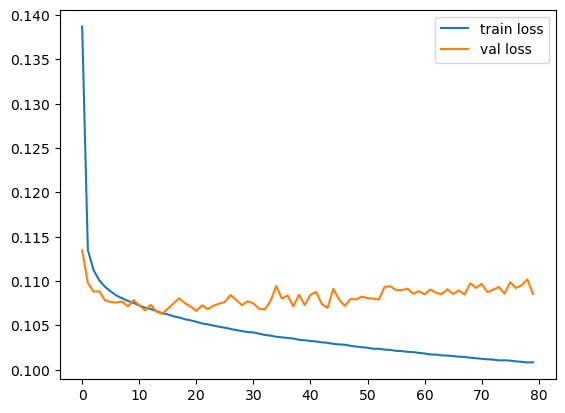

Epoch: 1
Train loss: 0.01596
Val loss: 0.01388
Epoch: 2
Train loss: 0.01350
Val loss: 0.01318
Epoch: 3
Train loss: 0.01311
Val loss: 0.01302
Epoch: 4
Train loss: 0.01293
Val loss: 0.01287
Epoch: 5
Train loss: 0.01282
Val loss: 0.01270
Epoch: 6
Train loss: 0.01274
Val loss: 0.01263
Epoch: 7
Train loss: 0.01268
Val loss: 0.01249
Epoch: 8
Train loss: 0.01263
Val loss: 0.01258
Epoch: 9
Train loss: 0.01258
Val loss: 0.01262
Epoch: 10
Train loss: 0.01253
Val loss: 0.01242
Epoch: 11
Train loss: 0.01250
Val loss: 0.01255
Epoch: 12
Train loss: 0.01246
Val loss: 0.01244
Epoch: 13
Train loss: 0.01243
Val loss: 0.01243
Epoch: 14
Train loss: 0.01240
Val loss: 0.01244
Epoch: 15
Train loss: 0.01237
Val loss: 0.01244
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01235
Val loss: 0.01243
Epoch: 17
Train loss: 0.01233
Val loss: 0.01240
Epoch: 18
Train loss: 0.01231
Val loss: 0.01242
Epoch: 19
Train loss: 0.01228
Val loss: 0.01238
Epoch: 20
Train loss: 0.01228
Val loss: 0.01235
Epoch: 21
T

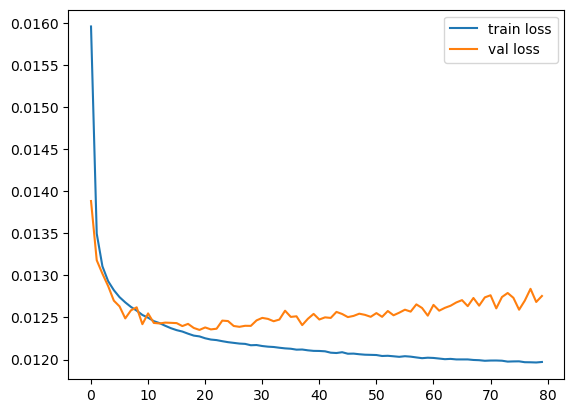

Epoch: 1
Train loss: 0.01597
Val loss: 0.01353
Epoch: 2
Train loss: 0.01333
Val loss: 0.01281
Epoch: 3
Train loss: 0.01297
Val loss: 0.01281
Epoch: 4
Train loss: 0.01281
Val loss: 0.01276
Epoch: 5
Train loss: 0.01270
Val loss: 0.01247
Epoch: 6
Train loss: 0.01262
Val loss: 0.01255
Epoch: 7
Train loss: 0.01254
Val loss: 0.01250
Epoch: 8
Train loss: 0.01248
Val loss: 0.01249
Epoch: 9
Train loss: 0.01243
Val loss: 0.01253
Epoch: 10
Train loss: 0.01240
Val loss: 0.01245
Epoch: 11
Train loss: 0.01235
Val loss: 0.01238
Epoch: 12
Train loss: 0.01231
Val loss: 0.01248
Epoch: 13
Train loss: 0.01228
Val loss: 0.01235
Epoch: 14
Train loss: 0.01225
Val loss: 0.01238
Epoch: 15
Train loss: 0.01223
Val loss: 0.01235
Epoch: 16
Train loss: 0.01220
Val loss: 0.01236
Epoch: 17
Train loss: 0.01219
Val loss: 0.01227
Epoch: 18
Train loss: 0.01218
Val loss: 0.01239
Epoch: 19
Train loss: 0.01215
Val loss: 0.01227
Epoch: 20
Train loss: 0.01214
Val loss: 0.01236
Epoch: 21
Train loss: 0.01212
Val loss: 0.01248
E

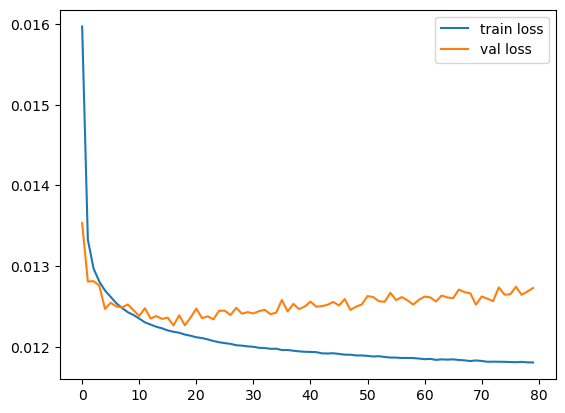

In [12]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [12,14,16,18]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

## Evaluation

In [59]:
def show_samples(p):
    generator = Generator_eye(p, theta, (-a,a))
    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_test_normalized = (Y_test - mean) / std 

    md_mean_es = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)

    md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'_es.pt'))
    md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'_es.pt'))
    md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'_es.pt'))

    pred_mean = predict(md_mean_es, Y_test_normalized)
    pred_q025 = predict(md_q025_es, Y_test_normalized)
    pred_q975 = predict(md_q975_es, Y_test_normalized)

    true_mean = np.zeros_like(Y_test)
    true_q025 = np.zeros_like(Y_test)
    true_q975 = np.zeros_like(Y_test)
    for i in range(Y_test.shape[0]):
        for j in range(Y_test.shape[1]):
            true_mean[i,j] = computePosMean(Y_test[i,j], theta, a, sigma)
            true_q025[i,j], true_q975[i,j] = computePPI(Y_test[i,j], theta, a, sigma)

    subset = np.where(np.abs(beta_test)>2)[0]
    t = 1000 * time.time()
    np.random.seed(int(t) % 2**32)
    rng.shuffle(subset)
    subset = subset[:6]

    plt.figure(figsize=(12,10))
    for i, idx in enumerate(subset):
        plt.subplot(3,2,i+1)
        plt.plot(range(p), true_mean[idx])
        plt.plot(range(p), pred_mean[idx])
        plt.vlines(range(p), true_q025[idx], true_q975[idx], color='red')
        plt.vlines(np.arange(p)+0.1, pred_q025[idx], pred_q975[idx], color='green')
        plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
        plt.ylim(-11,11)
    plt.show()

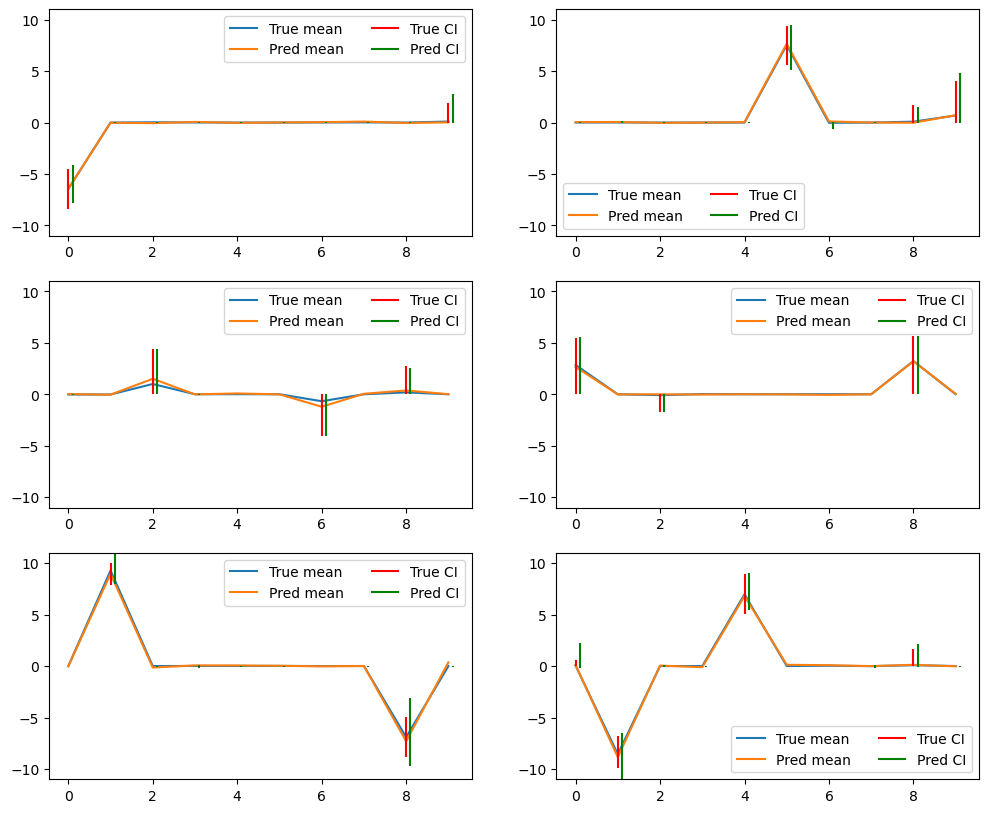

In [77]:
show_samples(10)

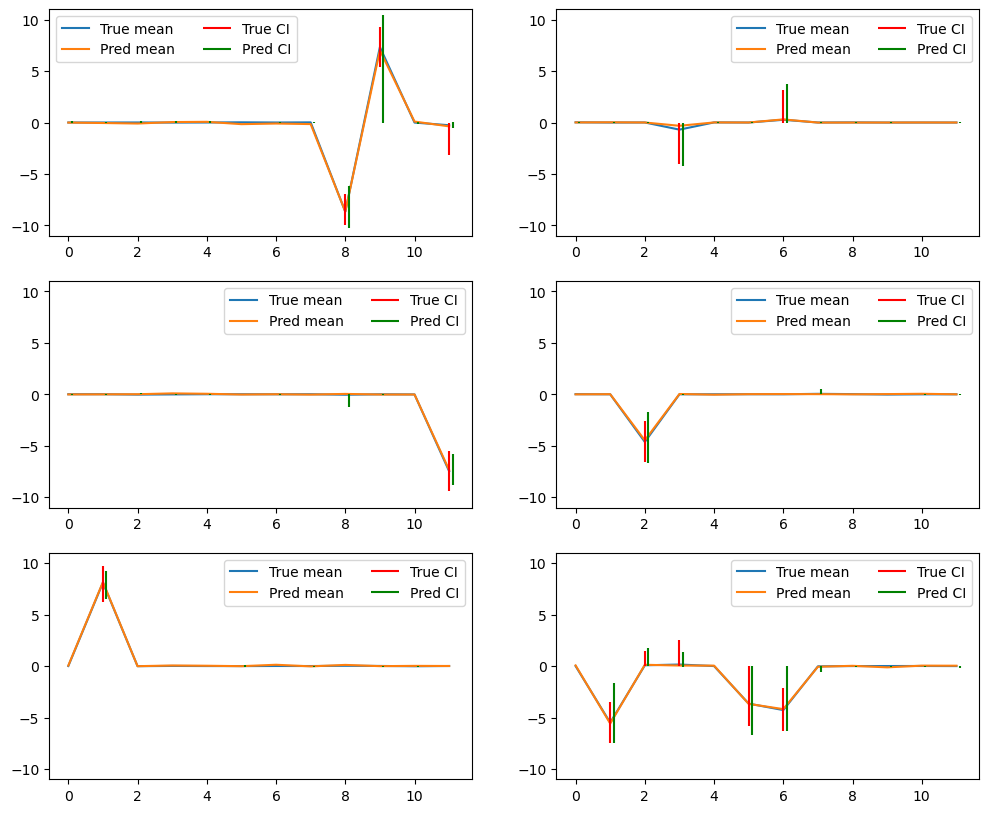

In [76]:
show_samples(12)

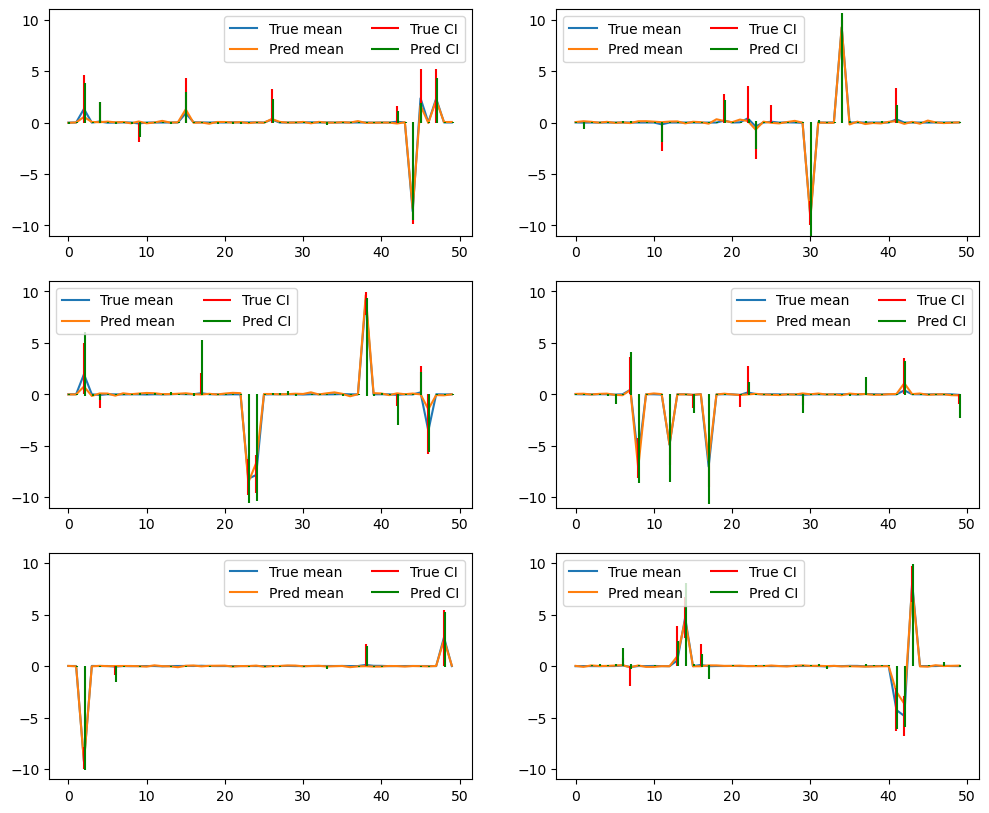

In [78]:
show_samples(50)

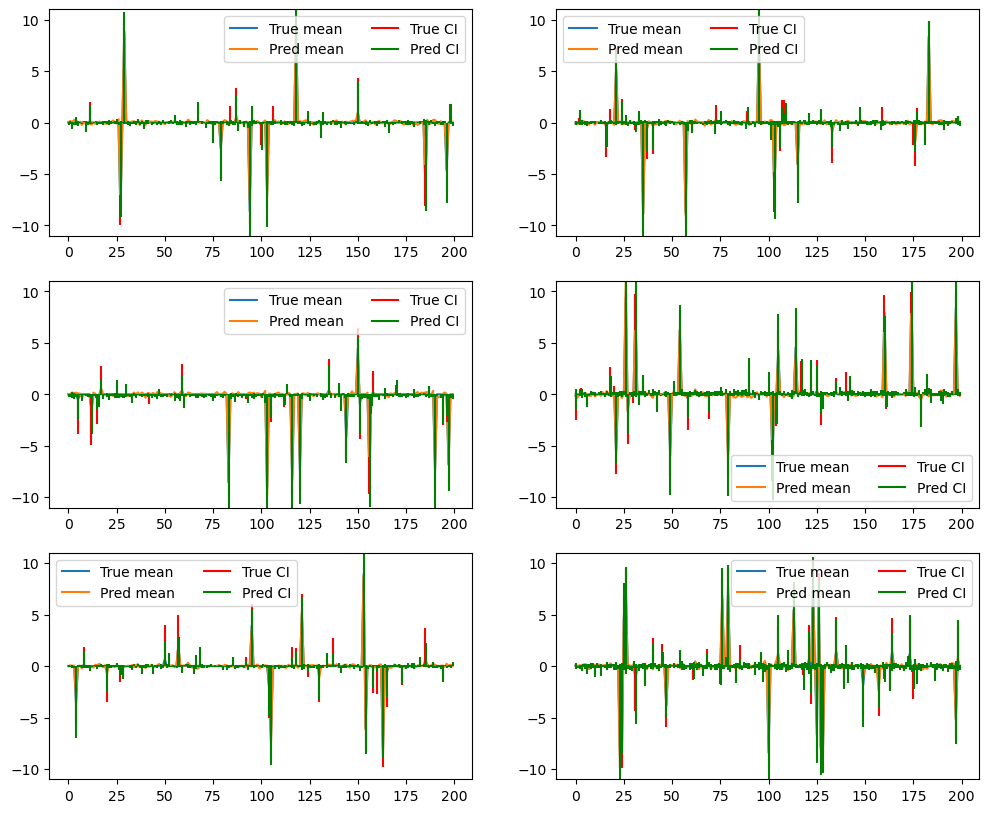

In [74]:
show_samples(200)

In [73]:
md = MLP_light(10, 10).to(device)
summary(md, input_size=((1,10)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]          11,264
              ReLU-2              [-1, 1, 1024]               0
            Linear-3              [-1, 1, 1024]       1,049,600
              ReLU-4              [-1, 1, 1024]               0
            Linear-5                [-1, 1, 10]          10,250
Total params: 1,071,114
Trainable params: 1,071,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.09
Estimated Total Size (MB): 4.12
----------------------------------------------------------------


In [79]:
md_q025_p12 = MLP_light(12, 12).to(device)
md_q025_p12.load_state_dict(torch.load('./model/q025_p12_es.pt'))

<All keys matched successfully>

In [82]:
p1 = next(md_q025_p12.parameters())

In [85]:
p1[0]

tensor([ 0.2146,  0.2065,  0.0240, -0.1872,  0.1072, -0.0376,  0.1541,  0.0523,
        -0.2120,  0.1477,  0.0328, -0.0764], device='cuda:0',
       grad_fn=<SelectBackward0>)